In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import os
import glob
import pandas as pd
import sys
sys.path.append('/Users/laltman2/python/')
import pyrkm
import torch

/Users/laltman2/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Most of this was copied from Marcelo's example notebook:

# https://kirchhoff-machines.github.io/pyrkm/examples/first_example/

In [3]:
# Torch operations: set double type
torch.set_default_dtype(torch.float64)

# Select which gpu you want to use if a multi-gpu system
gpu_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    # otherwise use multicore-CPU
    torch.set_num_threads(24)
print(device)

# Fix the seed for reproducibility
torch.manual_seed(42)

cpu


In [4]:
# set up directories
pyrkm.ensure_dir('model_states')
pyrkm.ensure_dir('model_measure')

In [5]:
# data
dps = [[1,0], [0,1]]

# number of test points
ntest = 20

# don't repeat points
nrepeat = 1

# create train data
train_data = torch.Tensor(dps).repeat(nrepeat,1)

# create train data
testing_data = torch.Tensor([])
for i in range(ntest):
    dp = [dps[np.random.randint(2)]]
    testing_data = torch.cat((testing_data, torch.Tensor(dp)), 0)
    
train_data

tensor([[1., 0.],
        [0., 1.]])

In [6]:
# Model parameters:

# 1000 epochs
max_epochs = 1000

# no batching
batch_size = 1

# alpha
lr = 0.001

# SGD (stochastic gradient descent)
optimizer = 'SGD'

# RKM energy type means it will evaluate the RKM learning rule
energy_type = 'RKM'

# model size
nvisible = 2
nhidden = 2

# range of parameter values
minWeight = -20
maxWeight = 20

# number of Gibbs sampling steps
k = 1

# persistent chain
train_algo = 'PCD'

# nothing fancy in learning rule
centering = False
regularization = False

out_infix = 'test'

# temperature
model_beta = 1001.

# sampling method to use (not sure if this is correct)
sampling = 'multi-threshold'

# distribution to sample from
distribution = 'gaussian'

# whether to scale the layer by the number of units
layer_scaled = True

mytype = torch.float32

# folder to save results to
model_name='deterministic'

# # uncomment this below if you want to start from scratch
# for f in glob.glob('./model_states/{}_*'.format(model_name)):
#     os.remove(f)

In [7]:
# Set the data type
train_data = train_data.to(mytype)
testing_data = testing_data.to(mytype)
# Perepare the batchloader
train_loader = torch.utils.data.DataLoader(train_data.to(device),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

In [8]:
# *****  Load the model and Train
# check if previous save point is available
# is_loadable, model = pyrkm.load_model(model_name, delete_previous=False)
# if not is_loadable:
if True:
    # *** Initialize
    model = pyrkm.RKM(model_name=model_name,
                      n_visible=nvisible,
                      n_hidden=nhidden,
                      k=k,
                      lr=lr,
                      max_epochs=max_epochs,
                      energy_type=energy_type,
                      optimizer=optimizer,
                      batch_size=batch_size,
                      train_algo=train_algo,
                      centering=centering,
                      model_beta=model_beta,
                      mytype=mytype,
                      regularization = regularization,
                      sampling = sampling,
                      distribution = distribution)

*** Initializing deterministic
The model is working on the following device: cpu


In [9]:
# which epochs to "measure" at
model.t_to_save = np.arange(max_epochs)

In [10]:
model.train(train_loader, testing_data.to(model.device), print_error=True)

Epoch: 100 , train-err 0.5 , time: 0.001947
Epoch: 200 , train-err 0 , time: 0.001718
Epoch: 300 , train-err 0.5 , time: 0.001572
Epoch: 400 , train-err 0.5 , time: 0.001751
Epoch: 500 , train-err 0.5 , time: 0.001560
Epoch: 600 , train-err 0.5 , time: 0.001726
Epoch: 700 , train-err 0.5 , time: 0.001722
Epoch: 800 , train-err 0 , time: 0.001678
Epoch: 900 , train-err 0.5 , time: 0.001629
Epoch: 1000 , train-err 0.5 , time: 0.000993
*** Training finished


In [11]:
dps

[[1, 0], [0, 1]]

In [16]:
# Get all the intermediate states
filename_list = glob.glob('model_states/{}_t*.pkl'.format(model_name))
all_loadpoints = sorted(
    [int(x.split('_t')[-1].split('.pkl')[0]) for x in filename_list])

# Prepare a list of all the measures
rec_error_train_array = []
rec_error_test_array = []
W = []
Vb = []
Hb = []

Ha0 = []
Ha1 = []
V1a0 = []
V1a1 = []
V2a0 = []
V2a1 = []

# Loop over all the loadpoints and measure the physical quantities
for t in all_loadpoints:
    with open('model_states/{}_t{}.pkl'.format(model_name, t), "rb") as file:
        model = pickle.load(file)
        H0, _ = model.v_to_h(torch.Tensor(dps[0]))
        print('H0', H0)
        H1, _ = model.v_to_h(torch.Tensor(dps[1]))
        Ha0.append(H0)
        Ha1.append(H1)
        print('H1', H1)
        
#         digitize H0, H1
        digiH0 = np.sign(H0)
        print('digiH0', digiH0)
        digiH1 = np.sign(H1)
        print('digiH1', digiH1)
        
#         rewrite this for proper reconstruction

        [V1, V2], _ = model.h_to_v(digiH0)
        V1a0.append(V1)
        V2a0.append(V2)
        print('reconstructed dps0', [V1, V2])
        
        [V1, V2], _ = model.h_to_v(digiH1)
        V1a1.append(V1)
        V2a1.append(V2)
        print('reconstructed dps1', [V1, V2])
        
        
#         bloop()
        
        # errors
        k = model.k
        # Compute reconstruction error (averaged over pixels and samples)
        v_model = model.forward(train_data.to(model.device), k)
        rec_error_train = ((v_model -
                            train_data.to(model.device))**2).mean(1).mean(0)
        # Now compute the reconstruction error for the test set only
        v_model = model.forward(testing_data.to(model.device), k)
        rec_error_test = ((v_model -
                           testing_data.to(model.device))**2).mean(1).mean(0)
        rec_error_train_array.append(rec_error_train.cpu().numpy())
        rec_error_test_array.append(rec_error_test.cpu().numpy())
        W.append(model.W.cpu().numpy())
        Vb.append(model.v_bias.cpu().numpy())
        Hb.append(model.h_bias.cpu().numpy())


# transform to np array
rec_error_train_array = np.array(rec_error_train_array)
rec_error_test_array = np.array(rec_error_test_array)
W = np.array(W).reshape((len(W), 4))
Vb = np.array(Vb).reshape((len(Vb), 2))
Hb = np.array(Hb).reshape((len(Hb), 2))
Ha0 = np.array(Ha0)
Ha1 = np.array(Ha1)
V1a0 = np.array(V1a0)
V1a1 = np.array(V1a1)
V2a0 = np.array(V2a0)
V2a1 = np.array(V2a1)

H0 tensor([0.7020, 0.4895])
H1 tensor([0.2980, 0.5105])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.4735), tensor(-0.3968)]
reconstructed dps1 [tensor(-0.4735), tensor(-0.3968)]
H0 tensor([0.7105, 0.5042])
H1 tensor([0.2895, 0.4958])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.4722), tensor(-0.3968)]
reconstructed dps1 [tensor(-0.4722), tensor(-0.3968)]
H0 tensor([0.7070, 0.5180])
H1 tensor([0.2930, 0.4820])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.4709), tensor(-0.3968)]
reconstructed dps1 [tensor(-0.4709), tensor(-0.3968)]
H0 tensor([0.6889, 0.5038])
H1 tensor([0.3111, 0.4962])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.4709), tensor(-0.3892)]
reconstructed dps1 [tensor(-0.4709), tensor(-0.3892)]
H0 tensor([0.6967, 0.5162])
H1 tensor([0.3033, 0.4838])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.4696), tensor(-0.3

reconstructed dps0 [tensor(-0.3961), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.3961), tensor(-0.0049)]
H0 tensor([0.5666, 0.5179])
H1 tensor([0.4334, 0.4821])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.3961), tensor(0.0027)]
reconstructed dps1 [tensor(-0.3961), tensor(0.0027)]
H0 tensor([0.5666, 0.5179])
H1 tensor([0.4334, 0.4821])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.3961), tensor(0.0027)]
reconstructed dps1 [tensor(-0.3961), tensor(0.0027)]
H0 tensor([0.5734, 0.5247])
H1 tensor([0.4266, 0.4753])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.3948), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.3948), tensor(-0.0049)]
H0 tensor([0.5695, 0.5211])
H1 tensor([0.4305, 0.4789])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.3948), tensor(0.0027)]
reconstructed dps1 [tensor(-0.3948), tensor(0.0027)]
H0 tensor([0.5762, 0.5279])
H1 tensor([0.4238, 0.4

reconstructed dps0 [tensor(-0.3213), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.3213), tensor(-0.0049)]
H0 tensor([0.6871, 0.6520])
H1 tensor([0.3129, 0.3480])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.3213), tensor(0.0027)]
reconstructed dps1 [tensor(-0.3213), tensor(0.0027)]
H0 tensor([0.6920, 0.6569])
H1 tensor([0.3080, 0.3431])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.3200), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.3200), tensor(-0.0049)]
H0 tensor([0.6887, 0.6537])
H1 tensor([0.3113, 0.3463])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.3200), tensor(0.0027)]
reconstructed dps1 [tensor(-0.3200), tensor(0.0027)]
H0 tensor([0.6935, 0.6586])
H1 tensor([0.3065, 0.3414])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.3187), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.3187), tensor(-0.0049)]
H0 tensor([0.6902, 0.6554])
H1 tensor([0.3098, 0

reconstructed dps0 [tensor(-0.2465), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.2465), tensor(-0.0049)]
H0 tensor([0.7552, 0.7278])
H1 tensor([0.2448, 0.2722])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.2465), tensor(0.0027)]
reconstructed dps1 [tensor(-0.2465), tensor(0.0027)]
H0 tensor([0.7591, 0.7316])
H1 tensor([0.2409, 0.2684])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.2452), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.2452), tensor(-0.0049)]
H0 tensor([0.7562, 0.7288])
H1 tensor([0.2438, 0.2712])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.2452), tensor(0.0027)]
reconstructed dps1 [tensor(-0.2452), tensor(0.0027)]
H0 tensor([0.7600, 0.7326])
H1 tensor([0.2400, 0.2674])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.2439), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.2439), tensor(-0.0049)]
H0 tensor([0.7571, 0.7298])
H1 tensor([0.2429, 0

reconstructed dps0 [tensor(-0.1717), tensor(0.0027)]
reconstructed dps1 [tensor(-0.1717), tensor(0.0027)]
H0 tensor([0.8021, 0.7796])
H1 tensor([0.1979, 0.2204])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.1704), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.1704), tensor(-0.0049)]
H0 tensor([0.7996, 0.7771])
H1 tensor([0.2004, 0.2229])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.1704), tensor(0.0027)]
reconstructed dps1 [tensor(-0.1704), tensor(0.0027)]
H0 tensor([0.8027, 0.7803])
H1 tensor([0.1973, 0.2197])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.1691), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.1691), tensor(-0.0049)]
H0 tensor([0.8002, 0.7778])
H1 tensor([0.1998, 0.2222])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.1691), tensor(0.0027)]
reconstructed dps1 [tensor(-0.1691), tensor(0.0027)]
H0 tensor([0.8033, 0.7809])
H1 tensor([0.1967, 0.2

H0 tensor([0.8285, 0.8089])
H1 tensor([0.1715, 0.1911])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.1061), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.1061), tensor(-0.0049)]
H0 tensor([0.8262, 0.8067])
H1 tensor([0.1738, 0.1933])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.1061), tensor(0.0027)]
reconstructed dps1 [tensor(-0.1061), tensor(0.0027)]
H0 tensor([0.8262, 0.8067])
H1 tensor([0.1738, 0.1933])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.1061), tensor(0.0027)]
reconstructed dps1 [tensor(-0.1061), tensor(0.0027)]
H0 tensor([0.8289, 0.8095])
H1 tensor([0.1711, 0.1905])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.1047), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.1047), tensor(-0.0049)]
H0 tensor([0.8294, 0.8100])
H1 tensor([0.1706, 0.1900])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.1034), tensor(-0.0049)

H0 tensor([0.8495, 0.8326])
H1 tensor([0.1505, 0.1674])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.0313), tensor(0.0027)]
reconstructed dps1 [tensor(-0.0313), tensor(0.0027)]
H0 tensor([0.8495, 0.8326])
H1 tensor([0.1505, 0.1674])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.0313), tensor(0.0027)]
reconstructed dps1 [tensor(-0.0313), tensor(0.0027)]
H0 tensor([0.8518, 0.8350])
H1 tensor([0.1482, 0.1650])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.0300), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.0300), tensor(-0.0049)]
H0 tensor([0.8522, 0.8353])
H1 tensor([0.1478, 0.1647])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.0286), tensor(-0.0049)]
reconstructed dps1 [tensor(-0.0286), tensor(-0.0049)]
H0 tensor([0.8502, 0.8334])
H1 tensor([0.1498, 0.1666])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.0286), tensor(0.0027)]

reconstructed dps1 [tensor(-0.0011), tensor(0.0027)]
H0 tensor([0.8594, 0.8434])
H1 tensor([0.1406, 0.1566])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(0.0002), tensor(-0.0049)]
reconstructed dps1 [tensor(0.0002), tensor(-0.0049)]
H0 tensor([0.8575, 0.8415])
H1 tensor([0.1425, 0.1585])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(0.0002), tensor(0.0027)]
reconstructed dps1 [tensor(0.0002), tensor(0.0027)]
H0 tensor([0.8597, 0.8438])
H1 tensor([0.1403, 0.1562])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(0.0015), tensor(-0.0049)]
reconstructed dps1 [tensor(0.0015), tensor(-0.0049)]
H0 tensor([0.8575, 0.8415])
H1 tensor([0.1425, 0.1585])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(0.0002), tensor(0.0027)]
reconstructed dps1 [tensor(0.0002), tensor(0.0027)]
H0 tensor([0.8594, 0.8434])
H1 tensor([0.1406, 0.1566])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconst

reconstructed dps1 [tensor(0.0015), tensor(-0.0049)]
H0 tensor([0.8575, 0.8415])
H1 tensor([0.1425, 0.1585])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(0.0002), tensor(0.0027)]
reconstructed dps1 [tensor(0.0002), tensor(0.0027)]
H0 tensor([0.8575, 0.8415])
H1 tensor([0.1425, 0.1585])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(0.0002), tensor(0.0027)]
reconstructed dps1 [tensor(0.0002), tensor(0.0027)]
H0 tensor([0.8594, 0.8434])
H1 tensor([0.1406, 0.1566])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(0.0002), tensor(-0.0049)]
reconstructed dps1 [tensor(0.0002), tensor(-0.0049)]
H0 tensor([0.8572, 0.8412])
H1 tensor([0.1428, 0.1588])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconstructed dps0 [tensor(-0.0011), tensor(0.0027)]
reconstructed dps1 [tensor(-0.0011), tensor(0.0027)]
H0 tensor([0.8594, 0.8434])
H1 tensor([0.1406, 0.1566])
digiH0 tensor([1., 1.])
digiH1 tensor([1., 1.])
reconst

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_46811/3598657736.py:75: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_46811/3598657736.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_46811/35986

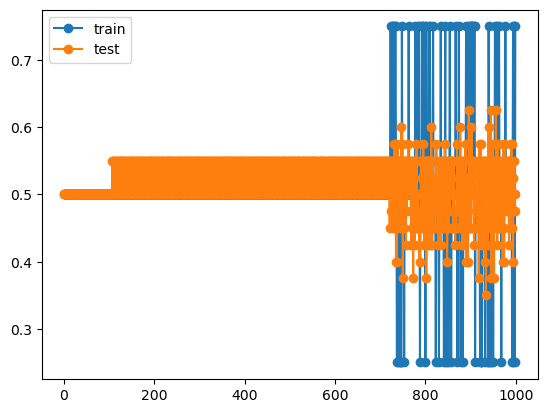

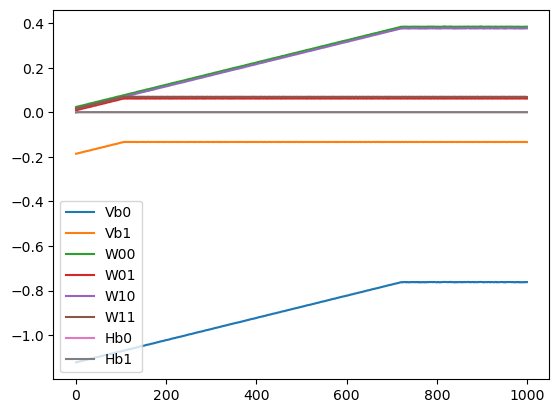

In [18]:
plt.plot(all_loadpoints,
            rec_error_train_array,
            '-o',
            label='train')
plt.plot(all_loadpoints,
            rec_error_test_array,
            '-o',
            label='test')

plt.legend()

plt.show()

plt.plot(all_loadpoints,Vb, label=['Vb0', 'Vb1'])
plt.plot(all_loadpoints,W, label=['W00', 'W01', 'W10', 'W11'])
plt.plot(all_loadpoints,Hb, label=['Hb0', 'Hb1'])
plt.legend()
# plt.xlim(2000, 3000)
plt.show()

# plt.plot(all_loadpoints, Ha0)
# plt.plot(all_loadpoints, Ha1)
# plt.plot(all_loadpoints, V1a0)
# plt.plot(all_loadpoints, V1a1)
# plt.plot(all_loadpoints, V2a0)
# plt.plot(all_loadpoints, V2a1)

In [137]:
df = pd.DataFrame({'epoch':all_loadpoints, 
                   'train_err': rec_error_train_array, 'test_err':rec_error_test_array, 
                   'W1': W[:,0], 'W2':W[:,1], 'Vb1': Vb[:,0],'Vb2':Vb[:,1], 'Hb1': Hb[:,0], 
                   'Ha0':Ha0, 'Ha1': Ha1, 'V1a0': V1a0, 'V1a1':V1a1, 'V2a0': V2a0, 'V2a1':V2a1, 
                   'model_name': model_name})

df
df.to_csv('data/simulation/{}.csv'.format(model_name))

In [23]:
betas = np.arange(2, 10)
betas

array([2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
dfs = []

ntrials = 20
max_epochs = 10000
lr = 0.001

for b in betas:
    model_beta = b

    modelnamebase = 'beta_{}'.format(str(b)) + '_test{}'
    for n in range(ntrials):
        model_name = modelnamebase.format(str(n).zfill(2))
        model = pyrkm.RKM(model_name=model_name,
                          n_visible=nvisible,
                          n_hidden=nhidden,
                          k=k,
                          lr=lr,
                          max_epochs=max_epochs,
                          energy_type=energy_type,
                          optimizer=optimizer,
                          batch_size=batch_size,
                          train_algo=train_algo,
                          centering=centering,
                          model_beta=model_beta,
                          mytype=mytype,
                          regularization = regularization,
                          sampling = sampling,
                          distribution = distribution)

        model.t_to_save = np.arange(0, max_epochs, 100)
        model.train(train_loader, testing_data.to(model.device), print_error=True)

        # Get all the intermediate states
        filename_list = glob.glob('model_states/{}_t*.pkl'.format(model_name))
        all_loadpoints = sorted(
            [int(x.split('_t')[-1].split('.pkl')[0]) for x in filename_list])

        # Prepare a list of all the measures
        rec_error_train_array = []
        rec_error_test_array = []
        W = []
        Vb = []
        Hb = []

        Ha0 = []
        Ha1 = []
        V1a0 = []
        V1a1 = []
        V2a0 = []
        V2a1 = []

        # Loop over all the loadpoints and measure the physical quantities
        for t in all_loadpoints:
            with open('model_states/{}_t{}.pkl'.format(model_name, t), "rb") as file:
                model = pickle.load(file)
                H0, _ = model.v_to_h(torch.Tensor(dps[0]))
                H1, _ = model.v_to_h(torch.Tensor(dps[1]))
                Ha0.append(H0)
                Ha1.append(H1)

                [V1, V2], _ = model.h_to_v(torch.Tensor([0]))
                V1a0.append(V1)
                V2a0.append(V2)

                [V1, V2], _ = model.h_to_v(torch.Tensor([1]))
                V1a1.append(V1)
                V2a1.append(V2)

                # errors
                k = model.k
                # Compute reconstruction error (averaged over pixels and samples)
                v_model = model.forward(train_data.to(model.device), k)
                rec_error_train = ((v_model -
                                    train_data.to(model.device))**2).mean(1).mean(0)
                # Now compute the reconstruction error for the test set only
                v_model = model.forward(testing_data.to(model.device), k)
                rec_error_test = ((v_model -
                                   testing_data.to(model.device))**2).mean(1).mean(0)
                rec_error_train_array.append(rec_error_train.cpu().numpy())
                rec_error_test_array.append(rec_error_test.cpu().numpy())
                W.append(model.W.cpu().numpy())
                Vb.append(model.v_bias.cpu().numpy())
                Hb.append(model.h_bias.cpu().numpy())


        # transform to np array
        rec_error_train_array = np.array(rec_error_train_array)
        rec_error_test_array = np.array(rec_error_test_array)
        W = np.array(W).reshape((len(W), 2))
        Vb = np.array(Vb).reshape((len(Vb), 2))
        Hb = np.array(Hb).reshape((len(Hb), 1))
        Ha0 = np.array(Ha0)
        Ha1 = np.array(Ha1)
        V1a0 = np.array(V1a0)
        V1a1 = np.array(V1a1)
        V2a0 = np.array(V2a0)
        V2a1 = np.array(V2a1)

        df = pd.DataFrame({'epoch':all_loadpoints, 
                       'train_err': rec_error_train_array, 'test_err':rec_error_test_array, 
                       'W1': W[:,0], 'W2':W[:,1], 'Vb1': Vb[:,0],'Vb2':Vb[:,1], 'Hb1': Hb[:,0], 
                       'Ha0':Ha0, 'Ha1': Ha1, 'V1a0': V1a0, 'V1a1':V1a1, 'V2a0': V2a0, 'V2a1':V2a1, 
                       'model_name': model_name})

        df.to_csv('data/simulation/{}.csv'.format(model_name))
        dfs.append(df)

*** Initializing beta_2_test00
The model is working on the following device: cpu
Epoch: 100 , train-err 0.5 , time: 0.006528
Epoch: 200 , train-err 1 , time: 0.002091
Epoch: 300 , train-err 1 , time: 0.001414
Epoch: 400 , train-err 1 , time: 0.002323
Epoch: 500 , train-err 1 , time: 0.001501
Epoch: 600 , train-err 1 , time: 0.001475
Epoch: 700 , train-err 1 , time: 0.002096
Epoch: 800 , train-err 0.5 , time: 0.001553
Epoch: 900 , train-err 0.5 , time: 0.002197
Epoch: 1000 , train-err 0 , time: 0.001563
Epoch: 1100 , train-err 1 , time: 0.002207
Epoch: 1200 , train-err 0.5 , time: 0.001574
Epoch: 1300 , train-err 0 , time: 0.001582
Epoch: 1400 , train-err 0.5 , time: 0.001404
Epoch: 1500 , train-err 0 , time: 0.001546
Epoch: 1600 , train-err 0.5 , time: 0.002031
Epoch: 1700 , train-err 0.5 , time: 0.001358
Epoch: 1800 , train-err 1 , time: 0.001586
Epoch: 1900 , train-err 0.5 , time: 0.001563
Epoch: 2000 , train-err 0.5 , time: 0.001384
Epoch: 2100 , train-err 0 , time: 0.002710
Epoch: 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001074
Epoch: 400 , train-err 0.5 , time: 0.001426
Epoch: 500 , train-err 0.5 , time: 0.001044
Epoch: 600 , train-err 0.5 , time: 0.001144
Epoch: 700 , train-err 0.5 , time: 0.001264
Epoch: 800 , train-err 0 , time: 0.001131
Epoch: 900 , train-err 0.5 , time: 0.001184
Epoch: 1000 , train-err 0.5 , time: 0.001185
Epoch: 1100 , train-err 0.5 , time: 0.001146
Epoch: 1200 , train-err 0.5 , time: 0.001038
Epoch: 1300 , train-err 0.5 , time: 0.001085
Epoch: 1400 , train-err 0.5 , time: 0.001203
Epoch: 1500 , train-err 0.5 , time: 0.001022
Epoch: 1600 , train-err 0.5 , time: 0.001045
Epoch: 1700 , train-err 0.5 , time: 0.001174
Epoch: 1800 , train-err 0 , time: 0.001082
Epoch: 1900 , train-err 0.5 , time: 0.001132
Epoch: 2000 , train-err 0.5 , time: 0.001188
Epoch: 2100 , train-err 1 , time: 0.001056
Epoch: 2200 , train-err 0 , time: 0.001194
Epoch: 2300 , train-err 1 , time: 0.000981
Epoch: 2400 , train-err 0.5 , time: 0.001100
Epoch: 2500 , train-err 1 ,

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001114
Epoch: 500 , train-err 0.5 , time: 0.001134
Epoch: 600 , train-err 0 , time: 0.001175
Epoch: 700 , train-err 0 , time: 0.001023
Epoch: 800 , train-err 0 , time: 0.001146
Epoch: 900 , train-err 0.5 , time: 0.001131
Epoch: 1000 , train-err 0.5 , time: 0.001061
Epoch: 1100 , train-err 0 , time: 0.001176
Epoch: 1200 , train-err 0.5 , time: 0.001144
Epoch: 1300 , train-err 1 , time: 0.001011
Epoch: 1400 , train-err 0.5 , time: 0.001125
Epoch: 1500 , train-err 0.5 , time: 0.001008
Epoch: 1600 , train-err 1 , time: 0.001157
Epoch: 1700 , train-err 0.5 , time: 0.001145
Epoch: 1800 , train-err 0.5 , time: 0.001074
Epoch: 1900 , train-err 0.5 , time: 0.001077
Epoch: 2000 , train-err 0.5 , time: 0.001180
Epoch: 2100 , train-err 1 , time: 0.001027
Epoch: 2200 , train-err 0.5 , time: 0.001093
Epoch: 2300 , train-err 0.5 , time: 0.001118
Epoch: 2400 , train-err 1 , time: 0.001237
Epoch: 2500 , train-err 1 , time: 0.001067
Epoch: 2600 , train-err 0.5 , time

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001120
Epoch: 500 , train-err 1 , time: 0.001155
Epoch: 600 , train-err 0 , time: 0.001188
Epoch: 700 , train-err 0 , time: 0.001141
Epoch: 800 , train-err 1 , time: 0.001270
Epoch: 900 , train-err 0.5 , time: 0.001115
Epoch: 1000 , train-err 0 , time: 0.001066
Epoch: 1100 , train-err 0.5 , time: 0.001108
Epoch: 1200 , train-err 0.5 , time: 0.001167
Epoch: 1300 , train-err 0 , time: 0.000997
Epoch: 1400 , train-err 1 , time: 0.001054
Epoch: 1500 , train-err 0 , time: 0.001156
Epoch: 1600 , train-err 0.5 , time: 0.001061
Epoch: 1700 , train-err 0 , time: 0.001142
Epoch: 1800 , train-err 0.5 , time: 0.001196
Epoch: 1900 , train-err 1 , time: 0.001070
Epoch: 2000 , train-err 0.5 , time: 0.001122
Epoch: 2100 , train-err 0.5 , time: 0.001147
Epoch: 2200 , train-err 1 , time: 0.001135
Epoch: 2300 , train-err 1 , time: 0.001147
Epoch: 2400 , train-err 0.5 , time: 0.001016
Epoch: 2500 , train-err 0 , time: 0.001106
Epoch: 2600 , train-err 0.5 , time: 0.001204

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001061
Epoch: 500 , train-err 0 , time: 0.001162
Epoch: 600 , train-err 0.5 , time: 0.001163
Epoch: 700 , train-err 0 , time: 0.001024
Epoch: 800 , train-err 0.5 , time: 0.001158
Epoch: 900 , train-err 1 , time: 0.001106
Epoch: 1000 , train-err 0.5 , time: 0.001053
Epoch: 1100 , train-err 1 , time: 0.001140
Epoch: 1200 , train-err 0 , time: 0.001077
Epoch: 1300 , train-err 0.5 , time: 0.001049
Epoch: 1400 , train-err 1 , time: 0.001147
Epoch: 1500 , train-err 0 , time: 0.001039
Epoch: 1600 , train-err 1 , time: 0.001024
Epoch: 1700 , train-err 1 , time: 0.001001
Epoch: 1800 , train-err 0 , time: 0.001097
Epoch: 1900 , train-err 0 , time: 0.001135
Epoch: 2000 , train-err 1 , time: 0.000992
Epoch: 2100 , train-err 0.5 , time: 0.001114
Epoch: 2200 , train-err 0 , time: 0.001167
Epoch: 2300 , train-err 0.5 , time: 0.001036
Epoch: 2400 , train-err 0.5 , time: 0.001348
Epoch: 2500 , train-err 0.5 , time: 0.001089
Epoch: 2600 , train-err 0.5 , time: 0.0009

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001252
Epoch: 500 , train-err 1 , time: 0.001093
Epoch: 600 , train-err 1 , time: 0.001150
Epoch: 700 , train-err 0 , time: 0.001132
Epoch: 800 , train-err 1 , time: 0.001050
Epoch: 900 , train-err 0 , time: 0.001093
Epoch: 1000 , train-err 0.5 , time: 0.001251
Epoch: 1100 , train-err 0.5 , time: 0.001006
Epoch: 1200 , train-err 0.5 , time: 0.001092
Epoch: 1300 , train-err 0 , time: 0.001191
Epoch: 1400 , train-err 0.5 , time: 0.001015
Epoch: 1500 , train-err 0.5 , time: 0.001121
Epoch: 1600 , train-err 1 , time: 0.001056
Epoch: 1700 , train-err 0.5 , time: 0.001119
Epoch: 1800 , train-err 0 , time: 0.001240
Epoch: 1900 , train-err 1 , time: 0.001093
Epoch: 2000 , train-err 0 , time: 0.001086
Epoch: 2100 , train-err 0 , time: 0.001213
Epoch: 2200 , train-err 0 , time: 0.001332
Epoch: 2300 , train-err 0 , time: 0.001280
Epoch: 2400 , train-err 0.5 , time: 0.001106
Epoch: 2500 , train-err 0 , time: 0.001014
Epoch: 2600 , train-err 1 , time: 0.001156
Epo

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001854
Epoch: 400 , train-err 0.5 , time: 0.001141
Epoch: 500 , train-err 0.5 , time: 0.001626
Epoch: 600 , train-err 0.5 , time: 0.001223
Epoch: 700 , train-err 0.5 , time: 0.001043
Epoch: 800 , train-err 0.5 , time: 0.001241
Epoch: 900 , train-err 0.5 , time: 0.001185
Epoch: 1000 , train-err 0.5 , time: 0.001157
Epoch: 1100 , train-err 1 , time: 0.001208
Epoch: 1200 , train-err 0.5 , time: 0.001248
Epoch: 1300 , train-err 0 , time: 0.001035
Epoch: 1400 , train-err 1 , time: 0.001135
Epoch: 1500 , train-err 0.5 , time: 0.001219
Epoch: 1600 , train-err 0 , time: 0.000981
Epoch: 1700 , train-err 0.5 , time: 0.001153
Epoch: 1800 , train-err 0 , time: 0.001129
Epoch: 1900 , train-err 1 , time: 0.001122
Epoch: 2000 , train-err 0.5 , time: 0.001211
Epoch: 2100 , train-err 1 , time: 0.001000
Epoch: 2200 , train-err 0.5 , time: 0.001198
Epoch: 2300 , train-err 1 , time: 0.001182
Epoch: 2400 , train-err 0.5 , time: 0.001018
Epoch: 2500 , train-err 0 , time: 0

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001223
Epoch: 500 , train-err 1 , time: 0.001070
Epoch: 600 , train-err 0.5 , time: 0.001162
Epoch: 700 , train-err 0.5 , time: 0.001162
Epoch: 800 , train-err 1 , time: 0.001073
Epoch: 900 , train-err 0.5 , time: 0.001142
Epoch: 1000 , train-err 0.5 , time: 0.001006
Epoch: 1100 , train-err 0 , time: 0.001167
Epoch: 1200 , train-err 1 , time: 0.001038
Epoch: 1300 , train-err 0 , time: 0.001091
Epoch: 1400 , train-err 0 , time: 0.001033
Epoch: 1500 , train-err 0.5 , time: 0.001094
Epoch: 1600 , train-err 0 , time: 0.001133
Epoch: 1700 , train-err 0.5 , time: 0.001056
Epoch: 1800 , train-err 0.5 , time: 0.001055
Epoch: 1900 , train-err 0.5 , time: 0.001098
Epoch: 2000 , train-err 0.5 , time: 0.001023
Epoch: 2100 , train-err 0.5 , time: 0.001531
Epoch: 2200 , train-err 0 , time: 0.001163
Epoch: 2300 , train-err 0.5 , time: 0.001022
Epoch: 2400 , train-err 0.5 , time: 0.001183
Epoch: 2500 , train-err 0.5 , time: 0.001155
Epoch: 2600 , train-err 0 , time: 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001146
Epoch: 500 , train-err 0 , time: 0.001038
Epoch: 600 , train-err 1 , time: 0.001165
Epoch: 700 , train-err 0.5 , time: 0.001168
Epoch: 800 , train-err 0.5 , time: 0.001088
Epoch: 900 , train-err 1 , time: 0.001065
Epoch: 1000 , train-err 0.5 , time: 0.001015
Epoch: 1100 , train-err 0.5 , time: 0.001144
Epoch: 1200 , train-err 0 , time: 0.001211
Epoch: 1300 , train-err 0 , time: 0.001064
Epoch: 1400 , train-err 1 , time: 0.001157
Epoch: 1500 , train-err 0.5 , time: 0.001244
Epoch: 1600 , train-err 0 , time: 0.001048
Epoch: 1700 , train-err 0 , time: 0.001178
Epoch: 1800 , train-err 0 , time: 0.001263
Epoch: 1900 , train-err 0.5 , time: 0.001096
Epoch: 2000 , train-err 0 , time: 0.001109
Epoch: 2100 , train-err 0.5 , time: 0.001176
Epoch: 2200 , train-err 0 , time: 0.000986
Epoch: 2300 , train-err 0.5 , time: 0.001118
Epoch: 2400 , train-err 0.5 , time: 0.001003
Epoch: 2500 , train-err 0.5 , time: 0.001064
Epoch: 2600 , train-err 0 , time: 0.0011

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001177
Epoch: 500 , train-err 0.5 , time: 0.001091
Epoch: 600 , train-err 1 , time: 0.001153
Epoch: 700 , train-err 0.5 , time: 0.001202
Epoch: 800 , train-err 0.5 , time: 0.001042
Epoch: 900 , train-err 0.5 , time: 0.001173
Epoch: 1000 , train-err 0.5 , time: 0.001161
Epoch: 1100 , train-err 0 , time: 0.000979
Epoch: 1200 , train-err 1 , time: 0.001058
Epoch: 1300 , train-err 0.5 , time: 0.000969
Epoch: 1400 , train-err 0.5 , time: 0.001116
Epoch: 1500 , train-err 0 , time: 0.001133
Epoch: 1600 , train-err 0.5 , time: 0.001109
Epoch: 1700 , train-err 0.5 , time: 0.001065
Epoch: 1800 , train-err 0 , time: 0.001188
Epoch: 1900 , train-err 0.5 , time: 0.000986
Epoch: 2000 , train-err 0.5 , time: 0.001106
Epoch: 2100 , train-err 1 , time: 0.001193
Epoch: 2200 , train-err 0.5 , time: 0.000988
Epoch: 2300 , train-err 0.5 , time: 0.001090
Epoch: 2400 , train-err 0.5 , time: 0.001015
Epoch: 2500 , train-err 0 , time: 0.001043
Epoch: 2600 , train-err 0 , ti

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001259
Epoch: 500 , train-err 0.5 , time: 0.001072
Epoch: 600 , train-err 0.5 , time: 0.001148
Epoch: 700 , train-err 0.5 , time: 0.001378
Epoch: 800 , train-err 0.5 , time: 0.001185
Epoch: 900 , train-err 0.5 , time: 0.001020
Epoch: 1000 , train-err 0.5 , time: 0.001147
Epoch: 1100 , train-err 0 , time: 0.001091
Epoch: 1200 , train-err 0 , time: 0.001074
Epoch: 1300 , train-err 0.5 , time: 0.001166
Epoch: 1400 , train-err 0.5 , time: 0.000998
Epoch: 1500 , train-err 0 , time: 0.001066
Epoch: 1600 , train-err 0.5 , time: 0.001121
Epoch: 1700 , train-err 0.5 , time: 0.001090
Epoch: 1800 , train-err 0.5 , time: 0.001159
Epoch: 1900 , train-err 1 , time: 0.001186
Epoch: 2000 , train-err 0.5 , time: 0.001096
Epoch: 2100 , train-err 0.5 , time: 0.001079
Epoch: 2200 , train-err 0.5 , time: 0.000983
Epoch: 2300 , train-err 0.5 , time: 0.001113
Epoch: 2400 , train-err 0.5 , time: 0.001178
Epoch: 2500 , train-err 0.5 , time: 0.000977
Epoch: 2600 , train-err 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001153
Epoch: 400 , train-err 1 , time: 0.001148
Epoch: 500 , train-err 0.5 , time: 0.001170
Epoch: 600 , train-err 1 , time: 0.001093
Epoch: 700 , train-err 0.5 , time: 0.001139
Epoch: 800 , train-err 0 , time: 0.001174
Epoch: 900 , train-err 0.5 , time: 0.000997
Epoch: 1000 , train-err 0.5 , time: 0.001083
Epoch: 1100 , train-err 0 , time: 0.001164
Epoch: 1200 , train-err 1 , time: 0.001050
Epoch: 1300 , train-err 0 , time: 0.001087
Epoch: 1400 , train-err 0 , time: 0.001969
Epoch: 1500 , train-err 0 , time: 0.001012
Epoch: 1600 , train-err 0 , time: 0.001115
Epoch: 1700 , train-err 1 , time: 0.001084
Epoch: 1800 , train-err 0 , time: 0.001008
Epoch: 1900 , train-err 0.5 , time: 0.001045
Epoch: 2000 , train-err 0.5 , time: 0.001000
Epoch: 2100 , train-err 0.5 , time: 0.001041
Epoch: 2200 , train-err 0.5 , time: 0.001070
Epoch: 2300 , train-err 0.5 , time: 0.004288
Epoch: 2400 , train-err 1 , time: 0.001087
Epoch: 2500 , train-err 0.5 , time: 0.001

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001234
Epoch: 500 , train-err 0 , time: 0.001197
Epoch: 600 , train-err 0.5 , time: 0.001041
Epoch: 700 , train-err 0 , time: 0.001071
Epoch: 800 , train-err 1 , time: 0.001110
Epoch: 900 , train-err 0 , time: 0.001032
Epoch: 1000 , train-err 0.5 , time: 0.001077
Epoch: 1100 , train-err 1 , time: 0.001177
Epoch: 1200 , train-err 0 , time: 0.001008
Epoch: 1300 , train-err 1 , time: 0.001079
Epoch: 1400 , train-err 1 , time: 0.001145
Epoch: 1500 , train-err 0.5 , time: 0.001027
Epoch: 1600 , train-err 0.5 , time: 0.001122
Epoch: 1700 , train-err 1 , time: 0.001079
Epoch: 1800 , train-err 0.5 , time: 0.001091
Epoch: 1900 , train-err 0 , time: 0.001094
Epoch: 2000 , train-err 0.5 , time: 0.001219
Epoch: 2100 , train-err 0.5 , time: 0.001086
Epoch: 2200 , train-err 1 , time: 0.001138
Epoch: 2300 , train-err 0 , time: 0.000977
Epoch: 2400 , train-err 0 , time: 0.001047
Epoch: 2500 , train-err 0.5 , time: 0.001109
Epoch: 2600 , train-err 0.5 , time: 0.001008

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.000968
Epoch: 500 , train-err 0.5 , time: 0.000902
Epoch: 600 , train-err 0.5 , time: 0.000963
Epoch: 700 , train-err 0.5 , time: 0.001624
Epoch: 800 , train-err 0.5 , time: 0.001001
Epoch: 900 , train-err 0.5 , time: 0.000926
Epoch: 1000 , train-err 0 , time: 0.001057
Epoch: 1100 , train-err 0.5 , time: 0.001130
Epoch: 1200 , train-err 0.5 , time: 0.000971
Epoch: 1300 , train-err 0.5 , time: 0.001018
Epoch: 1400 , train-err 0.5 , time: 0.001061
Epoch: 1500 , train-err 0.5 , time: 0.000930
Epoch: 1600 , train-err 0.5 , time: 0.001031
Epoch: 1700 , train-err 1 , time: 0.001084
Epoch: 1800 , train-err 0 , time: 0.001212
Epoch: 1900 , train-err 0 , time: 0.000945
Epoch: 2000 , train-err 0.5 , time: 0.001077
Epoch: 2100 , train-err 0.5 , time: 0.001171
Epoch: 2200 , train-err 0.5 , time: 0.001038
Epoch: 2300 , train-err 0.5 , time: 0.001073
Epoch: 2400 , train-err 0.5 , time: 0.001090
Epoch: 2500 , train-err 0.5 , time: 0.000939
Epoch: 2600 , train-err 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001160
Epoch: 500 , train-err 0 , time: 0.001237
Epoch: 600 , train-err 0.5 , time: 0.001014
Epoch: 700 , train-err 0.5 , time: 0.001130
Epoch: 800 , train-err 0 , time: 0.001104
Epoch: 900 , train-err 0.5 , time: 0.000983
Epoch: 1000 , train-err 0 , time: 0.001078
Epoch: 1100 , train-err 0.5 , time: 0.001029
Epoch: 1200 , train-err 1 , time: 0.001049
Epoch: 1300 , train-err 1 , time: 0.001047
Epoch: 1400 , train-err 1 , time: 0.001040
Epoch: 1500 , train-err 1 , time: 0.000973
Epoch: 1600 , train-err 1 , time: 0.001066
Epoch: 1700 , train-err 0 , time: 0.001171
Epoch: 1800 , train-err 0 , time: 0.001093
Epoch: 1900 , train-err 1 , time: 0.000945
Epoch: 2000 , train-err 0 , time: 0.001110
Epoch: 2100 , train-err 0.5 , time: 0.002278
Epoch: 2200 , train-err 0.5 , time: 0.001036
Epoch: 2300 , train-err 0 , time: 0.001175
Epoch: 2400 , train-err 0 , time: 0.001210
Epoch: 2500 , train-err 0 , time: 0.001114
Epoch: 2600 , train-err 0.5 , time: 0.001055
E

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001160
Epoch: 500 , train-err 1 , time: 0.001243
Epoch: 600 , train-err 0 , time: 0.001229
Epoch: 700 , train-err 1 , time: 0.001054
Epoch: 800 , train-err 0 , time: 0.001174
Epoch: 900 , train-err 0.5 , time: 0.000988
Epoch: 1000 , train-err 1 , time: 0.001117
Epoch: 1100 , train-err 0 , time: 0.000996
Epoch: 1200 , train-err 0.5 , time: 0.001141
Epoch: 1300 , train-err 0.5 , time: 0.001120
Epoch: 1400 , train-err 1 , time: 0.001128
Epoch: 1500 , train-err 0.5 , time: 0.001166
Epoch: 1600 , train-err 0 , time: 0.001065
Epoch: 1700 , train-err 0.5 , time: 0.001158
Epoch: 1800 , train-err 0.5 , time: 0.001152
Epoch: 1900 , train-err 0 , time: 0.001074
Epoch: 2000 , train-err 0 , time: 0.001080
Epoch: 2100 , train-err 0 , time: 0.001332
Epoch: 2200 , train-err 0.5 , time: 0.001014
Epoch: 2300 , train-err 0 , time: 0.001192
Epoch: 2400 , train-err 0 , time: 0.001463
Epoch: 2500 , train-err 0 , time: 0.001032
Epoch: 2600 , train-err 0.5 , time: 0.001085

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001194
Epoch: 500 , train-err 0 , time: 0.001322
Epoch: 600 , train-err 0.5 , time: 0.001087
Epoch: 700 , train-err 1 , time: 0.001191
Epoch: 800 , train-err 0.5 , time: 0.001099
Epoch: 900 , train-err 0.5 , time: 0.001004
Epoch: 1000 , train-err 0.5 , time: 0.001140
Epoch: 1100 , train-err 0.5 , time: 0.001017
Epoch: 1200 , train-err 0 , time: 0.001048
Epoch: 1300 , train-err 0.5 , time: 0.001182
Epoch: 1400 , train-err 0.5 , time: 0.001032
Epoch: 1500 , train-err 0.5 , time: 0.001114
Epoch: 1600 , train-err 0 , time: 0.001157
Epoch: 1700 , train-err 0.5 , time: 0.001019
Epoch: 1800 , train-err 0.5 , time: 0.001083
Epoch: 1900 , train-err 0 , time: 0.001078
Epoch: 2000 , train-err 0.5 , time: 0.001086
Epoch: 2100 , train-err 0.5 , time: 0.001141
Epoch: 2200 , train-err 0.5 , time: 0.001014
Epoch: 2300 , train-err 0.5 , time: 0.001170
Epoch: 2400 , train-err 0.5 , time: 0.001135
Epoch: 2500 , train-err 0.5 , time: 0.001008
Epoch: 2600 , train-err 0.5 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001157
Epoch: 500 , train-err 0.5 , time: 0.001228
Epoch: 600 , train-err 0.5 , time: 0.001014
Epoch: 700 , train-err 0 , time: 0.001091
Epoch: 800 , train-err 0.5 , time: 0.001112
Epoch: 900 , train-err 1 , time: 0.001004
Epoch: 1000 , train-err 0 , time: 0.001062
Epoch: 1100 , train-err 0.5 , time: 0.001130
Epoch: 1200 , train-err 1 , time: 0.001016
Epoch: 1300 , train-err 1 , time: 0.001209
Epoch: 1400 , train-err 0 , time: 0.001118
Epoch: 1500 , train-err 0.5 , time: 0.001585
Epoch: 1600 , train-err 1 , time: 0.001100
Epoch: 1700 , train-err 1 , time: 0.001101
Epoch: 1800 , train-err 0.5 , time: 0.001016
Epoch: 1900 , train-err 0 , time: 0.001057
Epoch: 2000 , train-err 1 , time: 0.001224
Epoch: 2100 , train-err 0.5 , time: 0.000973
Epoch: 2200 , train-err 0.5 , time: 0.001050
Epoch: 2300 , train-err 0.5 , time: 0.001171
Epoch: 2400 , train-err 0 , time: 0.000996
Epoch: 2500 , train-err 0.5 , time: 0.001178
Epoch: 2600 , train-err 0.5 , time: 0.00

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001175
Epoch: 400 , train-err 0.5 , time: 0.001191
Epoch: 500 , train-err 0.5 , time: 0.001290
Epoch: 600 , train-err 0.5 , time: 0.001130
Epoch: 700 , train-err 1 , time: 0.001142
Epoch: 800 , train-err 1 , time: 0.001543
Epoch: 900 , train-err 0.5 , time: 0.001224
Epoch: 1000 , train-err 0.5 , time: 0.001062
Epoch: 1100 , train-err 0.5 , time: 0.001158
Epoch: 1200 , train-err 0 , time: 0.001212
Epoch: 1300 , train-err 0 , time: 0.001060
Epoch: 1400 , train-err 0.5 , time: 0.001090
Epoch: 1500 , train-err 1 , time: 0.001184
Epoch: 1600 , train-err 1 , time: 0.001037
Epoch: 1700 , train-err 0.5 , time: 0.001086
Epoch: 1800 , train-err 1 , time: 0.001086
Epoch: 1900 , train-err 0.5 , time: 0.000975
Epoch: 2000 , train-err 0 , time: 0.001080
Epoch: 2100 , train-err 0 , time: 0.001129
Epoch: 2200 , train-err 0 , time: 0.001003
Epoch: 2300 , train-err 1 , time: 0.001100
Epoch: 2400 , train-err 1 , time: 0.000989
Epoch: 2500 , train-err 0 , time: 0.001064


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001224
Epoch: 400 , train-err 0 , time: 0.001219
Epoch: 500 , train-err 0 , time: 0.001046
Epoch: 600 , train-err 1 , time: 0.001253
Epoch: 700 , train-err 1 , time: 0.001244
Epoch: 800 , train-err 0 , time: 0.001054
Epoch: 900 , train-err 0.5 , time: 0.001123
Epoch: 1000 , train-err 1 , time: 0.001041
Epoch: 1100 , train-err 0 , time: 0.001161
Epoch: 1200 , train-err 1 , time: 0.001120
Epoch: 1300 , train-err 0.5 , time: 0.001172
Epoch: 1400 , train-err 0 , time: 0.001065
Epoch: 1500 , train-err 1 , time: 0.001120
Epoch: 1600 , train-err 0.5 , time: 0.001062
Epoch: 1700 , train-err 0.5 , time: 0.001078
Epoch: 1800 , train-err 1 , time: 0.001105
Epoch: 1900 , train-err 0 , time: 0.000987
Epoch: 2000 , train-err 0 , time: 0.001090
Epoch: 2100 , train-err 0.5 , time: 0.001108
Epoch: 2200 , train-err 0 , time: 0.001000
Epoch: 2300 , train-err 0.5 , time: 0.001095
Epoch: 2400 , train-err 0.5 , time: 0.001093
Epoch: 2500 , train-err 0 , time: 0.001140
Epoc

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001218
Epoch: 500 , train-err 0.5 , time: 0.001155
Epoch: 600 , train-err 0.5 , time: 0.001136
Epoch: 700 , train-err 0.5 , time: 0.001187
Epoch: 800 , train-err 0.5 , time: 0.001063
Epoch: 900 , train-err 0.5 , time: 0.001098
Epoch: 1000 , train-err 1 , time: 0.001090
Epoch: 1100 , train-err 0.5 , time: 0.001075
Epoch: 1200 , train-err 0.5 , time: 0.001043
Epoch: 1300 , train-err 1 , time: 0.001124
Epoch: 1400 , train-err 0.5 , time: 0.001171
Epoch: 1500 , train-err 0.5 , time: 0.001041
Epoch: 1600 , train-err 0.5 , time: 0.001164
Epoch: 1700 , train-err 0 , time: 0.001113
Epoch: 1800 , train-err 0.5 , time: 0.001039
Epoch: 1900 , train-err 0.5 , time: 0.001169
Epoch: 2000 , train-err 1 , time: 0.001058
Epoch: 2100 , train-err 0.5 , time: 0.001116
Epoch: 2200 , train-err 1 , time: 0.001207
Epoch: 2300 , train-err 0.5 , time: 0.001011
Epoch: 2400 , train-err 0.5 , time: 0.001080
Epoch: 2500 , train-err 1 , time: 0.001106
Epoch: 2600 , train-err 0 , 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001585
Epoch: 400 , train-err 0 , time: 0.001250
Epoch: 500 , train-err 1 , time: 0.001052
Epoch: 600 , train-err 0 , time: 0.001182
Epoch: 700 , train-err 1 , time: 0.001040
Epoch: 800 , train-err 0.5 , time: 0.001070
Epoch: 900 , train-err 0.5 , time: 0.001203
Epoch: 1000 , train-err 0 , time: 0.001145
Epoch: 1100 , train-err 1 , time: 0.001008
Epoch: 1200 , train-err 0.5 , time: 0.001106
Epoch: 1300 , train-err 1 , time: 0.001161
Epoch: 1400 , train-err 1 , time: 0.001050
Epoch: 1500 , train-err 1 , time: 0.001168
Epoch: 1600 , train-err 0 , time: 0.001140
Epoch: 1700 , train-err 0 , time: 0.001042
Epoch: 1800 , train-err 0 , time: 0.001094
Epoch: 1900 , train-err 0 , time: 0.000959
Epoch: 2000 , train-err 0.5 , time: 0.001111
Epoch: 2100 , train-err 0 , time: 0.001165
Epoch: 2200 , train-err 0.5 , time: 0.001162
Epoch: 2300 , train-err 0.5 , time: 0.001091
Epoch: 2400 , train-err 0 , time: 0.001135
Epoch: 2500 , train-err 0.5 , time: 0.001053
Ep

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001058
Epoch: 500 , train-err 1 , time: 0.001146
Epoch: 600 , train-err 1 , time: 0.001112
Epoch: 700 , train-err 0 , time: 0.001129
Epoch: 800 , train-err 0 , time: 0.001103
Epoch: 900 , train-err 1 , time: 0.001105
Epoch: 1000 , train-err 0.5 , time: 0.001053
Epoch: 1100 , train-err 0 , time: 0.001079
Epoch: 1200 , train-err 0 , time: 0.001152
Epoch: 1300 , train-err 0 , time: 0.001014
Epoch: 1400 , train-err 1 , time: 0.001095
Epoch: 1500 , train-err 1 , time: 0.001209
Epoch: 1600 , train-err 1 , time: 0.001079
Epoch: 1700 , train-err 0.5 , time: 0.001170
Epoch: 1800 , train-err 0 , time: 0.001109
Epoch: 1900 , train-err 0.5 , time: 0.001020
Epoch: 2000 , train-err 0.5 , time: 0.001068
Epoch: 2100 , train-err 0.5 , time: 0.001180
Epoch: 2200 , train-err 0.5 , time: 0.000983
Epoch: 2300 , train-err 0.5 , time: 0.001147
Epoch: 2400 , train-err 0.5 , time: 0.001099
Epoch: 2500 , train-err 0 , time: 0.000996
Epoch: 2600 , train-err 0 , time: 0.001082
E

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001135
Epoch: 400 , train-err 0 , time: 0.001201
Epoch: 500 , train-err 1 , time: 0.001252
Epoch: 600 , train-err 1 , time: 0.001090
Epoch: 700 , train-err 0.5 , time: 0.001236
Epoch: 800 , train-err 0.5 , time: 0.001186
Epoch: 900 , train-err 1 , time: 0.001051
Epoch: 1000 , train-err 1 , time: 0.001100
Epoch: 1100 , train-err 0 , time: 0.000998
Epoch: 1200 , train-err 1 , time: 0.001090
Epoch: 1300 , train-err 0.5 , time: 0.001032
Epoch: 1400 , train-err 1 , time: 0.001103
Epoch: 1500 , train-err 0.5 , time: 0.001219
Epoch: 1600 , train-err 0.5 , time: 0.001129
Epoch: 1700 , train-err 0 , time: 0.001081
Epoch: 1800 , train-err 0 , time: 0.001140
Epoch: 1900 , train-err 0.5 , time: 0.001231
Epoch: 2000 , train-err 0.5 , time: 0.001043
Epoch: 2100 , train-err 1 , time: 0.001133
Epoch: 2200 , train-err 0.5 , time: 0.000993
Epoch: 2300 , train-err 0.5 , time: 0.001103
Epoch: 2400 , train-err 0 , time: 0.001138
Epoch: 2500 , train-err 0 , time: 0.001186


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001242
Epoch: 500 , train-err 0 , time: 0.001073
Epoch: 600 , train-err 0 , time: 0.001145
Epoch: 700 , train-err 0 , time: 0.001327
Epoch: 800 , train-err 0 , time: 0.001076
Epoch: 900 , train-err 0 , time: 0.001179
Epoch: 1000 , train-err 0.5 , time: 0.001162
Epoch: 1100 , train-err 1 , time: 0.001196
Epoch: 1200 , train-err 0.5 , time: 0.001126
Epoch: 1300 , train-err 1 , time: 0.001007
Epoch: 1400 , train-err 1 , time: 0.001120
Epoch: 1500 , train-err 0.5 , time: 0.001123
Epoch: 1600 , train-err 0.5 , time: 0.001028
Epoch: 1700 , train-err 0.5 , time: 0.001121
Epoch: 1800 , train-err 1 , time: 0.001142
Epoch: 1900 , train-err 0.5 , time: 0.000986
Epoch: 2000 , train-err 0 , time: 0.001108
Epoch: 2100 , train-err 1 , time: 0.000992
Epoch: 2200 , train-err 0.5 , time: 0.001108
Epoch: 2300 , train-err 1 , time: 0.001157
Epoch: 2400 , train-err 0.5 , time: 0.001281
Epoch: 2500 , train-err 1 , time: 0.001090
Epoch: 2600 , train-err 0.5 , time: 0.001184

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001252
Epoch: 500 , train-err 0.5 , time: 0.001219
Epoch: 600 , train-err 0 , time: 0.001709
Epoch: 700 , train-err 0.5 , time: 0.001071
Epoch: 800 , train-err 0.5 , time: 0.001098
Epoch: 900 , train-err 1 , time: 0.001084
Epoch: 1000 , train-err 0 , time: 0.001102
Epoch: 1100 , train-err 0.5 , time: 0.001180
Epoch: 1200 , train-err 1 , time: 0.001116
Epoch: 1300 , train-err 0.5 , time: 0.001114
Epoch: 1400 , train-err 0 , time: 0.001128
Epoch: 1500 , train-err 0 , time: 0.001055
Epoch: 1600 , train-err 0 , time: 0.001175
Epoch: 1700 , train-err 0.5 , time: 0.001225
Epoch: 1800 , train-err 0 , time: 0.001125
Epoch: 1900 , train-err 0.5 , time: 0.001087
Epoch: 2000 , train-err 0.5 , time: 0.001011
Epoch: 2100 , train-err 0 , time: 0.001087
Epoch: 2200 , train-err 0 , time: 0.001125
Epoch: 2300 , train-err 0 , time: 0.001173
Epoch: 2400 , train-err 0 , time: 0.001011
Epoch: 2500 , train-err 0.5 , time: 0.001163
Epoch: 2600 , train-err 0 , time: 0.000989

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001031
Epoch: 500 , train-err 0.5 , time: 0.001323
Epoch: 600 , train-err 0.5 , time: 0.000964
Epoch: 700 , train-err 0.5 , time: 0.000959
Epoch: 800 , train-err 0.5 , time: 0.000943
Epoch: 900 , train-err 0 , time: 0.000934
Epoch: 1000 , train-err 0.5 , time: 0.000935
Epoch: 1100 , train-err 0 , time: 0.001251
Epoch: 1200 , train-err 0.5 , time: 0.000944
Epoch: 1300 , train-err 0 , time: 0.000953
Epoch: 1400 , train-err 0.5 , time: 0.001344
Epoch: 1500 , train-err 0.5 , time: 0.001058
Epoch: 1600 , train-err 0 , time: 0.000959
Epoch: 1700 , train-err 0 , time: 0.001051
Epoch: 1800 , train-err 0 , time: 0.001115
Epoch: 1900 , train-err 0 , time: 0.001013
Epoch: 2000 , train-err 1 , time: 0.001060
Epoch: 2100 , train-err 0 , time: 0.001127
Epoch: 2200 , train-err 0 , time: 0.001079
Epoch: 2300 , train-err 1 , time: 0.001061
Epoch: 2400 , train-err 0 , time: 0.001120
Epoch: 2500 , train-err 0 , time: 0.001153
Epoch: 2600 , train-err 0 , time: 0.001053

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001159
Epoch: 500 , train-err 1 , time: 0.001006
Epoch: 600 , train-err 1 , time: 0.001168
Epoch: 700 , train-err 1 , time: 0.001077
Epoch: 800 , train-err 0 , time: 0.001150
Epoch: 900 , train-err 0 , time: 0.000970
Epoch: 1000 , train-err 1 , time: 0.001145
Epoch: 1100 , train-err 0.5 , time: 0.001107
Epoch: 1200 , train-err 0 , time: 0.001001
Epoch: 1300 , train-err 1 , time: 0.001038
Epoch: 1400 , train-err 0 , time: 0.001167
Epoch: 1500 , train-err 0 , time: 0.000969
Epoch: 1600 , train-err 0.5 , time: 0.001023
Epoch: 1700 , train-err 0.5 , time: 0.001121
Epoch: 1800 , train-err 1 , time: 0.000960
Epoch: 1900 , train-err 0.5 , time: 0.001175
Epoch: 2000 , train-err 0 , time: 0.001187
Epoch: 2100 , train-err 1 , time: 0.000944
Epoch: 2200 , train-err 0.5 , time: 0.001109
Epoch: 2300 , train-err 1 , time: 0.001151
Epoch: 2400 , train-err 0.5 , time: 0.001000
Epoch: 2500 , train-err 0.5 , time: 0.001066
Epoch: 2600 , train-err 0 , time: 0.001124
E

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001211
Epoch: 400 , train-err 0 , time: 0.001126
Epoch: 500 , train-err 0.5 , time: 0.001242
Epoch: 600 , train-err 1 , time: 0.001088
Epoch: 700 , train-err 0 , time: 0.001226
Epoch: 800 , train-err 0 , time: 0.001269
Epoch: 900 , train-err 0 , time: 0.001053
Epoch: 1000 , train-err 0 , time: 0.001185
Epoch: 1100 , train-err 0 , time: 0.001065
Epoch: 1200 , train-err 1 , time: 0.001089
Epoch: 1300 , train-err 0 , time: 0.001201
Epoch: 1400 , train-err 0.5 , time: 0.001025
Epoch: 1500 , train-err 0 , time: 0.001093
Epoch: 1600 , train-err 1 , time: 0.001147
Epoch: 1700 , train-err 0.5 , time: 0.001008
Epoch: 1800 , train-err 0.5 , time: 0.001123
Epoch: 1900 , train-err 0 , time: 0.000987
Epoch: 2000 , train-err 0.5 , time: 0.001715
Epoch: 2100 , train-err 0 , time: 0.001020
Epoch: 2200 , train-err 0 , time: 0.001058
Epoch: 2300 , train-err 0 , time: 0.001112
Epoch: 2400 , train-err 0.5 , time: 0.001033
Epoch: 2500 , train-err 0 , time: 0.001072
Epoch:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001222
Epoch: 400 , train-err 0.5 , time: 0.001142
Epoch: 500 , train-err 0.5 , time: 0.001121
Epoch: 600 , train-err 0 , time: 0.001155
Epoch: 700 , train-err 0 , time: 0.001147
Epoch: 800 , train-err 0 , time: 0.001294
Epoch: 900 , train-err 0.5 , time: 0.001214
Epoch: 1000 , train-err 0 , time: 0.001056
Epoch: 1100 , train-err 0 , time: 0.001136
Epoch: 1200 , train-err 0.5 , time: 0.001170
Epoch: 1300 , train-err 1 , time: 0.001127
Epoch: 1400 , train-err 0 , time: 0.001162
Epoch: 1500 , train-err 0 , time: 0.001170
Epoch: 1600 , train-err 0.5 , time: 0.001048
Epoch: 1700 , train-err 0 , time: 0.001156
Epoch: 1800 , train-err 0 , time: 0.001166
Epoch: 1900 , train-err 0 , time: 0.001180
Epoch: 2000 , train-err 0 , time: 0.002229
Epoch: 2100 , train-err 0.5 , time: 0.001201
Epoch: 2200 , train-err 0.5 , time: 0.001090
Epoch: 2300 , train-err 0.5 , time: 0.001081
Epoch: 2400 , train-err 0.5 , time: 0.001034
Epoch: 2500 , train-err 0 , time: 0.001105


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001183
Epoch: 400 , train-err 0.5 , time: 0.001062
Epoch: 500 , train-err 0 , time: 0.001236
Epoch: 600 , train-err 1 , time: 0.001241
Epoch: 700 , train-err 0.5 , time: 0.001085
Epoch: 800 , train-err 0 , time: 0.000963
Epoch: 900 , train-err 0.5 , time: 0.001092
Epoch: 1000 , train-err 0.5 , time: 0.001198
Epoch: 1100 , train-err 0 , time: 0.001080
Epoch: 1200 , train-err 0.5 , time: 0.001250
Epoch: 1300 , train-err 0.5 , time: 0.000988
Epoch: 1400 , train-err 0.5 , time: 0.001169
Epoch: 1500 , train-err 1 , time: 0.001027
Epoch: 1600 , train-err 0.5 , time: 0.001203
Epoch: 1700 , train-err 0.5 , time: 0.001002
Epoch: 1800 , train-err 0 , time: 0.001134
Epoch: 1900 , train-err 0 , time: 0.001073
Epoch: 2000 , train-err 0.5 , time: 0.001115
Epoch: 2100 , train-err 0 , time: 0.001002
Epoch: 2200 , train-err 0.5 , time: 0.001123
Epoch: 2300 , train-err 0 , time: 0.000991
Epoch: 2400 , train-err 0.5 , time: 0.001121
Epoch: 2500 , train-err 0.5 , time:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001156
Epoch: 500 , train-err 0.5 , time: 0.001035
Epoch: 600 , train-err 1 , time: 0.001251
Epoch: 700 , train-err 0.5 , time: 0.001032
Epoch: 800 , train-err 0.5 , time: 0.001068
Epoch: 900 , train-err 0.5 , time: 0.000967
Epoch: 1000 , train-err 0.5 , time: 0.001193
Epoch: 1100 , train-err 1 , time: 0.001049
Epoch: 1200 , train-err 0.5 , time: 0.001168
Epoch: 1300 , train-err 1 , time: 0.001872
Epoch: 1400 , train-err 0 , time: 0.001054
Epoch: 1500 , train-err 0 , time: 0.000951
Epoch: 1600 , train-err 1 , time: 0.001189
Epoch: 1700 , train-err 0 , time: 0.000980
Epoch: 1800 , train-err 0.5 , time: 0.001139
Epoch: 1900 , train-err 1 , time: 0.000986
Epoch: 2000 , train-err 0 , time: 0.001088
Epoch: 2100 , train-err 0 , time: 0.001158
Epoch: 2200 , train-err 0 , time: 0.001073
Epoch: 2300 , train-err 0 , time: 0.002112
Epoch: 2400 , train-err 0.5 , time: 0.001160
Epoch: 2500 , train-err 1 , time: 0.001074
Epoch: 2600 , train-err 0.5 , time: 0.001109

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001086
Epoch: 500 , train-err 0.5 , time: 0.001197
Epoch: 600 , train-err 0 , time: 0.001043
Epoch: 700 , train-err 0.5 , time: 0.001216
Epoch: 800 , train-err 0 , time: 0.001186
Epoch: 900 , train-err 0 , time: 0.001101
Epoch: 1000 , train-err 0 , time: 0.001110
Epoch: 1100 , train-err 0.5 , time: 0.001035
Epoch: 1200 , train-err 0 , time: 0.001187
Epoch: 1300 , train-err 0 , time: 0.000969
Epoch: 1400 , train-err 0.5 , time: 0.001112
Epoch: 1500 , train-err 0.5 , time: 0.001011
Epoch: 1600 , train-err 0 , time: 0.001137
Epoch: 1700 , train-err 0.5 , time: 0.001905
Epoch: 1800 , train-err 0.5 , time: 0.001088
Epoch: 1900 , train-err 0 , time: 0.001230
Epoch: 2000 , train-err 0 , time: 0.000993
Epoch: 2100 , train-err 1 , time: 0.001136
Epoch: 2200 , train-err 0 , time: 0.000993
Epoch: 2300 , train-err 0.5 , time: 0.001116
Epoch: 2400 , train-err 0.5 , time: 0.001031
Epoch: 2500 , train-err 1 , time: 0.001148
Epoch: 2600 , train-err 0 , time: 0.0009

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001095
Epoch: 400 , train-err 0.5 , time: 0.001135
Epoch: 500 , train-err 0 , time: 0.001823
Epoch: 600 , train-err 0 , time: 0.001028
Epoch: 700 , train-err 1 , time: 0.000976
Epoch: 800 , train-err 1 , time: 0.001061
Epoch: 900 , train-err 0 , time: 0.001197
Epoch: 1000 , train-err 1 , time: 0.001070
Epoch: 1100 , train-err 1 , time: 0.001132
Epoch: 1200 , train-err 1 , time: 0.001012
Epoch: 1300 , train-err 0.5 , time: 0.001125
Epoch: 1400 , train-err 1 , time: 0.000994
Epoch: 1500 , train-err 1 , time: 0.001083
Epoch: 1600 , train-err 0.5 , time: 0.001050
Epoch: 1700 , train-err 0 , time: 0.001198
Epoch: 1800 , train-err 0.5 , time: 0.000956
Epoch: 1900 , train-err 0.5 , time: 0.001071
Epoch: 2000 , train-err 0.5 , time: 0.000948
Epoch: 2100 , train-err 0.5 , time: 0.001096
Epoch: 2200 , train-err 0.5 , time: 0.001024
Epoch: 2300 , train-err 0 , time: 0.001107
Epoch: 2400 , train-err 0 , time: 0.000980
Epoch: 2500 , train-err 0 , time: 0.001094
Ep

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001562
Epoch: 400 , train-err 1 , time: 0.001095
Epoch: 500 , train-err 0.5 , time: 0.001224
Epoch: 600 , train-err 1 , time: 0.001079
Epoch: 700 , train-err 0.5 , time: 0.001184
Epoch: 800 , train-err 1 , time: 0.001078
Epoch: 900 , train-err 1 , time: 0.001175
Epoch: 1000 , train-err 1 , time: 0.001087
Epoch: 1100 , train-err 0.5 , time: 0.001205
Epoch: 1200 , train-err 0.5 , time: 0.001194
Epoch: 1300 , train-err 0.5 , time: 0.001150
Epoch: 1400 , train-err 0.5 , time: 0.001201
Epoch: 1500 , train-err 0.5 , time: 0.001115
Epoch: 1600 , train-err 0.5 , time: 0.001153
Epoch: 1700 , train-err 1 , time: 0.001108
Epoch: 1800 , train-err 1 , time: 0.001165
Epoch: 1900 , train-err 0.5 , time: 0.001099
Epoch: 2000 , train-err 0.5 , time: 0.001164
Epoch: 2100 , train-err 0.5 , time: 0.001076
Epoch: 2200 , train-err 0 , time: 0.001121
Epoch: 2300 , train-err 0.5 , time: 0.001073
Epoch: 2400 , train-err 0 , time: 0.001155
Epoch: 2500 , train-err 0.5 , time:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001152
Epoch: 500 , train-err 0.5 , time: 0.001193
Epoch: 600 , train-err 0.5 , time: 0.001055
Epoch: 700 , train-err 0.5 , time: 0.001062
Epoch: 800 , train-err 0.5 , time: 0.001239
Epoch: 900 , train-err 0.5 , time: 0.001161
Epoch: 1000 , train-err 0.5 , time: 0.001060
Epoch: 1100 , train-err 0 , time: 0.001097
Epoch: 1200 , train-err 0.5 , time: 0.001009
Epoch: 1300 , train-err 0 , time: 0.001110
Epoch: 1400 , train-err 0.5 , time: 0.001039
Epoch: 1500 , train-err 0 , time: 0.001135
Epoch: 1600 , train-err 0 , time: 0.001042
Epoch: 1700 , train-err 0.5 , time: 0.001120
Epoch: 1800 , train-err 0 , time: 0.001090
Epoch: 1900 , train-err 0 , time: 0.001020
Epoch: 2000 , train-err 0 , time: 0.001123
Epoch: 2100 , train-err 1 , time: 0.001036
Epoch: 2200 , train-err 0.5 , time: 0.001155
Epoch: 2300 , train-err 0 , time: 0.001043
Epoch: 2400 , train-err 0 , time: 0.001127
Epoch: 2500 , train-err 0 , time: 0.001022
Epoch: 2600 , train-err 1 , time: 0.00

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001159
Epoch: 500 , train-err 0.5 , time: 0.001095
Epoch: 600 , train-err 0.5 , time: 0.001196
Epoch: 700 , train-err 0.5 , time: 0.001026
Epoch: 800 , train-err 0.5 , time: 0.001186
Epoch: 900 , train-err 0.5 , time: 0.000987
Epoch: 1000 , train-err 0 , time: 0.001072
Epoch: 1100 , train-err 1 , time: 0.001011
Epoch: 1200 , train-err 1 , time: 0.001070
Epoch: 1300 , train-err 0.5 , time: 0.000982
Epoch: 1400 , train-err 0.5 , time: 0.001060
Epoch: 1500 , train-err 0.5 , time: 0.000990
Epoch: 1600 , train-err 0.5 , time: 0.001129
Epoch: 1700 , train-err 0.5 , time: 0.001043
Epoch: 1800 , train-err 0 , time: 0.001883
Epoch: 1900 , train-err 1 , time: 0.001006
Epoch: 2000 , train-err 0.5 , time: 0.001123
Epoch: 2100 , train-err 1 , time: 0.001111
Epoch: 2200 , train-err 0 , time: 0.001107
Epoch: 2300 , train-err 1 , time: 0.001001
Epoch: 2400 , train-err 0.5 , time: 0.001072
Epoch: 2500 , train-err 1 , time: 0.001158
Epoch: 2600 , train-err 0 , time: 0.

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001078
Epoch: 400 , train-err 0.5 , time: 0.001205
Epoch: 500 , train-err 0.5 , time: 0.001014
Epoch: 600 , train-err 0.5 , time: 0.001199
Epoch: 700 , train-err 0.5 , time: 0.001042
Epoch: 800 , train-err 0.5 , time: 0.001100
Epoch: 900 , train-err 0.5 , time: 0.000972
Epoch: 1000 , train-err 0.5 , time: 0.001088
Epoch: 1100 , train-err 0.5 , time: 0.000962
Epoch: 1200 , train-err 0.5 , time: 0.001144
Epoch: 1300 , train-err 0 , time: 0.001010
Epoch: 1400 , train-err 0 , time: 0.001038
Epoch: 1500 , train-err 0.5 , time: 0.001577
Epoch: 1600 , train-err 1 , time: 0.001036
Epoch: 1700 , train-err 0.5 , time: 0.001084
Epoch: 1800 , train-err 0.5 , time: 0.000967
Epoch: 1900 , train-err 0 , time: 0.001190
Epoch: 2000 , train-err 0.5 , time: 0.001012
Epoch: 2100 , train-err 0.5 , time: 0.001092
Epoch: 2200 , train-err 0.5 , time: 0.000953
Epoch: 2300 , train-err 1 , time: 0.001182
Epoch: 2400 , train-err 0 , time: 0.000974
Epoch: 2500 , train-err 0.5 ,

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001258
Epoch: 400 , train-err 0.5 , time: 0.001064
Epoch: 500 , train-err 0 , time: 0.001204
Epoch: 600 , train-err 1 , time: 0.001089
Epoch: 700 , train-err 0 , time: 0.001146
Epoch: 800 , train-err 0 , time: 0.001100
Epoch: 900 , train-err 0 , time: 0.001131
Epoch: 1000 , train-err 0 , time: 0.001116
Epoch: 1100 , train-err 0 , time: 0.001111
Epoch: 1200 , train-err 0 , time: 0.001213
Epoch: 1300 , train-err 1 , time: 0.000998
Epoch: 1400 , train-err 0 , time: 0.001116
Epoch: 1500 , train-err 0.5 , time: 0.001175
Epoch: 1600 , train-err 0 , time: 0.001006
Epoch: 1700 , train-err 0 , time: 0.001082
Epoch: 1800 , train-err 0 , time: 0.000946
Epoch: 1900 , train-err 0 , time: 0.001097
Epoch: 2000 , train-err 0 , time: 0.001003
Epoch: 2100 , train-err 0 , time: 0.001209
Epoch: 2200 , train-err 0.5 , time: 0.001042
Epoch: 2300 , train-err 0.5 , time: 0.001091
Epoch: 2400 , train-err 0 , time: 0.001029
Epoch: 2500 , train-err 0 , time: 0.001116
Epoch: 260

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.000954
Epoch: 500 , train-err 0 , time: 0.001234
Epoch: 600 , train-err 1 , time: 0.000989
Epoch: 700 , train-err 0 , time: 0.000969
Epoch: 800 , train-err 1 , time: 0.000970
Epoch: 900 , train-err 1 , time: 0.001139
Epoch: 1000 , train-err 1 , time: 0.000997
Epoch: 1100 , train-err 0 , time: 0.000951
Epoch: 1200 , train-err 0 , time: 0.000985
Epoch: 1300 , train-err 1 , time: 0.000946
Epoch: 1400 , train-err 0.5 , time: 0.001261
Epoch: 1500 , train-err 1 , time: 0.000876
Epoch: 1600 , train-err 1 , time: 0.000876
Epoch: 1700 , train-err 1 , time: 0.000865
Epoch: 1800 , train-err 0 , time: 0.000868
Epoch: 1900 , train-err 0.5 , time: 0.000947
Epoch: 2000 , train-err 0 , time: 0.000890
Epoch: 2100 , train-err 0 , time: 0.000932
Epoch: 2200 , train-err 1 , time: 0.000911
Epoch: 2300 , train-err 1 , time: 0.000888
Epoch: 2400 , train-err 1 , time: 0.000925
Epoch: 2500 , train-err 1 , time: 0.000858
Epoch: 2600 , train-err 1 , time: 0.001033
Epoch: 2700 ,

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001110
Epoch: 500 , train-err 0.5 , time: 0.001147
Epoch: 600 , train-err 0 , time: 0.001072
Epoch: 700 , train-err 0 , time: 0.001034
Epoch: 800 , train-err 0 , time: 0.001070
Epoch: 900 , train-err 0 , time: 0.000941
Epoch: 1000 , train-err 0.5 , time: 0.001174
Epoch: 1100 , train-err 0 , time: 0.001725
Epoch: 1200 , train-err 0 , time: 0.001048
Epoch: 1300 , train-err 0.5 , time: 0.001617
Epoch: 1400 , train-err 0 , time: 0.000994
Epoch: 1500 , train-err 0.5 , time: 0.001118
Epoch: 1600 , train-err 0 , time: 0.000959
Epoch: 1700 , train-err 0.5 , time: 0.003103
Epoch: 1800 , train-err 0 , time: 0.001185
Epoch: 1900 , train-err 0 , time: 0.001178
Epoch: 2000 , train-err 0 , time: 0.001094
Epoch: 2100 , train-err 0 , time: 0.001073
Epoch: 2200 , train-err 0 , time: 0.000915
Epoch: 2300 , train-err 0 , time: 0.001046
Epoch: 2400 , train-err 0 , time: 0.001726
Epoch: 2500 , train-err 0 , time: 0.000977
Epoch: 2600 , train-err 0 , time: 0.001208
Epoch

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001303
Epoch: 500 , train-err 0.5 , time: 0.001245
Epoch: 600 , train-err 0 , time: 0.001115
Epoch: 700 , train-err 0 , time: 0.001161
Epoch: 800 , train-err 0 , time: 0.001098
Epoch: 900 , train-err 0.5 , time: 0.001134
Epoch: 1000 , train-err 0.5 , time: 0.001397
Epoch: 1100 , train-err 0 , time: 0.001339
Epoch: 1200 , train-err 0.5 , time: 0.001315
Epoch: 1300 , train-err 0 , time: 0.001616
Epoch: 1400 , train-err 0 , time: 0.001415
Epoch: 1500 , train-err 0 , time: 0.001626
Epoch: 1600 , train-err 0.5 , time: 0.001060
Epoch: 1700 , train-err 0 , time: 0.001770
Epoch: 1800 , train-err 0 , time: 0.001146
Epoch: 1900 , train-err 0 , time: 0.001170
Epoch: 2000 , train-err 0.5 , time: 0.001158
Epoch: 2100 , train-err 0 , time: 0.001002
Epoch: 2200 , train-err 0.5 , time: 0.002375
Epoch: 2300 , train-err 0.5 , time: 0.001618
Epoch: 2400 , train-err 0 , time: 0.001675
Epoch: 2500 , train-err 0 , time: 0.001069
Epoch: 2600 , train-err 0.5 , time: 0.001008

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001130
Epoch: 500 , train-err 1 , time: 0.001198
Epoch: 600 , train-err 1 , time: 0.002060
Epoch: 700 , train-err 0 , time: 0.001462
Epoch: 800 , train-err 1 , time: 0.001127
Epoch: 900 , train-err 0 , time: 0.001123
Epoch: 1000 , train-err 0 , time: 0.000978
Epoch: 1100 , train-err 1 , time: 0.001109
Epoch: 1200 , train-err 0.5 , time: 0.001102
Epoch: 1300 , train-err 0.5 , time: 0.001040
Epoch: 1400 , train-err 1 , time: 0.001051
Epoch: 1500 , train-err 0 , time: 0.001028
Epoch: 1600 , train-err 0 , time: 0.001086
Epoch: 1700 , train-err 0.5 , time: 0.001080
Epoch: 1800 , train-err 0.5 , time: 0.000985
Epoch: 1900 , train-err 0.5 , time: 0.001012
Epoch: 2000 , train-err 0.5 , time: 0.000925
Epoch: 2100 , train-err 0.5 , time: 0.001030
Epoch: 2200 , train-err 0.5 , time: 0.001321
Epoch: 2300 , train-err 0 , time: 0.000968
Epoch: 2400 , train-err 0.5 , time: 0.001037
Epoch: 2500 , train-err 0.5 , time: 0.001116
Epoch: 2600 , train-err 1 , time: 0.0010

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001259
Epoch: 400 , train-err 0 , time: 0.001097
Epoch: 500 , train-err 1 , time: 0.001045
Epoch: 600 , train-err 1 , time: 0.001135
Epoch: 700 , train-err 0 , time: 0.001011
Epoch: 800 , train-err 1 , time: 0.001134
Epoch: 900 , train-err 1 , time: 0.000982
Epoch: 1000 , train-err 1 , time: 0.001138
Epoch: 1100 , train-err 1 , time: 0.001128
Epoch: 1200 , train-err 0 , time: 0.001386
Epoch: 1300 , train-err 0.5 , time: 0.001092
Epoch: 1400 , train-err 0 , time: 0.001157
Epoch: 1500 , train-err 0.5 , time: 0.001270
Epoch: 1600 , train-err 0 , time: 0.000959
Epoch: 1700 , train-err 1 , time: 0.001033
Epoch: 1800 , train-err 0.5 , time: 0.001015
Epoch: 1900 , train-err 0.5 , time: 0.001219
Epoch: 2000 , train-err 0.5 , time: 0.001108
Epoch: 2100 , train-err 0 , time: 0.001989
Epoch: 2200 , train-err 0 , time: 0.001096
Epoch: 2300 , train-err 1 , time: 0.001110
Epoch: 2400 , train-err 0.5 , time: 0.000978
Epoch: 2500 , train-err 0 , time: 0.001084
Epoch:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001261
Epoch: 400 , train-err 0.5 , time: 0.001140
Epoch: 500 , train-err 0.5 , time: 0.001104
Epoch: 600 , train-err 0 , time: 0.001167
Epoch: 700 , train-err 0.5 , time: 0.001013
Epoch: 800 , train-err 0.5 , time: 0.001280
Epoch: 900 , train-err 0 , time: 0.001014
Epoch: 1000 , train-err 1 , time: 0.001076
Epoch: 1100 , train-err 0 , time: 0.001083
Epoch: 1200 , train-err 0 , time: 0.000964
Epoch: 1300 , train-err 0 , time: 0.001125
Epoch: 1400 , train-err 0.5 , time: 0.000986
Epoch: 1500 , train-err 0 , time: 0.001066
Epoch: 1600 , train-err 0 , time: 0.001204
Epoch: 1700 , train-err 0.5 , time: 0.001098
Epoch: 1800 , train-err 0 , time: 0.000986
Epoch: 1900 , train-err 1 , time: 0.000988
Epoch: 2000 , train-err 0.5 , time: 0.001197
Epoch: 2100 , train-err 0.5 , time: 0.001335
Epoch: 2200 , train-err 0.5 , time: 0.001238
Epoch: 2300 , train-err 0 , time: 0.000966
Epoch: 2400 , train-err 0 , time: 0.001112
Epoch: 2500 , train-err 0 , time: 0.000950


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001311
Epoch: 400 , train-err 0.5 , time: 0.001222
Epoch: 500 , train-err 1 , time: 0.001037
Epoch: 600 , train-err 0.5 , time: 0.001232
Epoch: 700 , train-err 0.5 , time: 0.001225
Epoch: 800 , train-err 0.5 , time: 0.000990
Epoch: 900 , train-err 0 , time: 0.001063
Epoch: 1000 , train-err 0.5 , time: 0.001159
Epoch: 1100 , train-err 0 , time: 0.001085
Epoch: 1200 , train-err 0 , time: 0.001215
Epoch: 1300 , train-err 0 , time: 0.001202
Epoch: 1400 , train-err 0.5 , time: 0.001119
Epoch: 1500 , train-err 0 , time: 0.001129
Epoch: 1600 , train-err 0 , time: 0.001191
Epoch: 1700 , train-err 0 , time: 0.001128
Epoch: 1800 , train-err 0 , time: 0.001139
Epoch: 1900 , train-err 0.5 , time: 0.001256
Epoch: 2000 , train-err 0.5 , time: 0.001265
Epoch: 2100 , train-err 0 , time: 0.001162
Epoch: 2200 , train-err 0 , time: 0.001179
Epoch: 2300 , train-err 0 , time: 0.001070
Epoch: 2400 , train-err 0 , time: 0.001123
Epoch: 2500 , train-err 0 , time: 0.001222
Ep

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001210
Epoch: 400 , train-err 0 , time: 0.001142
Epoch: 500 , train-err 0 , time: 0.001224
Epoch: 600 , train-err 1 , time: 0.001191
Epoch: 700 , train-err 0 , time: 0.001293
Epoch: 800 , train-err 0 , time: 0.001034
Epoch: 900 , train-err 0 , time: 0.001167
Epoch: 1000 , train-err 0 , time: 0.001090
Epoch: 1100 , train-err 1 , time: 0.001149
Epoch: 1200 , train-err 1 , time: 0.001148
Epoch: 1300 , train-err 0 , time: 0.001226
Epoch: 1400 , train-err 1 , time: 0.001078
Epoch: 1500 , train-err 0 , time: 0.001206
Epoch: 1600 , train-err 0 , time: 0.001401
Epoch: 1700 , train-err 1 , time: 0.001115
Epoch: 1800 , train-err 1 , time: 0.001263
Epoch: 1900 , train-err 0 , time: 0.001014
Epoch: 2000 , train-err 1 , time: 0.001103
Epoch: 2100 , train-err 0 , time: 0.001215
Epoch: 2200 , train-err 0.5 , time: 0.001117
Epoch: 2300 , train-err 0 , time: 0.001161
Epoch: 2400 , train-err 0.5 , time: 0.001314
Epoch: 2500 , train-err 0 , time: 0.001286
Epoch: 2600 , 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001128
Epoch: 400 , train-err 1 , time: 0.001002
Epoch: 500 , train-err 0 , time: 0.001066
Epoch: 600 , train-err 1 , time: 0.001002
Epoch: 700 , train-err 1 , time: 0.001062
Epoch: 800 , train-err 0.5 , time: 0.001124
Epoch: 900 , train-err 1 , time: 0.000985
Epoch: 1000 , train-err 0 , time: 0.000994
Epoch: 1100 , train-err 0.5 , time: 0.001006
Epoch: 1200 , train-err 0.5 , time: 0.000993
Epoch: 1300 , train-err 0 , time: 0.001002
Epoch: 1400 , train-err 0 , time: 0.001070
Epoch: 1500 , train-err 0.5 , time: 0.001075
Epoch: 1600 , train-err 0.5 , time: 0.001111
Epoch: 1700 , train-err 1 , time: 0.001071
Epoch: 1800 , train-err 0.5 , time: 0.001189
Epoch: 1900 , train-err 0.5 , time: 0.001167
Epoch: 2000 , train-err 1 , time: 0.001012
Epoch: 2100 , train-err 0.5 , time: 0.001043
Epoch: 2200 , train-err 0.5 , time: 0.001046
Epoch: 2300 , train-err 0 , time: 0.000993
Epoch: 2400 , train-err 1 , time: 0.001076
Epoch: 2500 , train-err 0.5 , time: 0.00093

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001201
Epoch: 400 , train-err 0 , time: 0.001099
Epoch: 500 , train-err 0.5 , time: 0.001132
Epoch: 600 , train-err 0 , time: 0.001067
Epoch: 700 , train-err 0.5 , time: 0.001220
Epoch: 800 , train-err 1 , time: 0.001058
Epoch: 900 , train-err 0 , time: 0.001090
Epoch: 1000 , train-err 0.5 , time: 0.001226
Epoch: 1100 , train-err 0.5 , time: 0.001263
Epoch: 1200 , train-err 0.5 , time: 0.001098
Epoch: 1300 , train-err 0 , time: 0.001186
Epoch: 1400 , train-err 0 , time: 0.001219
Epoch: 1500 , train-err 0 , time: 0.001118
Epoch: 1600 , train-err 0 , time: 0.001087
Epoch: 1700 , train-err 0 , time: 0.001139
Epoch: 1800 , train-err 0 , time: 0.001092
Epoch: 1900 , train-err 0.5 , time: 0.001147
Epoch: 2000 , train-err 0.5 , time: 0.001298
Epoch: 2100 , train-err 0 , time: 0.001145
Epoch: 2200 , train-err 0 , time: 0.001153
Epoch: 2300 , train-err 0 , time: 0.001270
Epoch: 2400 , train-err 0 , time: 0.001037
Epoch: 2500 , train-err 0.5 , time: 0.001131
Ep

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001363
Epoch: 400 , train-err 0.5 , time: 0.001201
Epoch: 500 , train-err 0.5 , time: 0.001160
Epoch: 600 , train-err 0.5 , time: 0.001057
Epoch: 700 , train-err 0.5 , time: 0.001233
Epoch: 800 , train-err 0.5 , time: 0.001225
Epoch: 900 , train-err 0.5 , time: 0.001168
Epoch: 1000 , train-err 0.5 , time: 0.001146
Epoch: 1100 , train-err 0 , time: 0.001148
Epoch: 1200 , train-err 0 , time: 0.001147
Epoch: 1300 , train-err 0 , time: 0.001091
Epoch: 1400 , train-err 0.5 , time: 0.001162
Epoch: 1500 , train-err 1 , time: 0.001159
Epoch: 1600 , train-err 0.5 , time: 0.001171
Epoch: 1700 , train-err 1 , time: 0.001222
Epoch: 1800 , train-err 0.5 , time: 0.001112
Epoch: 1900 , train-err 1 , time: 0.001111
Epoch: 2000 , train-err 0.5 , time: 0.001088
Epoch: 2100 , train-err 0 , time: 0.001012
Epoch: 2200 , train-err 0.5 , time: 0.001131
Epoch: 2300 , train-err 1 , time: 0.001047
Epoch: 2400 , train-err 0.5 , time: 0.001115
Epoch: 2500 , train-err 0 , time:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.000993
Epoch: 400 , train-err 0 , time: 0.001178
Epoch: 500 , train-err 1 , time: 0.001219
Epoch: 600 , train-err 0 , time: 0.001185
Epoch: 700 , train-err 1 , time: 0.001117
Epoch: 800 , train-err 0 , time: 0.001204
Epoch: 900 , train-err 0.5 , time: 0.001123
Epoch: 1000 , train-err 0.5 , time: 0.001124
Epoch: 1100 , train-err 1 , time: 0.001165
Epoch: 1200 , train-err 0.5 , time: 0.001013
Epoch: 1300 , train-err 0.5 , time: 0.001072
Epoch: 1400 , train-err 1 , time: 0.001752
Epoch: 1500 , train-err 0.5 , time: 0.000950
Epoch: 1600 , train-err 0 , time: 0.001066
Epoch: 1700 , train-err 0 , time: 0.001085
Epoch: 1800 , train-err 1 , time: 0.001139
Epoch: 1900 , train-err 0 , time: 0.001000
Epoch: 2000 , train-err 0.5 , time: 0.001154
Epoch: 2100 , train-err 0.5 , time: 0.001089
Epoch: 2200 , train-err 0.5 , time: 0.001017
Epoch: 2300 , train-err 0.5 , time: 0.001246
Epoch: 2400 , train-err 1 , time: 0.001126
Epoch: 2500 , train-err 0.5 , time: 0.00102

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001123
Epoch: 400 , train-err 0.5 , time: 0.001121
Epoch: 500 , train-err 0.5 , time: 0.001075
Epoch: 600 , train-err 0.5 , time: 0.000962
Epoch: 700 , train-err 0.5 , time: 0.001045
Epoch: 800 , train-err 0.5 , time: 0.001141
Epoch: 900 , train-err 0.5 , time: 0.001025
Epoch: 1000 , train-err 0.5 , time: 0.001089
Epoch: 1100 , train-err 0.5 , time: 0.000931
Epoch: 1200 , train-err 0.5 , time: 0.000998
Epoch: 1300 , train-err 0 , time: 0.001113
Epoch: 1400 , train-err 0 , time: 0.000985
Epoch: 1500 , train-err 0.5 , time: 0.001018
Epoch: 1600 , train-err 0 , time: 0.001264
Epoch: 1700 , train-err 0.5 , time: 0.000938
Epoch: 1800 , train-err 0.5 , time: 0.001096
Epoch: 1900 , train-err 0.5 , time: 0.001230
Epoch: 2000 , train-err 0.5 , time: 0.001031
Epoch: 2100 , train-err 0 , time: 0.001203
Epoch: 2200 , train-err 0 , time: 0.001094
Epoch: 2300 , train-err 0.5 , time: 0.001004
Epoch: 2400 , train-err 0 , time: 0.001039
Epoch: 2500 , train-err 0 , t

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001427
Epoch: 400 , train-err 0 , time: 0.000982
Epoch: 500 , train-err 0 , time: 0.001024
Epoch: 600 , train-err 1 , time: 0.001019
Epoch: 700 , train-err 0 , time: 0.001032
Epoch: 800 , train-err 1 , time: 0.000992
Epoch: 900 , train-err 0 , time: 0.000984
Epoch: 1000 , train-err 1 , time: 0.001041
Epoch: 1100 , train-err 1 , time: 0.000999
Epoch: 1200 , train-err 1 , time: 0.000985
Epoch: 1300 , train-err 0.5 , time: 0.001017
Epoch: 1400 , train-err 1 , time: 0.001196
Epoch: 1500 , train-err 1 , time: 0.001036
Epoch: 1600 , train-err 1 , time: 0.001045
Epoch: 1700 , train-err 0 , time: 0.001151
Epoch: 1800 , train-err 0.5 , time: 0.001247
Epoch: 1900 , train-err 1 , time: 0.001142
Epoch: 2000 , train-err 1 , time: 0.001167
Epoch: 2100 , train-err 0 , time: 0.001053
Epoch: 2200 , train-err 0.5 , time: 0.001148
Epoch: 2300 , train-err 0 , time: 0.001047
Epoch: 2400 , train-err 0 , time: 0.001029
Epoch: 2500 , train-err 0 , time: 0.001115
Epoch: 2600 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001161
Epoch: 500 , train-err 1 , time: 0.000992
Epoch: 600 , train-err 1 , time: 0.001033
Epoch: 700 , train-err 0 , time: 0.002336
Epoch: 800 , train-err 0 , time: 0.001143
Epoch: 900 , train-err 0 , time: 0.001331
Epoch: 1000 , train-err 1 , time: 0.001116
Epoch: 1100 , train-err 1 , time: 0.001050
Epoch: 1200 , train-err 1 , time: 0.000956
Epoch: 1300 , train-err 0.5 , time: 0.001072
Epoch: 1400 , train-err 0 , time: 0.001087
Epoch: 1500 , train-err 0 , time: 0.001057
Epoch: 1600 , train-err 0 , time: 0.000979
Epoch: 1700 , train-err 0.5 , time: 0.001024
Epoch: 1800 , train-err 1 , time: 0.001167
Epoch: 1900 , train-err 1 , time: 0.000927
Epoch: 2000 , train-err 0.5 , time: 0.001018
Epoch: 2100 , train-err 0 , time: 0.000966
Epoch: 2200 , train-err 0.5 , time: 0.000991
Epoch: 2300 , train-err 0 , time: 0.001048
Epoch: 2400 , train-err 0 , time: 0.000902
Epoch: 2500 , train-err 0.5 , time: 0.001010
Epoch: 2600 , train-err 0.5 , time: 0.001033
Epoch

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001189
Epoch: 400 , train-err 1 , time: 0.001147
Epoch: 500 , train-err 0 , time: 0.001264
Epoch: 600 , train-err 0.5 , time: 0.001076
Epoch: 700 , train-err 0.5 , time: 0.001179
Epoch: 800 , train-err 0.5 , time: 0.000934
Epoch: 900 , train-err 0.5 , time: 0.001116
Epoch: 1000 , train-err 0 , time: 0.000958
Epoch: 1100 , train-err 0.5 , time: 0.001087
Epoch: 1200 , train-err 0 , time: 0.001096
Epoch: 1300 , train-err 0 , time: 0.000949
Epoch: 1400 , train-err 0.5 , time: 0.001132
Epoch: 1500 , train-err 0.5 , time: 0.001031
Epoch: 1600 , train-err 0.5 , time: 0.001199
Epoch: 1700 , train-err 0 , time: 0.001599
Epoch: 1800 , train-err 0 , time: 0.001070
Epoch: 1900 , train-err 0.5 , time: 0.001050
Epoch: 2000 , train-err 0 , time: 0.001135
Epoch: 2100 , train-err 0.5 , time: 0.000996
Epoch: 2200 , train-err 0 , time: 0.001097
Epoch: 2300 , train-err 0 , time: 0.000994
Epoch: 2400 , train-err 0.5 , time: 0.001132
Epoch: 2500 , train-err 0 , time: 0.0

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001146
Epoch: 400 , train-err 0.5 , time: 0.001113
Epoch: 500 , train-err 0 , time: 0.001047
Epoch: 600 , train-err 0.5 , time: 0.001131
Epoch: 700 , train-err 0.5 , time: 0.001044
Epoch: 800 , train-err 0.5 , time: 0.001195
Epoch: 900 , train-err 0.5 , time: 0.001056
Epoch: 1000 , train-err 0.5 , time: 0.001000
Epoch: 1100 , train-err 0 , time: 0.001016
Epoch: 1200 , train-err 0 , time: 0.001089
Epoch: 1300 , train-err 0.5 , time: 0.001037
Epoch: 1400 , train-err 1 , time: 0.001117
Epoch: 1500 , train-err 0.5 , time: 0.001049
Epoch: 1600 , train-err 0 , time: 0.001082
Epoch: 1700 , train-err 0.5 , time: 0.001147
Epoch: 1800 , train-err 0 , time: 0.001018
Epoch: 1900 , train-err 0.5 , time: 0.001049
Epoch: 2000 , train-err 1 , time: 0.001032
Epoch: 2100 , train-err 0 , time: 0.001134
Epoch: 2200 , train-err 0 , time: 0.000968
Epoch: 2300 , train-err 0.5 , time: 0.001139
Epoch: 2400 , train-err 0 , time: 0.001125
Epoch: 2500 , train-err 0 , time: 0.0

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001119
Epoch: 400 , train-err 0.5 , time: 0.001233
Epoch: 500 , train-err 0.5 , time: 0.001189
Epoch: 600 , train-err 0.5 , time: 0.001261
Epoch: 700 , train-err 0.5 , time: 0.001008
Epoch: 800 , train-err 0.5 , time: 0.001205
Epoch: 900 , train-err 0 , time: 0.001101
Epoch: 1000 , train-err 0.5 , time: 0.001176
Epoch: 1100 , train-err 0.5 , time: 0.001041
Epoch: 1200 , train-err 0.5 , time: 0.001029
Epoch: 1300 , train-err 0 , time: 0.000940
Epoch: 1400 , train-err 0.5 , time: 0.001670
Epoch: 1500 , train-err 0 , time: 0.000953
Epoch: 1600 , train-err 0 , time: 0.001050
Epoch: 1700 , train-err 0.5 , time: 0.001116
Epoch: 1800 , train-err 0 , time: 0.000950
Epoch: 1900 , train-err 0 , time: 0.001190
Epoch: 2000 , train-err 0 , time: 0.000990
Epoch: 2100 , train-err 0 , time: 0.001160
Epoch: 2200 , train-err 0 , time: 0.000936
Epoch: 2300 , train-err 0 , time: 0.001204
Epoch: 2400 , train-err 0.5 , time: 0.001064
Epoch: 2500 , train-err 0.5 , time: 0

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001134
Epoch: 500 , train-err 1 , time: 0.001011
Epoch: 600 , train-err 0 , time: 0.001059
Epoch: 700 , train-err 0 , time: 0.000984
Epoch: 800 , train-err 0 , time: 0.001063
Epoch: 900 , train-err 0.5 , time: 0.000960
Epoch: 1000 , train-err 0 , time: 0.001279
Epoch: 1100 , train-err 0.5 , time: 0.000935
Epoch: 1200 , train-err 0.5 , time: 0.001040
Epoch: 1300 , train-err 0 , time: 0.001113
Epoch: 1400 , train-err 0.5 , time: 0.000999
Epoch: 1500 , train-err 0 , time: 0.000945
Epoch: 1600 , train-err 0 , time: 0.000983
Epoch: 1700 , train-err 1 , time: 0.000975
Epoch: 1800 , train-err 1 , time: 0.001026
Epoch: 1900 , train-err 0.5 , time: 0.000973
Epoch: 2000 , train-err 0 , time: 0.001012
Epoch: 2100 , train-err 0.5 , time: 0.000908
Epoch: 2200 , train-err 0.5 , time: 0.001029
Epoch: 2300 , train-err 1 , time: 0.000935
Epoch: 2400 , train-err 0.5 , time: 0.001033
Epoch: 2500 , train-err 0.5 , time: 0.000992
Epoch: 2600 , train-err 0.5 , time: 0.0010

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001237
Epoch: 500 , train-err 0 , time: 0.001084
Epoch: 600 , train-err 0.5 , time: 0.001257
Epoch: 700 , train-err 0 , time: 0.001013
Epoch: 800 , train-err 0.5 , time: 0.001221
Epoch: 900 , train-err 1 , time: 0.001063
Epoch: 1000 , train-err 0 , time: 0.001144
Epoch: 1100 , train-err 0 , time: 0.000975
Epoch: 1200 , train-err 0.5 , time: 0.001082
Epoch: 1300 , train-err 0 , time: 0.001090
Epoch: 1400 , train-err 0.5 , time: 0.001018
Epoch: 1500 , train-err 0 , time: 0.001218
Epoch: 1600 , train-err 0.5 , time: 0.001063
Epoch: 1700 , train-err 0.5 , time: 0.000908
Epoch: 1800 , train-err 0.5 , time: 0.001133
Epoch: 1900 , train-err 0 , time: 0.001201
Epoch: 2000 , train-err 0.5 , time: 0.001041
Epoch: 2100 , train-err 1 , time: 0.001079
Epoch: 2200 , train-err 0.5 , time: 0.001021
Epoch: 2300 , train-err 1 , time: 0.001009
Epoch: 2400 , train-err 1 , time: 0.001019
Epoch: 2500 , train-err 1 , time: 0.001072
Epoch: 2600 , train-err 0.5 , time: 0.00

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001149
Epoch: 400 , train-err 0.5 , time: 0.001244
Epoch: 500 , train-err 0 , time: 0.001054
Epoch: 600 , train-err 0 , time: 0.001172
Epoch: 700 , train-err 0.5 , time: 0.001069
Epoch: 800 , train-err 0.5 , time: 0.001171
Epoch: 900 , train-err 0 , time: 0.001576
Epoch: 1000 , train-err 0 , time: 0.001122
Epoch: 1100 , train-err 0.5 , time: 0.001209
Epoch: 1200 , train-err 0.5 , time: 0.001093
Epoch: 1300 , train-err 0.5 , time: 0.001138
Epoch: 1400 , train-err 0 , time: 0.001089
Epoch: 1500 , train-err 0 , time: 0.001106
Epoch: 1600 , train-err 0 , time: 0.000956
Epoch: 1700 , train-err 0.5 , time: 0.001152
Epoch: 1800 , train-err 1 , time: 0.001030
Epoch: 1900 , train-err 0 , time: 0.001097
Epoch: 2000 , train-err 0 , time: 0.001151
Epoch: 2100 , train-err 1 , time: 0.001018
Epoch: 2200 , train-err 0.5 , time: 0.001110
Epoch: 2300 , train-err 0 , time: 0.000993
Epoch: 2400 , train-err 0 , time: 0.001111
Epoch: 2500 , train-err 0 , time: 0.000957


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.000943
Epoch: 400 , train-err 0 , time: 0.001130
Epoch: 500 , train-err 0.5 , time: 0.001071
Epoch: 600 , train-err 1 , time: 0.001172
Epoch: 700 , train-err 0 , time: 0.001172
Epoch: 800 , train-err 0.5 , time: 0.001064
Epoch: 900 , train-err 0 , time: 0.001102
Epoch: 1000 , train-err 0.5 , time: 0.001058
Epoch: 1100 , train-err 0.5 , time: 0.001170
Epoch: 1200 , train-err 1 , time: 0.001117
Epoch: 1300 , train-err 0 , time: 0.001114
Epoch: 1400 , train-err 0 , time: 0.000944
Epoch: 1500 , train-err 0 , time: 0.001076
Epoch: 1600 , train-err 0.5 , time: 0.000988
Epoch: 1700 , train-err 0 , time: 0.001021
Epoch: 1800 , train-err 0.5 , time: 0.000928
Epoch: 1900 , train-err 0.5 , time: 0.001137
Epoch: 2000 , train-err 0 , time: 0.002060
Epoch: 2100 , train-err 0 , time: 0.001093
Epoch: 2200 , train-err 0.5 , time: 0.000936
Epoch: 2300 , train-err 0 , time: 0.001001
Epoch: 2400 , train-err 0.5 , time: 0.000922
Epoch: 2500 , train-err 0 , time: 0.001015


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001123
Epoch: 500 , train-err 1 , time: 0.001555
Epoch: 600 , train-err 1 , time: 0.001012
Epoch: 700 , train-err 1 , time: 0.000949
Epoch: 800 , train-err 1 , time: 0.001088
Epoch: 900 , train-err 0 , time: 0.000948
Epoch: 1000 , train-err 1 , time: 0.001137
Epoch: 1100 , train-err 1 , time: 0.000946
Epoch: 1200 , train-err 0.5 , time: 0.001062
Epoch: 1300 , train-err 0.5 , time: 0.000961
Epoch: 1400 , train-err 0 , time: 0.001009
Epoch: 1500 , train-err 0 , time: 0.000970
Epoch: 1600 , train-err 0 , time: 0.000997
Epoch: 1700 , train-err 1 , time: 0.001086
Epoch: 1800 , train-err 0 , time: 0.001035
Epoch: 1900 , train-err 0.5 , time: 0.001086
Epoch: 2000 , train-err 0.5 , time: 0.000985
Epoch: 2100 , train-err 0 , time: 0.001017
Epoch: 2200 , train-err 1 , time: 0.000978
Epoch: 2300 , train-err 0 , time: 0.000964
Epoch: 2400 , train-err 0 , time: 0.001091
Epoch: 2500 , train-err 0 , time: 0.001204
Epoch: 2600 , train-err 0.5 , time: 0.000968
Epoch: 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001232
Epoch: 400 , train-err 0 , time: 0.001051
Epoch: 500 , train-err 1 , time: 0.001284
Epoch: 600 , train-err 0 , time: 0.001104
Epoch: 700 , train-err 1 , time: 0.001136
Epoch: 800 , train-err 1 , time: 0.001336
Epoch: 900 , train-err 0 , time: 0.001040
Epoch: 1000 , train-err 0.5 , time: 0.000947
Epoch: 1100 , train-err 0.5 , time: 0.001128
Epoch: 1200 , train-err 1 , time: 0.001033
Epoch: 1300 , train-err 0.5 , time: 0.001079
Epoch: 1400 , train-err 0.5 , time: 0.000959
Epoch: 1500 , train-err 1 , time: 0.001125
Epoch: 1600 , train-err 0 , time: 0.000941
Epoch: 1700 , train-err 0 , time: 0.003949
Epoch: 1800 , train-err 1 , time: 0.001739
Epoch: 1900 , train-err 1 , time: 0.001002
Epoch: 2000 , train-err 1 , time: 0.000957
Epoch: 2100 , train-err 0 , time: 0.001038
Epoch: 2200 , train-err 0 , time: 0.001039
Epoch: 2300 , train-err 0.5 , time: 0.001049
Epoch: 2400 , train-err 0 , time: 0.000945
Epoch: 2500 , train-err 0 , time: 0.000983
Epoch: 2

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001005
Epoch: 500 , train-err 0 , time: 0.001235
Epoch: 600 , train-err 0 , time: 0.001068
Epoch: 700 , train-err 0 , time: 0.001107
Epoch: 800 , train-err 1 , time: 0.001019
Epoch: 900 , train-err 0 , time: 0.001129
Epoch: 1000 , train-err 1 , time: 0.001016
Epoch: 1100 , train-err 1 , time: 0.001113
Epoch: 1200 , train-err 0 , time: 0.001072
Epoch: 1300 , train-err 0 , time: 0.001125
Epoch: 1400 , train-err 1 , time: 0.000897
Epoch: 1500 , train-err 0 , time: 0.001054
Epoch: 1600 , train-err 0 , time: 0.001874
Epoch: 1700 , train-err 0.5 , time: 0.001069
Epoch: 1800 , train-err 0 , time: 0.001406
Epoch: 1900 , train-err 0.5 , time: 0.001091
Epoch: 2000 , train-err 0 , time: 0.001120
Epoch: 2100 , train-err 0.5 , time: 0.000951
Epoch: 2200 , train-err 0 , time: 0.001117
Epoch: 2300 , train-err 0 , time: 0.000953
Epoch: 2400 , train-err 1 , time: 0.001007
Epoch: 2500 , train-err 0.5 , time: 0.000938
Epoch: 2600 , train-err 0 , time: 0.000983
Epoch: 27

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001125
Epoch: 500 , train-err 0 , time: 0.001007
Epoch: 600 , train-err 0 , time: 0.001079
Epoch: 700 , train-err 0.5 , time: 0.000909
Epoch: 800 , train-err 0.5 , time: 0.001055
Epoch: 900 , train-err 0 , time: 0.000899
Epoch: 1000 , train-err 0.5 , time: 0.001022
Epoch: 1100 , train-err 0.5 , time: 0.000980
Epoch: 1200 , train-err 0 , time: 0.000987
Epoch: 1300 , train-err 0.5 , time: 0.001079
Epoch: 1400 , train-err 0 , time: 0.000995
Epoch: 1500 , train-err 0 , time: 0.001105
Epoch: 1600 , train-err 0 , time: 0.000972
Epoch: 1700 , train-err 0 , time: 0.001129
Epoch: 1800 , train-err 0 , time: 0.000989
Epoch: 1900 , train-err 0 , time: 0.001105
Epoch: 2000 , train-err 0 , time: 0.000977
Epoch: 2100 , train-err 0.5 , time: 0.001039
Epoch: 2200 , train-err 0 , time: 0.000943
Epoch: 2300 , train-err 0.5 , time: 0.001093
Epoch: 2400 , train-err 0 , time: 0.000924
Epoch: 2500 , train-err 0 , time: 0.001065
Epoch: 2600 , train-err 0 , time: 0.000936
Epo

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001271
Epoch: 500 , train-err 0 , time: 0.001059
Epoch: 600 , train-err 0 , time: 0.000992
Epoch: 700 , train-err 0 , time: 0.000957
Epoch: 800 , train-err 1 , time: 0.000971
Epoch: 900 , train-err 0 , time: 0.001000
Epoch: 1000 , train-err 0.5 , time: 0.000887
Epoch: 1100 , train-err 0 , time: 0.000882
Epoch: 1200 , train-err 0.5 , time: 0.000864
Epoch: 1300 , train-err 0.5 , time: 0.000907
Epoch: 1400 , train-err 0 , time: 0.000887
Epoch: 1500 , train-err 0.5 , time: 0.000986
Epoch: 1600 , train-err 1 , time: 0.001077
Epoch: 1700 , train-err 0.5 , time: 0.000931
Epoch: 1800 , train-err 0.5 , time: 0.002082
Epoch: 1900 , train-err 0.5 , time: 0.001069
Epoch: 2000 , train-err 0 , time: 0.000907
Epoch: 2100 , train-err 1 , time: 0.000986
Epoch: 2200 , train-err 0.5 , time: 0.001067
Epoch: 2300 , train-err 1 , time: 0.001130
Epoch: 2400 , train-err 0 , time: 0.001005
Epoch: 2500 , train-err 0.5 , time: 0.001002
Epoch: 2600 , train-err 0.5 , time: 0.0010

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001043
Epoch: 500 , train-err 0 , time: 0.001103
Epoch: 600 , train-err 0.5 , time: 0.001100
Epoch: 700 , train-err 0 , time: 0.001008
Epoch: 800 , train-err 0 , time: 0.001012
Epoch: 900 , train-err 0 , time: 0.001018
Epoch: 1000 , train-err 0 , time: 0.001090
Epoch: 1100 , train-err 0.5 , time: 0.000992
Epoch: 1200 , train-err 0 , time: 0.001026
Epoch: 1300 , train-err 0 , time: 0.001145
Epoch: 1400 , train-err 0 , time: 0.000914
Epoch: 1500 , train-err 0 , time: 0.001053
Epoch: 1600 , train-err 0.5 , time: 0.000938
Epoch: 1700 , train-err 0 , time: 0.000991
Epoch: 1800 , train-err 0 , time: 0.001103
Epoch: 1900 , train-err 0 , time: 0.000909
Epoch: 2000 , train-err 0 , time: 0.001038
Epoch: 2100 , train-err 0 , time: 0.001066
Epoch: 2200 , train-err 0 , time: 0.001097
Epoch: 2300 , train-err 0.5 , time: 0.000933
Epoch: 2400 , train-err 0 , time: 0.003196
Epoch: 2500 , train-err 0.5 , time: 0.001123
Epoch: 2600 , train-err 0 , time: 0.000953
Epoch: 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001064
Epoch: 400 , train-err 0.5 , time: 0.001109
Epoch: 500 , train-err 0.5 , time: 0.001133
Epoch: 600 , train-err 0.5 , time: 0.001021
Epoch: 700 , train-err 0 , time: 0.001052
Epoch: 800 , train-err 1 , time: 0.000948
Epoch: 900 , train-err 1 , time: 0.001093
Epoch: 1000 , train-err 0 , time: 0.001662
Epoch: 1100 , train-err 0.5 , time: 0.001040
Epoch: 1200 , train-err 1 , time: 0.000986
Epoch: 1300 , train-err 0 , time: 0.001009
Epoch: 1400 , train-err 0 , time: 0.001048
Epoch: 1500 , train-err 0 , time: 0.001030
Epoch: 1600 , train-err 0.5 , time: 0.001029
Epoch: 1700 , train-err 0 , time: 0.001096
Epoch: 1800 , train-err 1 , time: 0.001106
Epoch: 1900 , train-err 0 , time: 0.000992
Epoch: 2000 , train-err 0.5 , time: 0.001048
Epoch: 2100 , train-err 0.5 , time: 0.001030
Epoch: 2200 , train-err 0.5 , time: 0.001051
Epoch: 2300 , train-err 1 , time: 0.001083
Epoch: 2400 , train-err 0 , time: 0.001579
Epoch: 2500 , train-err 1 , time: 0.001026


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001041
Epoch: 500 , train-err 1 , time: 0.001225
Epoch: 600 , train-err 1 , time: 0.001161
Epoch: 700 , train-err 0 , time: 0.001044
Epoch: 800 , train-err 1 , time: 0.001062
Epoch: 900 , train-err 1 , time: 0.001066
Epoch: 1000 , train-err 0 , time: 0.001666
Epoch: 1100 , train-err 1 , time: 0.001028
Epoch: 1200 , train-err 0 , time: 0.000944
Epoch: 1300 , train-err 0 , time: 0.001033
Epoch: 1400 , train-err 0.5 , time: 0.001130
Epoch: 1500 , train-err 0 , time: 0.000975
Epoch: 1600 , train-err 0.5 , time: 0.001040
Epoch: 1700 , train-err 0.5 , time: 0.001234
Epoch: 1800 , train-err 0 , time: 0.000973
Epoch: 1900 , train-err 0.5 , time: 0.001012
Epoch: 2000 , train-err 0 , time: 0.001185
Epoch: 2100 , train-err 0 , time: 0.000948
Epoch: 2200 , train-err 0 , time: 0.001042
Epoch: 2300 , train-err 0.5 , time: 0.001227
Epoch: 2400 , train-err 1 , time: 0.000969
Epoch: 2500 , train-err 0.5 , time: 0.001104
Epoch: 2600 , train-err 1 , time: 0.000948
Epoch

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001169
Epoch: 500 , train-err 0 , time: 0.000992
Epoch: 600 , train-err 0.5 , time: 0.001067
Epoch: 700 , train-err 1 , time: 0.002108
Epoch: 800 , train-err 0.5 , time: 0.001041
Epoch: 900 , train-err 0 , time: 0.001018
Epoch: 1000 , train-err 0.5 , time: 0.001100
Epoch: 1100 , train-err 0 , time: 0.000941
Epoch: 1200 , train-err 1 , time: 0.001066
Epoch: 1300 , train-err 0 , time: 0.001608
Epoch: 1400 , train-err 0 , time: 0.001014
Epoch: 1500 , train-err 0.5 , time: 0.001130
Epoch: 1600 , train-err 0 , time: 0.001157
Epoch: 1700 , train-err 0 , time: 0.000973
Epoch: 1800 , train-err 0.5 , time: 0.001051
Epoch: 1900 , train-err 0 , time: 0.000980
Epoch: 2000 , train-err 0 , time: 0.001075
Epoch: 2100 , train-err 0 , time: 0.000910
Epoch: 2200 , train-err 0 , time: 0.000995
Epoch: 2300 , train-err 0.5 , time: 0.001030
Epoch: 2400 , train-err 0 , time: 0.000936
Epoch: 2500 , train-err 0 , time: 0.001520
Epoch: 2600 , train-err 0 , time: 0.000986
Epoch

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001171
Epoch: 500 , train-err 0.5 , time: 0.001055
Epoch: 600 , train-err 0.5 , time: 0.001129
Epoch: 700 , train-err 0.5 , time: 0.000930
Epoch: 800 , train-err 0.5 , time: 0.001061
Epoch: 900 , train-err 0.5 , time: 0.001070
Epoch: 1000 , train-err 0.5 , time: 0.001068
Epoch: 1100 , train-err 0.5 , time: 0.001075
Epoch: 1200 , train-err 0.5 , time: 0.001170
Epoch: 1300 , train-err 0.5 , time: 0.001032
Epoch: 1400 , train-err 0.5 , time: 0.001112
Epoch: 1500 , train-err 1 , time: 0.001116
Epoch: 1600 , train-err 0.5 , time: 0.000951
Epoch: 1700 , train-err 1 , time: 0.001028
Epoch: 1800 , train-err 0.5 , time: 0.001098
Epoch: 1900 , train-err 0.5 , time: 0.000959
Epoch: 2000 , train-err 1 , time: 0.001043
Epoch: 2100 , train-err 1 , time: 0.001033
Epoch: 2200 , train-err 0.5 , time: 0.001104
Epoch: 2300 , train-err 1 , time: 0.001245
Epoch: 2400 , train-err 0 , time: 0.000982
Epoch: 2500 , train-err 0.5 , time: 0.001052
Epoch: 2600 , train-err 0.5 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001090
Epoch: 500 , train-err 0.5 , time: 0.001051
Epoch: 600 , train-err 0.5 , time: 0.001115
Epoch: 700 , train-err 0.5 , time: 0.001128
Epoch: 800 , train-err 0.5 , time: 0.000958
Epoch: 900 , train-err 0.5 , time: 0.001127
Epoch: 1000 , train-err 0 , time: 0.001136
Epoch: 1100 , train-err 1 , time: 0.000963
Epoch: 1200 , train-err 0 , time: 0.001611
Epoch: 1300 , train-err 0.5 , time: 0.000945
Epoch: 1400 , train-err 0 , time: 0.001051
Epoch: 1500 , train-err 0 , time: 0.001085
Epoch: 1600 , train-err 0 , time: 0.000968
Epoch: 1700 , train-err 0 , time: 0.001058
Epoch: 1800 , train-err 0 , time: 0.001088
Epoch: 1900 , train-err 0.5 , time: 0.001072
Epoch: 2000 , train-err 0 , time: 0.001115
Epoch: 2100 , train-err 0 , time: 0.001152
Epoch: 2200 , train-err 0.5 , time: 0.002063
Epoch: 2300 , train-err 0 , time: 0.001027
Epoch: 2400 , train-err 0 , time: 0.000986
Epoch: 2500 , train-err 0 , time: 0.001057
Epoch: 2600 , train-err 0 , time: 0.001195

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001042
Epoch: 500 , train-err 0.5 , time: 0.001098
Epoch: 600 , train-err 0.5 , time: 0.001097
Epoch: 700 , train-err 0.5 , time: 0.001126
Epoch: 800 , train-err 0.5 , time: 0.001121
Epoch: 900 , train-err 1 , time: 0.001022
Epoch: 1000 , train-err 0.5 , time: 0.001061
Epoch: 1100 , train-err 0.5 , time: 0.000955
Epoch: 1200 , train-err 0.5 , time: 0.001066
Epoch: 1300 , train-err 0.5 , time: 0.001067
Epoch: 1400 , train-err 0.5 , time: 0.001925
Epoch: 1500 , train-err 0.5 , time: 0.000975
Epoch: 1600 , train-err 0.5 , time: 0.000943
Epoch: 1700 , train-err 0 , time: 0.001002
Epoch: 1800 , train-err 0 , time: 0.001116
Epoch: 1900 , train-err 1 , time: 0.000993
Epoch: 2000 , train-err 0.5 , time: 0.001062
Epoch: 2100 , train-err 1 , time: 0.001096
Epoch: 2200 , train-err 0.5 , time: 0.000991
Epoch: 2300 , train-err 0.5 , time: 0.001095
Epoch: 2400 , train-err 0 , time: 0.001107
Epoch: 2500 , train-err 0 , time: 0.000989
Epoch: 2600 , train-err 0.5 , 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001026
Epoch: 500 , train-err 0.5 , time: 0.002051
Epoch: 600 , train-err 0.5 , time: 0.001166
Epoch: 700 , train-err 0.5 , time: 0.001034
Epoch: 800 , train-err 0.5 , time: 0.001145
Epoch: 900 , train-err 0 , time: 0.001307
Epoch: 1000 , train-err 0.5 , time: 0.000986
Epoch: 1100 , train-err 0.5 , time: 0.001044
Epoch: 1200 , train-err 0 , time: 0.000937
Epoch: 1300 , train-err 0.5 , time: 0.001054
Epoch: 1400 , train-err 0.5 , time: 0.001132
Epoch: 1500 , train-err 0 , time: 0.000962
Epoch: 1600 , train-err 0 , time: 0.001070
Epoch: 1700 , train-err 0 , time: 0.002953
Epoch: 1800 , train-err 0 , time: 0.001020
Epoch: 1900 , train-err 0.5 , time: 0.001045
Epoch: 2000 , train-err 1 , time: 0.001109
Epoch: 2100 , train-err 0 , time: 0.001038
Epoch: 2200 , train-err 0.5 , time: 0.001056
Epoch: 2300 , train-err 0 , time: 0.001061
Epoch: 2400 , train-err 0 , time: 0.000985
Epoch: 2500 , train-err 0.5 , time: 0.001207
Epoch: 2600 , train-err 0 , time: 0.

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001059
Epoch: 400 , train-err 0 , time: 0.001113
Epoch: 500 , train-err 0.5 , time: 0.001189
Epoch: 600 , train-err 0 , time: 0.001012
Epoch: 700 , train-err 1 , time: 0.001110
Epoch: 800 , train-err 0 , time: 0.001323
Epoch: 900 , train-err 0 , time: 0.000960
Epoch: 1000 , train-err 0 , time: 0.001075
Epoch: 1100 , train-err 1 , time: 0.001516
Epoch: 1200 , train-err 1 , time: 0.001042
Epoch: 1300 , train-err 0.5 , time: 0.001053
Epoch: 1400 , train-err 0 , time: 0.001083
Epoch: 1500 , train-err 0.5 , time: 0.001068
Epoch: 1600 , train-err 0.5 , time: 0.001119
Epoch: 1700 , train-err 0 , time: 0.001070
Epoch: 1800 , train-err 0 , time: 0.001187
Epoch: 1900 , train-err 0.5 , time: 0.001102
Epoch: 2000 , train-err 0 , time: 0.001121
Epoch: 2100 , train-err 0 , time: 0.001312
Epoch: 2200 , train-err 1 , time: 0.001115
Epoch: 2300 , train-err 0.5 , time: 0.000969
Epoch: 2400 , train-err 0.5 , time: 0.001126
Epoch: 2500 , train-err 0.5 , time: 0.001134
Ep

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001579
Epoch: 500 , train-err 0.5 , time: 0.001111
Epoch: 600 , train-err 0.5 , time: 0.000956
Epoch: 700 , train-err 0.5 , time: 0.001040
Epoch: 800 , train-err 0 , time: 0.001038
Epoch: 900 , train-err 0 , time: 0.000997
Epoch: 1000 , train-err 0 , time: 0.001043
Epoch: 1100 , train-err 0.5 , time: 0.000984
Epoch: 1200 , train-err 0 , time: 0.001076
Epoch: 1300 , train-err 0.5 , time: 0.001148
Epoch: 1400 , train-err 0 , time: 0.001071
Epoch: 1500 , train-err 0 , time: 0.001577
Epoch: 1600 , train-err 0 , time: 0.001121
Epoch: 1700 , train-err 0 , time: 0.001004
Epoch: 1800 , train-err 0 , time: 0.001144
Epoch: 1900 , train-err 0.5 , time: 0.001154
Epoch: 2000 , train-err 0 , time: 0.000978
Epoch: 2100 , train-err 0.5 , time: 0.001049
Epoch: 2200 , train-err 0.5 , time: 0.001010
Epoch: 2300 , train-err 0.5 , time: 0.001046
Epoch: 2400 , train-err 0 , time: 0.001084
Epoch: 2500 , train-err 0 , time: 0.001025
Epoch: 2600 , train-err 0 , time: 0.001049

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001215
Epoch: 400 , train-err 0.5 , time: 0.001016
Epoch: 500 , train-err 0.5 , time: 0.001146
Epoch: 600 , train-err 0 , time: 0.001286
Epoch: 700 , train-err 0 , time: 0.001018
Epoch: 800 , train-err 0 , time: 0.001157
Epoch: 900 , train-err 0.5 , time: 0.001113
Epoch: 1000 , train-err 0 , time: 0.000936
Epoch: 1100 , train-err 0 , time: 0.001075
Epoch: 1200 , train-err 0 , time: 0.001115
Epoch: 1300 , train-err 0 , time: 0.001100
Epoch: 1400 , train-err 0 , time: 0.001258
Epoch: 1500 , train-err 0 , time: 0.001291
Epoch: 1600 , train-err 0 , time: 0.001118
Epoch: 1700 , train-err 0 , time: 0.000980
Epoch: 1800 , train-err 0 , time: 0.001068
Epoch: 1900 , train-err 0 , time: 0.001075
Epoch: 2000 , train-err 0.5 , time: 0.001036
Epoch: 2100 , train-err 0 , time: 0.001142
Epoch: 2200 , train-err 0 , time: 0.001106
Epoch: 2300 , train-err 0.5 , time: 0.001005
Epoch: 2400 , train-err 0 , time: 0.001150
Epoch: 2500 , train-err 0 , time: 0.001140
Epoch:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001212
Epoch: 400 , train-err 1 , time: 0.001073
Epoch: 500 , train-err 1 , time: 0.001213
Epoch: 600 , train-err 0 , time: 0.001071
Epoch: 700 , train-err 0.5 , time: 0.001074
Epoch: 800 , train-err 0 , time: 0.001037
Epoch: 900 , train-err 0.5 , time: 0.001046
Epoch: 1000 , train-err 0 , time: 0.001091
Epoch: 1100 , train-err 0 , time: 0.000984
Epoch: 1200 , train-err 0 , time: 0.001051
Epoch: 1300 , train-err 0 , time: 0.001120
Epoch: 1400 , train-err 0 , time: 0.000961
Epoch: 1500 , train-err 0 , time: 0.001025
Epoch: 1600 , train-err 0.5 , time: 0.001056
Epoch: 1700 , train-err 0.5 , time: 0.001047
Epoch: 1800 , train-err 0.5 , time: 0.001193
Epoch: 1900 , train-err 0 , time: 0.001141
Epoch: 2000 , train-err 0.5 , time: 0.000977
Epoch: 2100 , train-err 0 , time: 0.001090
Epoch: 2200 , train-err 0 , time: 0.001081
Epoch: 2300 , train-err 0 , time: 0.000958
Epoch: 2400 , train-err 0.5 , time: 0.001032
Epoch: 2500 , train-err 0 , time: 0.001131
Epoc

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001185
Epoch: 400 , train-err 0 , time: 0.001090
Epoch: 500 , train-err 0 , time: 0.001272
Epoch: 600 , train-err 0.5 , time: 0.001247
Epoch: 700 , train-err 0 , time: 0.001106
Epoch: 800 , train-err 0 , time: 0.001125
Epoch: 900 , train-err 0 , time: 0.001262
Epoch: 1000 , train-err 0 , time: 0.001157
Epoch: 1100 , train-err 0 , time: 0.001067
Epoch: 1200 , train-err 0 , time: 0.001171
Epoch: 1300 , train-err 0.5 , time: 0.000983
Epoch: 1400 , train-err 0 , time: 0.001183
Epoch: 1500 , train-err 0 , time: 0.000967
Epoch: 1600 , train-err 0 , time: 0.000914
Epoch: 1700 , train-err 0 , time: 0.000967
Epoch: 1800 , train-err 0 , time: 0.000926
Epoch: 1900 , train-err 0.5 , time: 0.000889
Epoch: 2000 , train-err 0 , time: 0.001001
Epoch: 2100 , train-err 0 , time: 0.000969
Epoch: 2200 , train-err 0 , time: 0.000937
Epoch: 2300 , train-err 0 , time: 0.000915
Epoch: 2400 , train-err 0 , time: 0.000897
Epoch: 2500 , train-err 0.5 , time: 0.000899
Epoch: 2

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001136
Epoch: 500 , train-err 0 , time: 0.001072
Epoch: 600 , train-err 0 , time: 0.001032
Epoch: 700 , train-err 0.5 , time: 0.001142
Epoch: 800 , train-err 0 , time: 0.001057
Epoch: 900 , train-err 0 , time: 0.001055
Epoch: 1000 , train-err 0 , time: 0.000999
Epoch: 1100 , train-err 0.5 , time: 0.001053
Epoch: 1200 , train-err 0 , time: 0.001075
Epoch: 1300 , train-err 0.5 , time: 0.000932
Epoch: 1400 , train-err 0.5 , time: 0.001665
Epoch: 1500 , train-err 0 , time: 0.001359
Epoch: 1600 , train-err 0 , time: 0.001030
Epoch: 1700 , train-err 0 , time: 0.001026
Epoch: 1800 , train-err 0.5 , time: 0.001020
Epoch: 1900 , train-err 0 , time: 0.000927
Epoch: 2000 , train-err 0.5 , time: 0.001037
Epoch: 2100 , train-err 0 , time: 0.001042
Epoch: 2200 , train-err 0 , time: 0.000990
Epoch: 2300 , train-err 0 , time: 0.001033
Epoch: 2400 , train-err 0 , time: 0.001025
Epoch: 2500 , train-err 0 , time: 0.001052
Epoch: 2600 , train-err 0 , time: 0.000937
Epo

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001153
Epoch: 500 , train-err 1 , time: 0.001169
Epoch: 600 , train-err 0 , time: 0.000996
Epoch: 700 , train-err 1 , time: 0.001080
Epoch: 800 , train-err 1 , time: 0.001122
Epoch: 900 , train-err 1 , time: 0.001602
Epoch: 1000 , train-err 1 , time: 0.000996
Epoch: 1100 , train-err 0.5 , time: 0.001055
Epoch: 1200 , train-err 0 , time: 0.001135
Epoch: 1300 , train-err 0 , time: 0.001092
Epoch: 1400 , train-err 1 , time: 0.001047
Epoch: 1500 , train-err 0 , time: 0.000973
Epoch: 1600 , train-err 0 , time: 0.001051
Epoch: 1700 , train-err 0.5 , time: 0.001091
Epoch: 1800 , train-err 0.5 , time: 0.001102
Epoch: 1900 , train-err 0.5 , time: 0.001036
Epoch: 2000 , train-err 0.5 , time: 0.001073
Epoch: 2100 , train-err 0 , time: 0.001046
Epoch: 2200 , train-err 0 , time: 0.001023
Epoch: 2300 , train-err 0 , time: 0.001104
Epoch: 2400 , train-err 0.5 , time: 0.001004
Epoch: 2500 , train-err 0.5 , time: 0.001203
Epoch: 2600 , train-err 0 , time: 0.001141
Epo

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001098
Epoch: 500 , train-err 0 , time: 0.001167
Epoch: 600 , train-err 0 , time: 0.001211
Epoch: 700 , train-err 0.5 , time: 0.001099
Epoch: 800 , train-err 0.5 , time: 0.001131
Epoch: 900 , train-err 0 , time: 0.001150
Epoch: 1000 , train-err 0.5 , time: 0.000992
Epoch: 1100 , train-err 0.5 , time: 0.001119
Epoch: 1200 , train-err 0 , time: 0.001246
Epoch: 1300 , train-err 0 , time: 0.000986
Epoch: 1400 , train-err 0 , time: 0.001152
Epoch: 1500 , train-err 0 , time: 0.001084
Epoch: 1600 , train-err 0.5 , time: 0.000960
Epoch: 1700 , train-err 0 , time: 0.001115
Epoch: 1800 , train-err 0.5 , time: 0.001069
Epoch: 1900 , train-err 0 , time: 0.001039
Epoch: 2000 , train-err 0 , time: 0.001222
Epoch: 2100 , train-err 0.5 , time: 0.000970
Epoch: 2200 , train-err 0 , time: 0.001043
Epoch: 2300 , train-err 0 , time: 0.001140
Epoch: 2400 , train-err 0 , time: 0.001160
Epoch: 2500 , train-err 0 , time: 0.000981
Epoch: 2600 , train-err 0.5 , time: 0.001088
E

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001277
Epoch: 400 , train-err 0.5 , time: 0.001110
Epoch: 500 , train-err 0.5 , time: 0.001151
Epoch: 600 , train-err 0.5 , time: 0.001241
Epoch: 700 , train-err 0.5 , time: 0.001094
Epoch: 800 , train-err 0.5 , time: 0.001147
Epoch: 900 , train-err 0.5 , time: 0.001255
Epoch: 1000 , train-err 0.5 , time: 0.001226
Epoch: 1100 , train-err 0 , time: 0.001185
Epoch: 1200 , train-err 0 , time: 0.001201
Epoch: 1300 , train-err 0 , time: 0.001487
Epoch: 1400 , train-err 0 , time: 0.001122
Epoch: 1500 , train-err 0 , time: 0.001019
Epoch: 1600 , train-err 0 , time: 0.001071
Epoch: 1700 , train-err 0 , time: 0.001278
Epoch: 1800 , train-err 0.5 , time: 0.001261
Epoch: 1900 , train-err 0 , time: 0.001023
Epoch: 2000 , train-err 0 , time: 0.001170
Epoch: 2100 , train-err 0 , time: 0.001278
Epoch: 2200 , train-err 0 , time: 0.001120
Epoch: 2300 , train-err 0 , time: 0.001110
Epoch: 2400 , train-err 0 , time: 0.001170
Epoch: 2500 , train-err 0 , time: 0.001061


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001134
Epoch: 400 , train-err 1 , time: 0.001064
Epoch: 500 , train-err 0 , time: 0.001075
Epoch: 600 , train-err 0 , time: 0.001138
Epoch: 700 , train-err 1 , time: 0.001130
Epoch: 800 , train-err 0 , time: 0.001066
Epoch: 900 , train-err 1 , time: 0.001095
Epoch: 1000 , train-err 0 , time: 0.000956
Epoch: 1100 , train-err 1 , time: 0.001061
Epoch: 1200 , train-err 1 , time: 0.001043
Epoch: 1300 , train-err 1 , time: 0.001135
Epoch: 1400 , train-err 0 , time: 0.000976
Epoch: 1500 , train-err 0 , time: 0.001097
Epoch: 1600 , train-err 1 , time: 0.001174
Epoch: 1700 , train-err 0 , time: 0.001007
Epoch: 1800 , train-err 0 , time: 0.001029
Epoch: 1900 , train-err 0 , time: 0.001169
Epoch: 2000 , train-err 0 , time: 0.001048
Epoch: 2100 , train-err 1 , time: 0.001134
Epoch: 2200 , train-err 1 , time: 0.001170
Epoch: 2300 , train-err 0 , time: 0.001197
Epoch: 2400 , train-err 0 , time: 0.000981
Epoch: 2500 , train-err 0 , time: 0.001077
Epoch: 2600 , trai

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001154
Epoch: 500 , train-err 0.5 , time: 0.001005
Epoch: 600 , train-err 0.5 , time: 0.001079
Epoch: 700 , train-err 0 , time: 0.001082
Epoch: 800 , train-err 0 , time: 0.001039
Epoch: 900 , train-err 0.5 , time: 0.001160
Epoch: 1000 , train-err 0.5 , time: 0.001212
Epoch: 1100 , train-err 0 , time: 0.001201
Epoch: 1200 , train-err 0 , time: 0.001117
Epoch: 1300 , train-err 0 , time: 0.001103
Epoch: 1400 , train-err 0 , time: 0.001602
Epoch: 1500 , train-err 0 , time: 0.001048
Epoch: 1600 , train-err 0 , time: 0.001115
Epoch: 1700 , train-err 0 , time: 0.001050
Epoch: 1800 , train-err 0 , time: 0.001115
Epoch: 1900 , train-err 0 , time: 0.001063
Epoch: 2000 , train-err 0 , time: 0.000979
Epoch: 2100 , train-err 0 , time: 0.001118
Epoch: 2200 , train-err 0 , time: 0.001188
Epoch: 2300 , train-err 0 , time: 0.000995
Epoch: 2400 , train-err 0 , time: 0.001085
Epoch: 2500 , train-err 0 , time: 0.001138
Epoch: 2600 , train-err 0.5 , time: 0.000968
Epoch: 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001269
Epoch: 400 , train-err 0.5 , time: 0.001221
Epoch: 500 , train-err 0 , time: 0.001057
Epoch: 600 , train-err 0.5 , time: 0.001096
Epoch: 700 , train-err 0.5 , time: 0.001095
Epoch: 800 , train-err 1 , time: 0.001074
Epoch: 900 , train-err 0 , time: 0.001042
Epoch: 1000 , train-err 0.5 , time: 0.001260
Epoch: 1100 , train-err 0 , time: 0.001119
Epoch: 1200 , train-err 0 , time: 0.001068
Epoch: 1300 , train-err 0 , time: 0.001127
Epoch: 1400 , train-err 1 , time: 0.001104
Epoch: 1500 , train-err 0 , time: 0.000991
Epoch: 1600 , train-err 0.5 , time: 0.001133
Epoch: 1700 , train-err 0.5 , time: 0.001078
Epoch: 1800 , train-err 0 , time: 0.001023
Epoch: 1900 , train-err 0.5 , time: 0.001022
Epoch: 2000 , train-err 0.5 , time: 0.000991
Epoch: 2100 , train-err 0 , time: 0.001061
Epoch: 2200 , train-err 0.5 , time: 0.001111
Epoch: 2300 , train-err 1 , time: 0.001117
Epoch: 2400 , train-err 0 , time: 0.000998
Epoch: 2500 , train-err 0 , time: 0.00107

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001005
Epoch: 500 , train-err 0 , time: 0.001158
Epoch: 600 , train-err 0 , time: 0.001127
Epoch: 700 , train-err 1 , time: 0.001044
Epoch: 800 , train-err 1 , time: 0.001036
Epoch: 900 , train-err 0 , time: 0.001150
Epoch: 1000 , train-err 0.5 , time: 0.000968
Epoch: 1100 , train-err 0 , time: 0.001108
Epoch: 1200 , train-err 0.5 , time: 0.001075
Epoch: 1300 , train-err 0.5 , time: 0.001062
Epoch: 1400 , train-err 0.5 , time: 0.001001
Epoch: 1500 , train-err 0 , time: 0.001128
Epoch: 1600 , train-err 0.5 , time: 0.001145
Epoch: 1700 , train-err 0 , time: 0.001013
Epoch: 1800 , train-err 0 , time: 0.002325
Epoch: 1900 , train-err 0 , time: 0.001154
Epoch: 2000 , train-err 0 , time: 0.002981
Epoch: 2100 , train-err 0 , time: 0.001514
Epoch: 2200 , train-err 0.5 , time: 0.001182
Epoch: 2300 , train-err 0 , time: 0.001037
Epoch: 2400 , train-err 0.5 , time: 0.001088
Epoch: 2500 , train-err 0 , time: 0.001036
Epoch: 2600 , train-err 0 , time: 0.001015
Epo

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001055
Epoch: 400 , train-err 0 , time: 0.001166
Epoch: 500 , train-err 0 , time: 0.001327
Epoch: 600 , train-err 1 , time: 0.001026
Epoch: 700 , train-err 1 , time: 0.001240
Epoch: 800 , train-err 0 , time: 0.001253
Epoch: 900 , train-err 0.5 , time: 0.001035
Epoch: 1000 , train-err 0 , time: 0.001568
Epoch: 1100 , train-err 0 , time: 0.001128
Epoch: 1200 , train-err 0.5 , time: 0.001034
Epoch: 1300 , train-err 1 , time: 0.001130
Epoch: 1400 , train-err 0.5 , time: 0.001061
Epoch: 1500 , train-err 0.5 , time: 0.001012
Epoch: 1600 , train-err 0.5 , time: 0.001064
Epoch: 1700 , train-err 0.5 , time: 0.000936
Epoch: 1800 , train-err 0 , time: 0.001086
Epoch: 1900 , train-err 0.5 , time: 0.001153
Epoch: 2000 , train-err 0.5 , time: 0.001177
Epoch: 2100 , train-err 0 , time: 0.001050
Epoch: 2200 , train-err 1 , time: 0.001090
Epoch: 2300 , train-err 0.5 , time: 0.001108
Epoch: 2400 , train-err 0.5 , time: 0.001038
Epoch: 2500 , train-err 0.5 , time: 0.001

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001023
Epoch: 400 , train-err 0.5 , time: 0.001088
Epoch: 500 , train-err 0.5 , time: 0.001189
Epoch: 600 , train-err 0.5 , time: 0.001028
Epoch: 700 , train-err 0.5 , time: 0.001207
Epoch: 800 , train-err 0.5 , time: 0.001117
Epoch: 900 , train-err 0 , time: 0.001224
Epoch: 1000 , train-err 0.5 , time: 0.001173
Epoch: 1100 , train-err 0 , time: 0.001131
Epoch: 1200 , train-err 0.5 , time: 0.001190
Epoch: 1300 , train-err 0 , time: 0.001131
Epoch: 1400 , train-err 0.5 , time: 0.001338
Epoch: 1500 , train-err 0.5 , time: 0.001116
Epoch: 1600 , train-err 0 , time: 0.001075
Epoch: 1700 , train-err 0.5 , time: 0.001891
Epoch: 1800 , train-err 0 , time: 0.000994
Epoch: 1900 , train-err 0 , time: 0.001116
Epoch: 2000 , train-err 0 , time: 0.001132
Epoch: 2100 , train-err 0 , time: 0.001077
Epoch: 2200 , train-err 0 , time: 0.001108
Epoch: 2300 , train-err 0 , time: 0.001102
Epoch: 2400 , train-err 0 , time: 0.000975
Epoch: 2500 , train-err 0 , time: 0.00111

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001042
Epoch: 500 , train-err 0.5 , time: 0.001179
Epoch: 600 , train-err 0.5 , time: 0.001525
Epoch: 700 , train-err 0.5 , time: 0.000963
Epoch: 800 , train-err 0.5 , time: 0.001060
Epoch: 900 , train-err 0.5 , time: 0.001095
Epoch: 1000 , train-err 0.5 , time: 0.000923
Epoch: 1100 , train-err 0.5 , time: 0.001781
Epoch: 1200 , train-err 0.5 , time: 0.001093
Epoch: 1300 , train-err 0.5 , time: 0.000941
Epoch: 1400 , train-err 0.5 , time: 0.001151
Epoch: 1500 , train-err 0.5 , time: 0.001098
Epoch: 1600 , train-err 0.5 , time: 0.001093
Epoch: 1700 , train-err 0.5 , time: 0.000991
Epoch: 1800 , train-err 0.5 , time: 0.001063
Epoch: 1900 , train-err 0.5 , time: 0.001034
Epoch: 2000 , train-err 0.5 , time: 0.001087
Epoch: 2100 , train-err 0.5 , time: 0.001059
Epoch: 2200 , train-err 0 , time: 0.001186
Epoch: 2300 , train-err 0.5 , time: 0.001059
Epoch: 2400 , train-err 0.5 , time: 0.001205
Epoch: 2500 , train-err 0 , time: 0.001029
Epoch: 2600 , train-

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001169
Epoch: 400 , train-err 0 , time: 0.001157
Epoch: 500 , train-err 0 , time: 0.001153
Epoch: 600 , train-err 0 , time: 0.001728
Epoch: 700 , train-err 0.5 , time: 0.001157
Epoch: 800 , train-err 1 , time: 0.001197
Epoch: 900 , train-err 0 , time: 0.001247
Epoch: 1000 , train-err 0.5 , time: 0.001062
Epoch: 1100 , train-err 0.5 , time: 0.001162
Epoch: 1200 , train-err 0.5 , time: 0.001199
Epoch: 1300 , train-err 0 , time: 0.001096
Epoch: 1400 , train-err 0.5 , time: 0.001124
Epoch: 1500 , train-err 0.5 , time: 0.001108
Epoch: 1600 , train-err 0.5 , time: 0.001097
Epoch: 1700 , train-err 1 , time: 0.001162
Epoch: 1800 , train-err 1 , time: 0.001081
Epoch: 1900 , train-err 0 , time: 0.001103
Epoch: 2000 , train-err 1 , time: 0.001166
Epoch: 2100 , train-err 0.5 , time: 0.000973
Epoch: 2200 , train-err 1 , time: 0.001085
Epoch: 2300 , train-err 0.5 , time: 0.001076
Epoch: 2400 , train-err 0.5 , time: 0.001015
Epoch: 2500 , train-err 0 , time: 0.001

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001211
Epoch: 400 , train-err 0.5 , time: 0.001290
Epoch: 500 , train-err 0.5 , time: 0.001060
Epoch: 600 , train-err 0.5 , time: 0.001246
Epoch: 700 , train-err 0.5 , time: 0.001220
Epoch: 800 , train-err 0.5 , time: 0.001271
Epoch: 900 , train-err 0.5 , time: 0.001021
Epoch: 1000 , train-err 0 , time: 0.001361
Epoch: 1100 , train-err 0 , time: 0.001060
Epoch: 1200 , train-err 0.5 , time: 0.001033
Epoch: 1300 , train-err 0.5 , time: 0.000935
Epoch: 1400 , train-err 0.5 , time: 0.000988
Epoch: 1500 , train-err 0 , time: 0.000978
Epoch: 1600 , train-err 0.5 , time: 0.000978
Epoch: 1700 , train-err 0.5 , time: 0.004367
Epoch: 1800 , train-err 0 , time: 0.000953
Epoch: 1900 , train-err 0 , time: 0.001160
Epoch: 2000 , train-err 0 , time: 0.001076
Epoch: 2100 , train-err 0.5 , time: 0.000984
Epoch: 2200 , train-err 0 , time: 0.000978
Epoch: 2300 , train-err 0 , time: 0.000886
Epoch: 2400 , train-err 0 , time: 0.001032
Epoch: 2500 , train-err 0 , time: 0

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001113
Epoch: 400 , train-err 0.5 , time: 0.001065
Epoch: 500 , train-err 0 , time: 0.001145
Epoch: 600 , train-err 0 , time: 0.001178
Epoch: 700 , train-err 0.5 , time: 0.001004
Epoch: 800 , train-err 0 , time: 0.001175
Epoch: 900 , train-err 0 , time: 0.001138
Epoch: 1000 , train-err 0.5 , time: 0.001111
Epoch: 1100 , train-err 0 , time: 0.001030
Epoch: 1200 , train-err 0.5 , time: 0.001104
Epoch: 1300 , train-err 0.5 , time: 0.001126
Epoch: 1400 , train-err 0 , time: 0.001050
Epoch: 1500 , train-err 0 , time: 0.001083
Epoch: 1600 , train-err 0 , time: 0.001066
Epoch: 1700 , train-err 0 , time: 0.001110
Epoch: 1800 , train-err 0 , time: 0.001005
Epoch: 1900 , train-err 0.5 , time: 0.001051
Epoch: 2000 , train-err 0 , time: 0.001883
Epoch: 2100 , train-err 1 , time: 0.000957
Epoch: 2200 , train-err 0 , time: 0.001014
Epoch: 2300 , train-err 0.5 , time: 0.001150
Epoch: 2400 , train-err 0 , time: 0.001061
Epoch: 2500 , train-err 0 , time: 0.001044
Ep

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001169
Epoch: 400 , train-err 0 , time: 0.001069
Epoch: 500 , train-err 0.5 , time: 0.001126
Epoch: 600 , train-err 0.5 , time: 0.001248
Epoch: 700 , train-err 0 , time: 0.000929
Epoch: 800 , train-err 0.5 , time: 0.001015
Epoch: 900 , train-err 0 , time: 0.001139
Epoch: 1000 , train-err 0 , time: 0.000996
Epoch: 1100 , train-err 0 , time: 0.001091
Epoch: 1200 , train-err 0 , time: 0.001094
Epoch: 1300 , train-err 0 , time: 0.001164
Epoch: 1400 , train-err 0 , time: 0.001071
Epoch: 1500 , train-err 0 , time: 0.001136
Epoch: 1600 , train-err 0 , time: 0.001094
Epoch: 1700 , train-err 0 , time: 0.000954
Epoch: 1800 , train-err 0.5 , time: 0.001052
Epoch: 1900 , train-err 0 , time: 0.000913
Epoch: 2000 , train-err 0 , time: 0.001080
Epoch: 2100 , train-err 0 , time: 0.001195
Epoch: 2200 , train-err 0 , time: 0.001118
Epoch: 2300 , train-err 0 , time: 0.001040
Epoch: 2400 , train-err 0 , time: 0.001089
Epoch: 2500 , train-err 0 , time: 0.001166
Epoch: 2

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001151
Epoch: 500 , train-err 1 , time: 0.001024
Epoch: 600 , train-err 1 , time: 0.001122
Epoch: 700 , train-err 1 , time: 0.001176
Epoch: 800 , train-err 0 , time: 0.000997
Epoch: 900 , train-err 0 , time: 0.001028
Epoch: 1000 , train-err 1 , time: 0.000982
Epoch: 1100 , train-err 0.5 , time: 0.001085
Epoch: 1200 , train-err 1 , time: 0.001060
Epoch: 1300 , train-err 0 , time: 0.000934
Epoch: 1400 , train-err 0 , time: 0.001075
Epoch: 1500 , train-err 0 , time: 0.001110
Epoch: 1600 , train-err 0 , time: 0.000998
Epoch: 1700 , train-err 1 , time: 0.001720
Epoch: 1800 , train-err 1 , time: 0.001130
Epoch: 1900 , train-err 0.5 , time: 0.001007
Epoch: 2000 , train-err 0 , time: 0.001043
Epoch: 2100 , train-err 0.5 , time: 0.001415
Epoch: 2200 , train-err 0 , time: 0.000999
Epoch: 2300 , train-err 0.5 , time: 0.001043
Epoch: 2400 , train-err 0 , time: 0.000995
Epoch: 2500 , train-err 0 , time: 0.000949
Epoch: 2600 , train-err 0 , time: 0.001057
Epoch: 27

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001327
Epoch: 500 , train-err 1 , time: 0.001255
Epoch: 600 , train-err 1 , time: 0.001133
Epoch: 700 , train-err 0 , time: 0.001149
Epoch: 800 , train-err 0.5 , time: 0.001129
Epoch: 900 , train-err 0.5 , time: 0.001024
Epoch: 1000 , train-err 0.5 , time: 0.001166
Epoch: 1100 , train-err 0 , time: 0.001198
Epoch: 1200 , train-err 0.5 , time: 0.001268
Epoch: 1300 , train-err 0.5 , time: 0.001089
Epoch: 1400 , train-err 0 , time: 0.001096
Epoch: 1500 , train-err 0.5 , time: 0.001064
Epoch: 1600 , train-err 0 , time: 0.001065
Epoch: 1700 , train-err 0 , time: 0.001039
Epoch: 1800 , train-err 0.5 , time: 0.001118
Epoch: 1900 , train-err 0.5 , time: 0.001056
Epoch: 2000 , train-err 1 , time: 0.001042
Epoch: 2100 , train-err 0 , time: 0.001147
Epoch: 2200 , train-err 0.5 , time: 0.001171
Epoch: 2300 , train-err 0 , time: 0.001075
Epoch: 2400 , train-err 0.5 , time: 0.001117
Epoch: 2500 , train-err 0 , time: 0.001009
Epoch: 2600 , train-err 0 , time: 0.0011

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001256
Epoch: 500 , train-err 0.5 , time: 0.001147
Epoch: 600 , train-err 0.5 , time: 0.001152
Epoch: 700 , train-err 0.5 , time: 0.001192
Epoch: 800 , train-err 0 , time: 0.001028
Epoch: 900 , train-err 0.5 , time: 0.001235
Epoch: 1000 , train-err 0.5 , time: 0.001075
Epoch: 1100 , train-err 0.5 , time: 0.001175
Epoch: 1200 , train-err 0.5 , time: 0.001169
Epoch: 1300 , train-err 0.5 , time: 0.001279
Epoch: 1400 , train-err 0.5 , time: 0.001173
Epoch: 1500 , train-err 0 , time: 0.001430
Epoch: 1600 , train-err 0.5 , time: 0.000984
Epoch: 1700 , train-err 0.5 , time: 0.001017
Epoch: 1800 , train-err 0.5 , time: 0.001047
Epoch: 1900 , train-err 0 , time: 0.000991
Epoch: 2000 , train-err 0.5 , time: 0.001062
Epoch: 2100 , train-err 0 , time: 0.001067
Epoch: 2200 , train-err 0 , time: 0.000983
Epoch: 2300 , train-err 0.5 , time: 0.001055
Epoch: 2400 , train-err 0.5 , time: 0.001090
Epoch: 2500 , train-err 0 , time: 0.001023
Epoch: 2600 , train-err 0 , 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001208
Epoch: 500 , train-err 0.5 , time: 0.001091
Epoch: 600 , train-err 0.5 , time: 0.001043
Epoch: 700 , train-err 0.5 , time: 0.001069
Epoch: 800 , train-err 0.5 , time: 0.000934
Epoch: 900 , train-err 1 , time: 0.001055
Epoch: 1000 , train-err 0 , time: 0.001147
Epoch: 1100 , train-err 1 , time: 0.000950
Epoch: 1200 , train-err 0 , time: 0.001150
Epoch: 1300 , train-err 0.5 , time: 0.001191
Epoch: 1400 , train-err 0.5 , time: 0.000934
Epoch: 1500 , train-err 0 , time: 0.001033
Epoch: 1600 , train-err 0.5 , time: 0.001161
Epoch: 1700 , train-err 0.5 , time: 0.001013
Epoch: 1800 , train-err 0 , time: 0.001062
Epoch: 1900 , train-err 1 , time: 0.000933
Epoch: 2000 , train-err 0.5 , time: 0.001052
Epoch: 2100 , train-err 1 , time: 0.001074
Epoch: 2200 , train-err 0.5 , time: 0.001023
Epoch: 2300 , train-err 0.5 , time: 0.001064
Epoch: 2400 , train-err 0 , time: 0.000990
Epoch: 2500 , train-err 1 , time: 0.001033
Epoch: 2600 , train-err 1 , time: 0.

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001046
Epoch: 500 , train-err 0 , time: 0.001144
Epoch: 600 , train-err 1 , time: 0.001044
Epoch: 700 , train-err 1 , time: 0.000978
Epoch: 800 , train-err 0 , time: 0.001244
Epoch: 900 , train-err 0 , time: 0.001064
Epoch: 1000 , train-err 1 , time: 0.000972
Epoch: 1100 , train-err 1 , time: 0.001022
Epoch: 1200 , train-err 1 , time: 0.001141
Epoch: 1300 , train-err 1 , time: 0.001127
Epoch: 1400 , train-err 0 , time: 0.001083
Epoch: 1500 , train-err 1 , time: 0.001121
Epoch: 1600 , train-err 0.5 , time: 0.001098
Epoch: 1700 , train-err 0 , time: 0.001093
Epoch: 1800 , train-err 0.5 , time: 0.001298
Epoch: 1900 , train-err 0 , time: 0.000964
Epoch: 2000 , train-err 0 , time: 0.001040
Epoch: 2100 , train-err 0.5 , time: 0.001012
Epoch: 2200 , train-err 0.5 , time: 0.001035
Epoch: 2300 , train-err 0.5 , time: 0.001061
Epoch: 2400 , train-err 0.5 , time: 0.000976
Epoch: 2500 , train-err 0.5 , time: 0.001047
Epoch: 2600 , train-err 0.5 , time: 0.001132
E

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001114
Epoch: 500 , train-err 0.5 , time: 0.001173
Epoch: 600 , train-err 0.5 , time: 0.001065
Epoch: 700 , train-err 0.5 , time: 0.001129
Epoch: 800 , train-err 0.5 , time: 0.001052
Epoch: 900 , train-err 0 , time: 0.001129
Epoch: 1000 , train-err 0 , time: 0.001075
Epoch: 1100 , train-err 0.5 , time: 0.000941
Epoch: 1200 , train-err 0 , time: 0.001040
Epoch: 1300 , train-err 0.5 , time: 0.001091
Epoch: 1400 , train-err 0.5 , time: 0.001049
Epoch: 1500 , train-err 0.5 , time: 0.001116
Epoch: 1600 , train-err 0.5 , time: 0.001164
Epoch: 1700 , train-err 0 , time: 0.000972
Epoch: 1800 , train-err 0.5 , time: 0.001117
Epoch: 1900 , train-err 0.5 , time: 0.001113
Epoch: 2000 , train-err 1 , time: 0.001045
Epoch: 2100 , train-err 0 , time: 0.001037
Epoch: 2200 , train-err 0 , time: 0.001139
Epoch: 2300 , train-err 1 , time: 0.001016
Epoch: 2400 , train-err 0 , time: 0.001111
Epoch: 2500 , train-err 1 , time: 0.001091
Epoch: 2600 , train-err 0 , time: 0.

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001445
Epoch: 400 , train-err 0.5 , time: 0.001029
Epoch: 500 , train-err 0.5 , time: 0.001243
Epoch: 600 , train-err 0.5 , time: 0.001133
Epoch: 700 , train-err 0 , time: 0.001082
Epoch: 800 , train-err 0.5 , time: 0.001120
Epoch: 900 , train-err 0 , time: 0.001078
Epoch: 1000 , train-err 0.5 , time: 0.001165
Epoch: 1100 , train-err 0.5 , time: 0.001079
Epoch: 1200 , train-err 0.5 , time: 0.001125
Epoch: 1300 , train-err 0.5 , time: 0.000945
Epoch: 1400 , train-err 0 , time: 0.001152
Epoch: 1500 , train-err 0 , time: 0.001184
Epoch: 1600 , train-err 0 , time: 0.000958
Epoch: 1700 , train-err 0 , time: 0.001164
Epoch: 1800 , train-err 0 , time: 0.001076
Epoch: 1900 , train-err 0 , time: 0.001054
Epoch: 2000 , train-err 0 , time: 0.001224
Epoch: 2100 , train-err 0 , time: 0.001056
Epoch: 2200 , train-err 0 , time: 0.001133
Epoch: 2300 , train-err 0.5 , time: 0.001690
Epoch: 2400 , train-err 0 , time: 0.001084
Epoch: 2500 , train-err 0.5 , time: 0.001

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001250
Epoch: 400 , train-err 0.5 , time: 0.001248
Epoch: 500 , train-err 0.5 , time: 0.001028
Epoch: 600 , train-err 0.5 , time: 0.001012
Epoch: 700 , train-err 0.5 , time: 0.001124
Epoch: 800 , train-err 0.5 , time: 0.001049
Epoch: 900 , train-err 0.5 , time: 0.001020
Epoch: 1000 , train-err 0.5 , time: 0.001018
Epoch: 1100 , train-err 0.5 , time: 0.000982
Epoch: 1200 , train-err 0.5 , time: 0.001060
Epoch: 1300 , train-err 0.5 , time: 0.000967
Epoch: 1400 , train-err 0.5 , time: 0.001080
Epoch: 1500 , train-err 0 , time: 0.001080
Epoch: 1600 , train-err 1 , time: 0.001906
Epoch: 1700 , train-err 0 , time: 0.001004
Epoch: 1800 , train-err 0.5 , time: 0.001063
Epoch: 1900 , train-err 1 , time: 0.001055
Epoch: 2000 , train-err 0 , time: 0.001109
Epoch: 2100 , train-err 0 , time: 0.000940
Epoch: 2200 , train-err 0.5 , time: 0.001082
Epoch: 2300 , train-err 0.5 , time: 0.001064
Epoch: 2400 , train-err 1 , time: 0.000957
Epoch: 2500 , train-err 0 , tim

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001150
Epoch: 500 , train-err 0.5 , time: 0.001047
Epoch: 600 , train-err 0 , time: 0.001073
Epoch: 700 , train-err 0.5 , time: 0.001080
Epoch: 800 , train-err 0.5 , time: 0.000948
Epoch: 900 , train-err 0.5 , time: 0.001166
Epoch: 1000 , train-err 0 , time: 0.001197
Epoch: 1100 , train-err 0.5 , time: 0.001007
Epoch: 1200 , train-err 0 , time: 0.001045
Epoch: 1300 , train-err 0 , time: 0.001066
Epoch: 1400 , train-err 0 , time: 0.000983
Epoch: 1500 , train-err 0 , time: 0.001062
Epoch: 1600 , train-err 0 , time: 0.001082
Epoch: 1700 , train-err 0 , time: 0.001035
Epoch: 1800 , train-err 0.5 , time: 0.001024
Epoch: 1900 , train-err 0 , time: 0.001080
Epoch: 2000 , train-err 0.5 , time: 0.000955
Epoch: 2100 , train-err 0 , time: 0.001065
Epoch: 2200 , train-err 0 , time: 0.001054
Epoch: 2300 , train-err 0 , time: 0.000955
Epoch: 2400 , train-err 0 , time: 0.001037
Epoch: 2500 , train-err 0 , time: 0.001055
Epoch: 2600 , train-err 0 , time: 0.000955
Epo

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001074
Epoch: 500 , train-err 0.5 , time: 0.001163
Epoch: 600 , train-err 0.5 , time: 0.000988
Epoch: 700 , train-err 0.5 , time: 0.001163
Epoch: 800 , train-err 0.5 , time: 0.001081
Epoch: 900 , train-err 0 , time: 0.001056
Epoch: 1000 , train-err 0.5 , time: 0.001060
Epoch: 1100 , train-err 0.5 , time: 0.001826
Epoch: 1200 , train-err 0 , time: 0.001146
Epoch: 1300 , train-err 0.5 , time: 0.001004
Epoch: 1400 , train-err 0 , time: 0.001075
Epoch: 1500 , train-err 0.5 , time: 0.001058
Epoch: 1600 , train-err 0 , time: 0.000970
Epoch: 1700 , train-err 0.5 , time: 0.001094
Epoch: 1800 , train-err 0 , time: 0.001125
Epoch: 1900 , train-err 0.5 , time: 0.000973
Epoch: 2000 , train-err 0.5 , time: 0.001194
Epoch: 2100 , train-err 0.5 , time: 0.000983
Epoch: 2200 , train-err 0 , time: 0.001153
Epoch: 2300 , train-err 0.5 , time: 0.001138
Epoch: 2400 , train-err 0.5 , time: 0.001116
Epoch: 2500 , train-err 0 , time: 0.000962
Epoch: 2600 , train-err 0 , ti

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001135
Epoch: 500 , train-err 0.5 , time: 0.001229
Epoch: 600 , train-err 0.5 , time: 0.000977
Epoch: 700 , train-err 0.5 , time: 0.001053
Epoch: 800 , train-err 0.5 , time: 0.000951
Epoch: 900 , train-err 0.5 , time: 0.001099
Epoch: 1000 , train-err 0.5 , time: 0.001124
Epoch: 1100 , train-err 0.5 , time: 0.001010
Epoch: 1200 , train-err 0.5 , time: 0.001066
Epoch: 1300 , train-err 0.5 , time: 0.001118
Epoch: 1400 , train-err 0.5 , time: 0.001766
Epoch: 1500 , train-err 0.5 , time: 0.001087
Epoch: 1600 , train-err 0.5 , time: 0.001199
Epoch: 1700 , train-err 0 , time: 0.001025
Epoch: 1800 , train-err 0.5 , time: 0.001150
Epoch: 1900 , train-err 0.5 , time: 0.001133
Epoch: 2000 , train-err 0.5 , time: 0.001007
Epoch: 2100 , train-err 0.5 , time: 0.001036
Epoch: 2200 , train-err 0 , time: 0.001132
Epoch: 2300 , train-err 0.5 , time: 0.000985
Epoch: 2400 , train-err 0 , time: 0.001015
Epoch: 2500 , train-err 0.5 , time: 0.001456
Epoch: 2600 , train-er

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001188
Epoch: 500 , train-err 0 , time: 0.001013
Epoch: 600 , train-err 1 , time: 0.001080
Epoch: 700 , train-err 0.5 , time: 0.001425
Epoch: 800 , train-err 1 , time: 0.000972
Epoch: 900 , train-err 0.5 , time: 0.001022
Epoch: 1000 , train-err 1 , time: 0.001117
Epoch: 1100 , train-err 1 , time: 0.001046
Epoch: 1200 , train-err 1 , time: 0.001044
Epoch: 1300 , train-err 0.5 , time: 0.001132
Epoch: 1400 , train-err 1 , time: 0.003037
Epoch: 1500 , train-err 0 , time: 0.001040
Epoch: 1600 , train-err 0.5 , time: 0.001095
Epoch: 1700 , train-err 0.5 , time: 0.000941
Epoch: 1800 , train-err 0.5 , time: 0.001038
Epoch: 1900 , train-err 1 , time: 0.001041
Epoch: 2000 , train-err 0.5 , time: 0.001047
Epoch: 2100 , train-err 0.5 , time: 0.000904
Epoch: 2200 , train-err 0 , time: 0.001134
Epoch: 2300 , train-err 0.5 , time: 0.000948
Epoch: 2400 , train-err 0.5 , time: 0.001032
Epoch: 2500 , train-err 1 , time: 0.001061
Epoch: 2600 , train-err 0.5 , time: 0.00

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001118
Epoch: 500 , train-err 0 , time: 0.001059
Epoch: 600 , train-err 1 , time: 0.001059
Epoch: 700 , train-err 1 , time: 0.001015
Epoch: 800 , train-err 0 , time: 0.001075
Epoch: 900 , train-err 0 , time: 0.000977
Epoch: 1000 , train-err 1 , time: 0.001020
Epoch: 1100 , train-err 0 , time: 0.001122
Epoch: 1200 , train-err 0 , time: 0.001059
Epoch: 1300 , train-err 1 , time: 0.001050
Epoch: 1400 , train-err 1 , time: 0.001160
Epoch: 1500 , train-err 0 , time: 0.000937
Epoch: 1600 , train-err 1 , time: 0.001035
Epoch: 1700 , train-err 1 , time: 0.001033
Epoch: 1800 , train-err 1 , time: 0.001123
Epoch: 1900 , train-err 0 , time: 0.000971
Epoch: 2000 , train-err 1 , time: 0.001656
Epoch: 2100 , train-err 1 , time: 0.001050
Epoch: 2200 , train-err 0 , time: 0.001221
Epoch: 2300 , train-err 1 , time: 0.001052
Epoch: 2400 , train-err 0.5 , time: 0.001049
Epoch: 2500 , train-err 1 , time: 0.000919
Epoch: 2600 , train-err 1 , time: 0.001073
Epoch: 2700 , t

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001201
Epoch: 400 , train-err 0.5 , time: 0.001051
Epoch: 500 , train-err 0.5 , time: 0.001250
Epoch: 600 , train-err 0 , time: 0.001210
Epoch: 700 , train-err 0.5 , time: 0.001102
Epoch: 800 , train-err 0.5 , time: 0.001122
Epoch: 900 , train-err 0.5 , time: 0.001090
Epoch: 1000 , train-err 1 , time: 0.000991
Epoch: 1100 , train-err 1 , time: 0.001061
Epoch: 1200 , train-err 0.5 , time: 0.001276
Epoch: 1300 , train-err 0.5 , time: 0.001010
Epoch: 1400 , train-err 0 , time: 0.001058
Epoch: 1500 , train-err 1 , time: 0.001118
Epoch: 1600 , train-err 0 , time: 0.001003
Epoch: 1700 , train-err 0 , time: 0.001089
Epoch: 1800 , train-err 0 , time: 0.001250
Epoch: 1900 , train-err 0 , time: 0.001015
Epoch: 2000 , train-err 0 , time: 0.001053
Epoch: 2100 , train-err 0 , time: 0.001174
Epoch: 2200 , train-err 0 , time: 0.000987
Epoch: 2300 , train-err 0 , time: 0.001042
Epoch: 2400 , train-err 0 , time: 0.000984
Epoch: 2500 , train-err 0 , time: 0.001158
Ep

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001200
Epoch: 400 , train-err 1 , time: 0.001210
Epoch: 500 , train-err 0 , time: 0.001097
Epoch: 600 , train-err 0 , time: 0.002108
Epoch: 700 , train-err 1 , time: 0.001171
Epoch: 800 , train-err 0 , time: 0.001067
Epoch: 900 , train-err 0 , time: 0.001066
Epoch: 1000 , train-err 0 , time: 0.000958
Epoch: 1100 , train-err 0 , time: 0.001062
Epoch: 1200 , train-err 0 , time: 0.001129
Epoch: 1300 , train-err 0.5 , time: 0.001151
Epoch: 1400 , train-err 0 , time: 0.001053
Epoch: 1500 , train-err 0 , time: 0.001171
Epoch: 1600 , train-err 0 , time: 0.001077
Epoch: 1700 , train-err 0 , time: 0.001080
Epoch: 1800 , train-err 0 , time: 0.001067
Epoch: 1900 , train-err 0.5 , time: 0.001044
Epoch: 2000 , train-err 0.5 , time: 0.001161
Epoch: 2100 , train-err 0 , time: 0.001128
Epoch: 2200 , train-err 0 , time: 0.001174
Epoch: 2300 , train-err 0 , time: 0.001067
Epoch: 2400 , train-err 0 , time: 0.001056
Epoch: 2500 , train-err 0 , time: 0.001157
Epoch: 2600 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001024
Epoch: 500 , train-err 0 , time: 0.001243
Epoch: 600 , train-err 0.5 , time: 0.001212
Epoch: 700 , train-err 1 , time: 0.001189
Epoch: 800 , train-err 0.5 , time: 0.001132
Epoch: 900 , train-err 0.5 , time: 0.001213
Epoch: 1000 , train-err 0.5 , time: 0.001193
Epoch: 1100 , train-err 0.5 , time: 0.001059
Epoch: 1200 , train-err 0.5 , time: 0.001187
Epoch: 1300 , train-err 0.5 , time: 0.001175
Epoch: 1400 , train-err 0.5 , time: 0.001186
Epoch: 1500 , train-err 0 , time: 0.001131
Epoch: 1600 , train-err 0 , time: 0.000949
Epoch: 1700 , train-err 0.5 , time: 0.001072
Epoch: 1800 , train-err 0.5 , time: 0.001243
Epoch: 1900 , train-err 0 , time: 0.001021
Epoch: 2000 , train-err 0.5 , time: 0.003250
Epoch: 2100 , train-err 0.5 , time: 0.001300
Epoch: 2200 , train-err 0 , time: 0.001131
Epoch: 2300 , train-err 0 , time: 0.001064
Epoch: 2400 , train-err 0 , time: 0.001078
Epoch: 2500 , train-err 0 , time: 0.001091
Epoch: 2600 , train-err 0 , time: 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001288
Epoch: 400 , train-err 0.5 , time: 0.001260
Epoch: 500 , train-err 0.5 , time: 0.001234
Epoch: 600 , train-err 0 , time: 0.001343
Epoch: 700 , train-err 0.5 , time: 0.001025
Epoch: 800 , train-err 0 , time: 0.001074
Epoch: 900 , train-err 0 , time: 0.001170
Epoch: 1000 , train-err 0 , time: 0.000973
Epoch: 1100 , train-err 0 , time: 0.001174
Epoch: 1200 , train-err 0.5 , time: 0.001117
Epoch: 1300 , train-err 0 , time: 0.001593
Epoch: 1400 , train-err 1 , time: 0.001099
Epoch: 1500 , train-err 0.5 , time: 0.001158
Epoch: 1600 , train-err 1 , time: 0.001011
Epoch: 1700 , train-err 0 , time: 0.001127
Epoch: 1800 , train-err 0.5 , time: 0.001194
Epoch: 1900 , train-err 0.5 , time: 0.001000
Epoch: 2000 , train-err 0.5 , time: 0.001123
Epoch: 2100 , train-err 0 , time: 0.001121
Epoch: 2200 , train-err 0.5 , time: 0.001025
Epoch: 2300 , train-err 0.5 , time: 0.001079
Epoch: 2400 , train-err 0 , time: 0.001207
Epoch: 2500 , train-err 0.5 , time: 0.0

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001137
Epoch: 400 , train-err 0 , time: 0.001215
Epoch: 500 , train-err 0.5 , time: 0.001150
Epoch: 600 , train-err 0 , time: 0.001058
Epoch: 700 , train-err 0 , time: 0.001084
Epoch: 800 , train-err 0.5 , time: 0.001009
Epoch: 900 , train-err 0.5 , time: 0.001052
Epoch: 1000 , train-err 0 , time: 0.001152
Epoch: 1100 , train-err 0.5 , time: 0.001144
Epoch: 1200 , train-err 0 , time: 0.000981
Epoch: 1300 , train-err 0 , time: 0.001088
Epoch: 1400 , train-err 0 , time: 0.001171
Epoch: 1500 , train-err 0 , time: 0.001071
Epoch: 1600 , train-err 0 , time: 0.001091
Epoch: 1700 , train-err 0 , time: 0.001088
Epoch: 1800 , train-err 0.5 , time: 0.001118
Epoch: 1900 , train-err 0 , time: 0.001099
Epoch: 2000 , train-err 0 , time: 0.001136
Epoch: 2100 , train-err 0 , time: 0.001296
Epoch: 2200 , train-err 0.5 , time: 0.001159
Epoch: 2300 , train-err 0 , time: 0.001174
Epoch: 2400 , train-err 0 , time: 0.001129
Epoch: 2500 , train-err 0 , time: 0.001144
Epoch:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001163
Epoch: 400 , train-err 0.5 , time: 0.001311
Epoch: 500 , train-err 0.5 , time: 0.001059
Epoch: 600 , train-err 0.5 , time: 0.001137
Epoch: 700 , train-err 0.5 , time: 0.001074
Epoch: 800 , train-err 0 , time: 0.001255
Epoch: 900 , train-err 0 , time: 0.001263
Epoch: 1000 , train-err 0.5 , time: 0.001194
Epoch: 1100 , train-err 0.5 , time: 0.000972
Epoch: 1200 , train-err 0.5 , time: 0.001127
Epoch: 1300 , train-err 0.5 , time: 0.000942
Epoch: 1400 , train-err 0.5 , time: 0.001038
Epoch: 1500 , train-err 0 , time: 0.001097
Epoch: 1600 , train-err 0.5 , time: 0.001161
Epoch: 1700 , train-err 0 , time: 0.001177
Epoch: 1800 , train-err 0.5 , time: 0.001085
Epoch: 1900 , train-err 0.5 , time: 0.001205
Epoch: 2000 , train-err 0.5 , time: 0.001168
Epoch: 2100 , train-err 0 , time: 0.001052
Epoch: 2200 , train-err 0.5 , time: 0.001082
Epoch: 2300 , train-err 0 , time: 0.001151
Epoch: 2400 , train-err 0 , time: 0.001003
Epoch: 2500 , train-err 0.5 , t

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001153
Epoch: 400 , train-err 0 , time: 0.001145
Epoch: 500 , train-err 0.5 , time: 0.001087
Epoch: 600 , train-err 1 , time: 0.001193
Epoch: 700 , train-err 0.5 , time: 0.001149
Epoch: 800 , train-err 0.5 , time: 0.000979
Epoch: 900 , train-err 0.5 , time: 0.001080
Epoch: 1000 , train-err 0.5 , time: 0.001208
Epoch: 1100 , train-err 0 , time: 0.000944
Epoch: 1200 , train-err 0.5 , time: 0.001192
Epoch: 1300 , train-err 0.5 , time: 0.001049
Epoch: 1400 , train-err 0.5 , time: 0.001282
Epoch: 1500 , train-err 0 , time: 0.001129
Epoch: 1600 , train-err 0.5 , time: 0.000982
Epoch: 1700 , train-err 0 , time: 0.001153
Epoch: 1800 , train-err 0 , time: 0.001122
Epoch: 1900 , train-err 0 , time: 0.001075
Epoch: 2000 , train-err 0.5 , time: 0.001038
Epoch: 2100 , train-err 0 , time: 0.001152
Epoch: 2200 , train-err 0 , time: 0.001276
Epoch: 2300 , train-err 0 , time: 0.001057
Epoch: 2400 , train-err 0.5 , time: 0.001149
Epoch: 2500 , train-err 0 , time: 0.001

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001131
Epoch: 400 , train-err 1 , time: 0.001249
Epoch: 500 , train-err 0 , time: 0.001246
Epoch: 600 , train-err 1 , time: 0.001040
Epoch: 700 , train-err 0.5 , time: 0.001115
Epoch: 800 , train-err 0 , time: 0.001168
Epoch: 900 , train-err 0.5 , time: 0.001038
Epoch: 1000 , train-err 0.5 , time: 0.001124
Epoch: 1100 , train-err 0.5 , time: 0.001133
Epoch: 1200 , train-err 0 , time: 0.001255
Epoch: 1300 , train-err 0 , time: 0.001181
Epoch: 1400 , train-err 0 , time: 0.001108
Epoch: 1500 , train-err 0 , time: 0.001338
Epoch: 1600 , train-err 0 , time: 0.001084
Epoch: 1700 , train-err 0 , time: 0.001258
Epoch: 1800 , train-err 0 , time: 0.000960
Epoch: 1900 , train-err 0 , time: 0.001097
Epoch: 2000 , train-err 0 , time: 0.001082
Epoch: 2100 , train-err 0 , time: 0.001052
Epoch: 2200 , train-err 0 , time: 0.001091
Epoch: 2300 , train-err 0 , time: 0.001215
Epoch: 2400 , train-err 0 , time: 0.001058
Epoch: 2500 , train-err 0.5 , time: 0.001108
Epoch: 2

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001934
Epoch: 400 , train-err 0.5 , time: 0.001174
Epoch: 500 , train-err 0.5 , time: 0.001141
Epoch: 600 , train-err 0.5 , time: 0.001202
Epoch: 700 , train-err 0.5 , time: 0.001125
Epoch: 800 , train-err 0 , time: 0.001171
Epoch: 900 , train-err 0.5 , time: 0.001055
Epoch: 1000 , train-err 0.5 , time: 0.001121
Epoch: 1100 , train-err 0.5 , time: 0.001036
Epoch: 1200 , train-err 0 , time: 0.000966
Epoch: 1300 , train-err 0.5 , time: 0.001862
Epoch: 1400 , train-err 0.5 , time: 0.001145
Epoch: 1500 , train-err 0 , time: 0.001051
Epoch: 1600 , train-err 0.5 , time: 0.001015
Epoch: 1700 , train-err 0 , time: 0.001071
Epoch: 1800 , train-err 0 , time: 0.001088
Epoch: 1900 , train-err 0.5 , time: 0.001063
Epoch: 2000 , train-err 0 , time: 0.001204
Epoch: 2100 , train-err 0.5 , time: 0.001011
Epoch: 2200 , train-err 0.5 , time: 0.001360
Epoch: 2300 , train-err 0 , time: 0.001047
Epoch: 2400 , train-err 0.5 , time: 0.001078
Epoch: 2500 , train-err 0.5 , t

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001268
Epoch: 400 , train-err 0.5 , time: 0.001231
Epoch: 500 , train-err 0.5 , time: 0.001278
Epoch: 600 , train-err 0.5 , time: 0.001174
Epoch: 700 , train-err 0.5 , time: 0.001160
Epoch: 800 , train-err 0.5 , time: 0.001151
Epoch: 900 , train-err 0.5 , time: 0.001303
Epoch: 1000 , train-err 0.5 , time: 0.001154
Epoch: 1100 , train-err 0.5 , time: 0.001223
Epoch: 1200 , train-err 0.5 , time: 0.001151
Epoch: 1300 , train-err 0 , time: 0.001214
Epoch: 1400 , train-err 0.5 , time: 0.001118
Epoch: 1500 , train-err 1 , time: 0.001122
Epoch: 1600 , train-err 0 , time: 0.001173
Epoch: 1700 , train-err 0.5 , time: 0.001090
Epoch: 1800 , train-err 0.5 , time: 0.001041
Epoch: 1900 , train-err 0.5 , time: 0.001125
Epoch: 2000 , train-err 0.5 , time: 0.001041
Epoch: 2100 , train-err 0.5 , time: 0.001102
Epoch: 2200 , train-err 0.5 , time: 0.002137
Epoch: 2300 , train-err 0 , time: 0.001056
Epoch: 2400 , train-err 0 , time: 0.001122
Epoch: 2500 , train-err 0.5 ,

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001435
Epoch: 500 , train-err 0 , time: 0.001120
Epoch: 600 , train-err 1 , time: 0.001188
Epoch: 700 , train-err 1 , time: 0.001252
Epoch: 800 , train-err 1 , time: 0.001125
Epoch: 900 , train-err 0 , time: 0.001149
Epoch: 1000 , train-err 0 , time: 0.001156
Epoch: 1100 , train-err 0 , time: 0.002114
Epoch: 1200 , train-err 0.5 , time: 0.001174
Epoch: 1300 , train-err 1 , time: 0.001133
Epoch: 1400 , train-err 0 , time: 0.001065
Epoch: 1500 , train-err 0 , time: 0.001090
Epoch: 1600 , train-err 1 , time: 0.001125
Epoch: 1700 , train-err 1 , time: 0.001023
Epoch: 1800 , train-err 0 , time: 0.001070
Epoch: 1900 , train-err 0.5 , time: 0.001151
Epoch: 2000 , train-err 0.5 , time: 0.000960
Epoch: 2100 , train-err 0.5 , time: 0.001088
Epoch: 2200 , train-err 1 , time: 0.001122
Epoch: 2300 , train-err 0.5 , time: 0.001283
Epoch: 2400 , train-err 1 , time: 0.001138
Epoch: 2500 , train-err 0.5 , time: 0.001195
Epoch: 2600 , train-err 0.5 , time: 0.000977
Epo

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001195
Epoch: 500 , train-err 0.5 , time: 0.001010
Epoch: 600 , train-err 0.5 , time: 0.001096
Epoch: 700 , train-err 0.5 , time: 0.001084
Epoch: 800 , train-err 0 , time: 0.000966
Epoch: 900 , train-err 0 , time: 0.001047
Epoch: 1000 , train-err 0.5 , time: 0.001088
Epoch: 1100 , train-err 0 , time: 0.000964
Epoch: 1200 , train-err 0 , time: 0.001066
Epoch: 1300 , train-err 0 , time: 0.001054
Epoch: 1400 , train-err 0 , time: 0.000971
Epoch: 1500 , train-err 0 , time: 0.001061
Epoch: 1600 , train-err 0.5 , time: 0.001065
Epoch: 1700 , train-err 0.5 , time: 0.001079
Epoch: 1800 , train-err 0.5 , time: 0.000996
Epoch: 1900 , train-err 0 , time: 0.001018
Epoch: 2000 , train-err 0.5 , time: 0.001053
Epoch: 2100 , train-err 0.5 , time: 0.001000
Epoch: 2200 , train-err 0.5 , time: 0.001093
Epoch: 2300 , train-err 0 , time: 0.001132
Epoch: 2400 , train-err 0.5 , time: 0.001094
Epoch: 2500 , train-err 0.5 , time: 0.000993
Epoch: 2600 , train-err 0 , time: 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001095
Epoch: 400 , train-err 0 , time: 0.001110
Epoch: 500 , train-err 1 , time: 0.001115
Epoch: 600 , train-err 1 , time: 0.001239
Epoch: 700 , train-err 1 , time: 0.001072
Epoch: 800 , train-err 0 , time: 0.001169
Epoch: 900 , train-err 0.5 , time: 0.001162
Epoch: 1000 , train-err 0.5 , time: 0.001072
Epoch: 1100 , train-err 0.5 , time: 0.001210
Epoch: 1200 , train-err 0 , time: 0.001194
Epoch: 1300 , train-err 1 , time: 0.001235
Epoch: 1400 , train-err 0.5 , time: 0.001044
Epoch: 1500 , train-err 0.5 , time: 0.001236
Epoch: 1600 , train-err 0 , time: 0.001212
Epoch: 1700 , train-err 0 , time: 0.001223
Epoch: 1800 , train-err 0.5 , time: 0.001094
Epoch: 1900 , train-err 0 , time: 0.001208
Epoch: 2000 , train-err 1 , time: 0.000957
Epoch: 2100 , train-err 0.5 , time: 0.001028
Epoch: 2200 , train-err 0 , time: 0.001083
Epoch: 2300 , train-err 0 , time: 0.000973
Epoch: 2400 , train-err 0 , time: 0.001057
Epoch: 2500 , train-err 0 , time: 0.001094
Epoc

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001157
Epoch: 400 , train-err 0.5 , time: 0.002749
Epoch: 500 , train-err 0 , time: 0.001255
Epoch: 600 , train-err 0 , time: 0.001043
Epoch: 700 , train-err 0 , time: 0.001147
Epoch: 800 , train-err 0 , time: 0.001047
Epoch: 900 , train-err 0.5 , time: 0.001081
Epoch: 1000 , train-err 0 , time: 0.001045
Epoch: 1100 , train-err 0 , time: 0.001188
Epoch: 1200 , train-err 0.5 , time: 0.001047
Epoch: 1300 , train-err 0 , time: 0.001156
Epoch: 1400 , train-err 0 , time: 0.000974
Epoch: 1500 , train-err 0 , time: 0.001085
Epoch: 1600 , train-err 0 , time: 0.001109
Epoch: 1700 , train-err 0 , time: 0.000964
Epoch: 1800 , train-err 0 , time: 0.001122
Epoch: 1900 , train-err 0 , time: 0.001012
Epoch: 2000 , train-err 0 , time: 0.001083
Epoch: 2100 , train-err 0 , time: 0.001044
Epoch: 2200 , train-err 0 , time: 0.001027
Epoch: 2300 , train-err 0 , time: 0.001127
Epoch: 2400 , train-err 0.5 , time: 0.002838
Epoch: 2500 , train-err 0 , time: 0.001105
Epoch: 2

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001096
Epoch: 500 , train-err 0 , time: 0.001065
Epoch: 600 , train-err 0 , time: 0.001182
Epoch: 700 , train-err 0 , time: 0.001377
Epoch: 800 , train-err 0 , time: 0.001062
Epoch: 900 , train-err 0 , time: 0.001131
Epoch: 1000 , train-err 0.5 , time: 0.000978
Epoch: 1100 , train-err 0 , time: 0.001037
Epoch: 1200 , train-err 0 , time: 0.001004
Epoch: 1300 , train-err 0 , time: 0.001104
Epoch: 1400 , train-err 0 , time: 0.000989
Epoch: 1500 , train-err 0 , time: 0.001189
Epoch: 1600 , train-err 0.5 , time: 0.001054
Epoch: 1700 , train-err 0 , time: 0.001112
Epoch: 1800 , train-err 0 , time: 0.001153
Epoch: 1900 , train-err 0 , time: 0.001109
Epoch: 2000 , train-err 0 , time: 0.001027
Epoch: 2100 , train-err 0.5 , time: 0.001105
Epoch: 2200 , train-err 0 , time: 0.000968
Epoch: 2300 , train-err 0 , time: 0.001026
Epoch: 2400 , train-err 0 , time: 0.001125
Epoch: 2500 , train-err 0 , time: 0.001049
Epoch: 2600 , train-err 0 , time: 0.002436
Epoch: 27

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001073
Epoch: 500 , train-err 0.5 , time: 0.001190
Epoch: 600 , train-err 0.5 , time: 0.000946
Epoch: 700 , train-err 0.5 , time: 0.001084
Epoch: 800 , train-err 0.5 , time: 0.001123
Epoch: 900 , train-err 0.5 , time: 0.001019
Epoch: 1000 , train-err 0.5 , time: 0.001043
Epoch: 1100 , train-err 0.5 , time: 0.001108
Epoch: 1200 , train-err 0.5 , time: 0.001006
Epoch: 1300 , train-err 0.5 , time: 0.001078
Epoch: 1400 , train-err 0.5 , time: 0.001016
Epoch: 1500 , train-err 0.5 , time: 0.001164
Epoch: 1600 , train-err 0.5 , time: 0.001072
Epoch: 1700 , train-err 0.5 , time: 0.001086
Epoch: 1800 , train-err 0.5 , time: 0.001139
Epoch: 1900 , train-err 0.5 , time: 0.001004
Epoch: 2000 , train-err 0.5 , time: 0.001048
Epoch: 2100 , train-err 0.5 , time: 0.001202
Epoch: 2200 , train-err 0 , time: 0.000995
Epoch: 2300 , train-err 0 , time: 0.001028
Epoch: 2400 , train-err 0 , time: 0.001216
Epoch: 2500 , train-err 0.5 , time: 0.000970
Epoch: 2600 , train-er

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001292
Epoch: 400 , train-err 0 , time: 0.001046
Epoch: 500 , train-err 0.5 , time: 0.001192
Epoch: 600 , train-err 0.5 , time: 0.001055
Epoch: 700 , train-err 0 , time: 0.001120
Epoch: 800 , train-err 0.5 , time: 0.000984
Epoch: 900 , train-err 0 , time: 0.001155
Epoch: 1000 , train-err 0.5 , time: 0.001237
Epoch: 1100 , train-err 0.5 , time: 0.001082
Epoch: 1200 , train-err 0 , time: 0.001045
Epoch: 1300 , train-err 0.5 , time: 0.001249
Epoch: 1400 , train-err 0.5 , time: 0.001056
Epoch: 1500 , train-err 0 , time: 0.001077
Epoch: 1600 , train-err 0 , time: 0.001195
Epoch: 1700 , train-err 0 , time: 0.001016
Epoch: 1800 , train-err 0 , time: 0.001070
Epoch: 1900 , train-err 0 , time: 0.000983
Epoch: 2000 , train-err 0 , time: 0.001096
Epoch: 2100 , train-err 0 , time: 0.001128
Epoch: 2200 , train-err 0 , time: 0.001032
Epoch: 2300 , train-err 0.5 , time: 0.001149
Epoch: 2400 , train-err 0.5 , time: 0.001061
Epoch: 2500 , train-err 0 , time: 0.00103

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001075
Epoch: 400 , train-err 0 , time: 0.001196
Epoch: 500 , train-err 1 , time: 0.001051
Epoch: 600 , train-err 0.5 , time: 0.001147
Epoch: 700 , train-err 0.5 , time: 0.001092
Epoch: 800 , train-err 1 , time: 0.001071
Epoch: 900 , train-err 0.5 , time: 0.001220
Epoch: 1000 , train-err 1 , time: 0.000994
Epoch: 1100 , train-err 1 , time: 0.001102
Epoch: 1200 , train-err 0.5 , time: 0.000995
Epoch: 1300 , train-err 0.5 , time: 0.001124
Epoch: 1400 , train-err 0.5 , time: 0.001172
Epoch: 1500 , train-err 0.5 , time: 0.000978
Epoch: 1600 , train-err 0 , time: 0.001084
Epoch: 1700 , train-err 0.5 , time: 0.001031
Epoch: 1800 , train-err 0 , time: 0.001025
Epoch: 1900 , train-err 1 , time: 0.000922
Epoch: 2000 , train-err 0.5 , time: 0.001084
Epoch: 2100 , train-err 1 , time: 0.001211
Epoch: 2200 , train-err 0.5 , time: 0.000981
Epoch: 2300 , train-err 0.5 , time: 0.001167
Epoch: 2400 , train-err 0.5 , time: 0.001209
Epoch: 2500 , train-err 0.5 , time:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001122
Epoch: 500 , train-err 0.5 , time: 0.001135
Epoch: 600 , train-err 0.5 , time: 0.001189
Epoch: 700 , train-err 0.5 , time: 0.001193
Epoch: 800 , train-err 1 , time: 0.001045
Epoch: 900 , train-err 0.5 , time: 0.001143
Epoch: 1000 , train-err 1 , time: 0.001100
Epoch: 1100 , train-err 1 , time: 0.001059
Epoch: 1200 , train-err 1 , time: 0.001120
Epoch: 1300 , train-err 0.5 , time: 0.001053
Epoch: 1400 , train-err 0.5 , time: 0.000984
Epoch: 1500 , train-err 0.5 , time: 0.001183
Epoch: 1600 , train-err 0.5 , time: 0.001669
Epoch: 1700 , train-err 1 , time: 0.001019
Epoch: 1800 , train-err 0 , time: 0.001124
Epoch: 1900 , train-err 0 , time: 0.001020
Epoch: 2000 , train-err 0.5 , time: 0.001097
Epoch: 2100 , train-err 0.5 , time: 0.000973
Epoch: 2200 , train-err 0.5 , time: 0.001096
Epoch: 2300 , train-err 0 , time: 0.001025
Epoch: 2400 , train-err 0 , time: 0.001153
Epoch: 2500 , train-err 0.5 , time: 0.001140
Epoch: 2600 , train-err 0.5 , time

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001095
Epoch: 400 , train-err 0 , time: 0.001230
Epoch: 500 , train-err 0 , time: 0.001299
Epoch: 600 , train-err 1 , time: 0.001104
Epoch: 700 , train-err 0.5 , time: 0.001301
Epoch: 800 , train-err 1 , time: 0.001075
Epoch: 900 , train-err 0 , time: 0.001149
Epoch: 1000 , train-err 0 , time: 0.001229
Epoch: 1100 , train-err 0 , time: 0.001176
Epoch: 1200 , train-err 0 , time: 0.001220
Epoch: 1300 , train-err 0 , time: 0.001248
Epoch: 1400 , train-err 0 , time: 0.001103
Epoch: 1500 , train-err 0 , time: 0.001138
Epoch: 1600 , train-err 0 , time: 0.001207
Epoch: 1700 , train-err 0 , time: 0.001108
Epoch: 1800 , train-err 0 , time: 0.001291
Epoch: 1900 , train-err 0 , time: 0.002517
Epoch: 2000 , train-err 0 , time: 0.001287
Epoch: 2100 , train-err 0 , time: 0.001130
Epoch: 2200 , train-err 0 , time: 0.001196
Epoch: 2300 , train-err 0 , time: 0.001004
Epoch: 2400 , train-err 0 , time: 0.001072
Epoch: 2500 , train-err 0 , time: 0.000932
Epoch: 2600 , tr

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001168
Epoch: 500 , train-err 0.5 , time: 0.001105
Epoch: 600 , train-err 0.5 , time: 0.001048
Epoch: 700 , train-err 0.5 , time: 0.001494
Epoch: 800 , train-err 0.5 , time: 0.001121
Epoch: 900 , train-err 0.5 , time: 0.001005
Epoch: 1000 , train-err 0.5 , time: 0.001058
Epoch: 1100 , train-err 0.5 , time: 0.000943
Epoch: 1200 , train-err 0.5 , time: 0.001064
Epoch: 1300 , train-err 0.5 , time: 0.001001
Epoch: 1400 , train-err 0 , time: 0.001115
Epoch: 1500 , train-err 0 , time: 0.000992
Epoch: 1600 , train-err 1 , time: 0.001059
Epoch: 1700 , train-err 0 , time: 0.001112
Epoch: 1800 , train-err 0.5 , time: 0.000981
Epoch: 1900 , train-err 0.5 , time: 0.001137
Epoch: 2000 , train-err 0.5 , time: 0.000955
Epoch: 2100 , train-err 0 , time: 0.000959
Epoch: 2200 , train-err 1 , time: 0.001051
Epoch: 2300 , train-err 0 , time: 0.001107
Epoch: 2400 , train-err 0.5 , time: 0.002015
Epoch: 2500 , train-err 0 , time: 0.001030
Epoch: 2600 , train-err 0.5 , ti

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001163
Epoch: 500 , train-err 0 , time: 0.001360
Epoch: 600 , train-err 0 , time: 0.001161
Epoch: 700 , train-err 1 , time: 0.001177
Epoch: 800 , train-err 1 , time: 0.001046
Epoch: 900 , train-err 0 , time: 0.001068
Epoch: 1000 , train-err 1 , time: 0.000964
Epoch: 1100 , train-err 1 , time: 0.001213
Epoch: 1200 , train-err 0.5 , time: 0.000969
Epoch: 1300 , train-err 1 , time: 0.001164
Epoch: 1400 , train-err 1 , time: 0.001040
Epoch: 1500 , train-err 0.5 , time: 0.001089
Epoch: 1600 , train-err 0.5 , time: 0.001167
Epoch: 1700 , train-err 0 , time: 0.001058
Epoch: 1800 , train-err 0 , time: 0.001057
Epoch: 1900 , train-err 1 , time: 0.001184
Epoch: 2000 , train-err 0.5 , time: 0.001069
Epoch: 2100 , train-err 0.5 , time: 0.001074
Epoch: 2200 , train-err 0 , time: 0.000985
Epoch: 2300 , train-err 0.5 , time: 0.001120
Epoch: 2400 , train-err 0 , time: 0.001061
Epoch: 2500 , train-err 1 , time: 0.000949
Epoch: 2600 , train-err 1 , time: 0.001950
Epoch

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001312
Epoch: 400 , train-err 1 , time: 0.001041
Epoch: 500 , train-err 1 , time: 0.001146
Epoch: 600 , train-err 0 , time: 0.001129
Epoch: 700 , train-err 0 , time: 0.001249
Epoch: 800 , train-err 0 , time: 0.001145
Epoch: 900 , train-err 1 , time: 0.001083
Epoch: 1000 , train-err 0.5 , time: 0.001358
Epoch: 1100 , train-err 0.5 , time: 0.001182
Epoch: 1200 , train-err 1 , time: 0.001080
Epoch: 1300 , train-err 0 , time: 0.001174
Epoch: 1400 , train-err 0.5 , time: 0.001122
Epoch: 1500 , train-err 1 , time: 0.001053
Epoch: 1600 , train-err 0 , time: 0.001129
Epoch: 1700 , train-err 1 , time: 0.001216
Epoch: 1800 , train-err 0 , time: 0.001040
Epoch: 1900 , train-err 1 , time: 0.001155
Epoch: 2000 , train-err 0.5 , time: 0.001058
Epoch: 2100 , train-err 0.5 , time: 0.001092
Epoch: 2200 , train-err 0.5 , time: 0.001026
Epoch: 2300 , train-err 0.5 , time: 0.001102
Epoch: 2400 , train-err 1 , time: 0.001016
Epoch: 2500 , train-err 1 , time: 0.001069
Epoc

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001178
Epoch: 400 , train-err 0.5 , time: 0.001191
Epoch: 500 , train-err 0.5 , time: 0.001187
Epoch: 600 , train-err 0.5 , time: 0.001054
Epoch: 700 , train-err 0.5 , time: 0.001162
Epoch: 800 , train-err 0.5 , time: 0.001110
Epoch: 900 , train-err 0.5 , time: 0.001146
Epoch: 1000 , train-err 0.5 , time: 0.001621
Epoch: 1100 , train-err 0.5 , time: 0.001129
Epoch: 1200 , train-err 0.5 , time: 0.001205
Epoch: 1300 , train-err 0 , time: 0.001399
Epoch: 1400 , train-err 0 , time: 0.001110
Epoch: 1500 , train-err 0 , time: 0.001176
Epoch: 1600 , train-err 0.5 , time: 0.001194
Epoch: 1700 , train-err 0 , time: 0.001079
Epoch: 1800 , train-err 0.5 , time: 0.001123
Epoch: 1900 , train-err 0 , time: 0.001055
Epoch: 2000 , train-err 0 , time: 0.001164
Epoch: 2100 , train-err 0.5 , time: 0.001189
Epoch: 2200 , train-err 0 , time: 0.001170
Epoch: 2300 , train-err 0 , time: 0.001120
Epoch: 2400 , train-err 0 , time: 0.001193
Epoch: 2500 , train-err 0 , time: 0

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001253
Epoch: 500 , train-err 0.5 , time: 0.001039
Epoch: 600 , train-err 0.5 , time: 0.001191
Epoch: 700 , train-err 0.5 , time: 0.001146
Epoch: 800 , train-err 0 , time: 0.001254
Epoch: 900 , train-err 0.5 , time: 0.001076
Epoch: 1000 , train-err 1 , time: 0.001120
Epoch: 1100 , train-err 0 , time: 0.001568
Epoch: 1200 , train-err 0.5 , time: 0.001253
Epoch: 1300 , train-err 1 , time: 0.001260
Epoch: 1400 , train-err 0.5 , time: 0.001124
Epoch: 1500 , train-err 0 , time: 0.001125
Epoch: 1600 , train-err 1 , time: 0.001227
Epoch: 1700 , train-err 0.5 , time: 0.000975
Epoch: 1800 , train-err 0 , time: 0.001071
Epoch: 1900 , train-err 1 , time: 0.001109
Epoch: 2000 , train-err 0.5 , time: 0.004092
Epoch: 2100 , train-err 0.5 , time: 0.001085
Epoch: 2200 , train-err 1 , time: 0.001110
Epoch: 2300 , train-err 1 , time: 0.001195
Epoch: 2400 , train-err 0 , time: 0.001010
Epoch: 2500 , train-err 0.5 , time: 0.001097
Epoch: 2600 , train-err 0.5 , time: 0.

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001455
Epoch: 400 , train-err 0.5 , time: 0.001261
Epoch: 500 , train-err 0.5 , time: 0.001247
Epoch: 600 , train-err 0.5 , time: 0.001076
Epoch: 700 , train-err 0 , time: 0.001512
Epoch: 800 , train-err 0 , time: 0.001036
Epoch: 900 , train-err 0 , time: 0.000963
Epoch: 1000 , train-err 0 , time: 0.001046
Epoch: 1100 , train-err 0 , time: 0.001068
Epoch: 1200 , train-err 0 , time: 0.000959
Epoch: 1300 , train-err 0 , time: 0.001077
Epoch: 1400 , train-err 0 , time: 0.001156
Epoch: 1500 , train-err 0 , time: 0.002217
Epoch: 1600 , train-err 0.5 , time: 0.001024
Epoch: 1700 , train-err 0 , time: 0.001083
Epoch: 1800 , train-err 0 , time: 0.001049
Epoch: 1900 , train-err 0 , time: 0.000940
Epoch: 2000 , train-err 0 , time: 0.001035
Epoch: 2100 , train-err 0.5 , time: 0.001069
Epoch: 2200 , train-err 0 , time: 0.001104
Epoch: 2300 , train-err 0 , time: 0.000966
Epoch: 2400 , train-err 0.5 , time: 0.001116
Epoch: 2500 , train-err 0 , time: 0.001123
Epoch:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001147
Epoch: 400 , train-err 0.5 , time: 0.001213
Epoch: 500 , train-err 0 , time: 0.001018
Epoch: 600 , train-err 0.5 , time: 0.001130
Epoch: 700 , train-err 0 , time: 0.001010
Epoch: 800 , train-err 0.5 , time: 0.001087
Epoch: 900 , train-err 0.5 , time: 0.000944
Epoch: 1000 , train-err 0 , time: 0.001232
Epoch: 1100 , train-err 0 , time: 0.001637
Epoch: 1200 , train-err 0.5 , time: 0.001088
Epoch: 1300 , train-err 0.5 , time: 0.000978
Epoch: 1400 , train-err 0 , time: 0.001091
Epoch: 1500 , train-err 0.5 , time: 0.001045
Epoch: 1600 , train-err 0.5 , time: 0.001139
Epoch: 1700 , train-err 0 , time: 0.001207
Epoch: 1800 , train-err 0 , time: 0.001023
Epoch: 1900 , train-err 0.5 , time: 0.001197
Epoch: 2000 , train-err 0 , time: 0.001004
Epoch: 2100 , train-err 0 , time: 0.001161
Epoch: 2200 , train-err 0.5 , time: 0.000956
Epoch: 2300 , train-err 0 , time: 0.001125
Epoch: 2400 , train-err 0 , time: 0.001043
Epoch: 2500 , train-err 0 , time: 0.00111

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001281
Epoch: 400 , train-err 1 , time: 0.001125
Epoch: 500 , train-err 1 , time: 0.001204
Epoch: 600 , train-err 0 , time: 0.001033
Epoch: 700 , train-err 1 , time: 0.001132
Epoch: 800 , train-err 0.5 , time: 0.001064
Epoch: 900 , train-err 0.5 , time: 0.001081
Epoch: 1000 , train-err 0.5 , time: 0.001172
Epoch: 1100 , train-err 0 , time: 0.000969
Epoch: 1200 , train-err 1 , time: 0.001049
Epoch: 1300 , train-err 0.5 , time: 0.001170
Epoch: 1400 , train-err 1 , time: 0.001104
Epoch: 1500 , train-err 0.5 , time: 0.001199
Epoch: 1600 , train-err 1 , time: 0.001105
Epoch: 1700 , train-err 1 , time: 0.001047
Epoch: 1800 , train-err 0 , time: 0.001082
Epoch: 1900 , train-err 1 , time: 0.001010
Epoch: 2000 , train-err 0.5 , time: 0.001049
Epoch: 2100 , train-err 0.5 , time: 0.001250
Epoch: 2200 , train-err 1 , time: 0.001065
Epoch: 2300 , train-err 0.5 , time: 0.000989
Epoch: 2400 , train-err 0.5 , time: 0.001129
Epoch: 2500 , train-err 1 , time: 0.001143


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001562
Epoch: 400 , train-err 1 , time: 0.001093
Epoch: 500 , train-err 0.5 , time: 0.001124
Epoch: 600 , train-err 0 , time: 0.001025
Epoch: 700 , train-err 0 , time: 0.001124
Epoch: 800 , train-err 0 , time: 0.001002
Epoch: 900 , train-err 0 , time: 0.001083
Epoch: 1000 , train-err 0 , time: 0.000989
Epoch: 1100 , train-err 0 , time: 0.001198
Epoch: 1200 , train-err 0 , time: 0.001198
Epoch: 1300 , train-err 0 , time: 0.001008
Epoch: 1400 , train-err 0.5 , time: 0.001250
Epoch: 1500 , train-err 0 , time: 0.000994
Epoch: 1600 , train-err 0 , time: 0.001023
Epoch: 1700 , train-err 0 , time: 0.001045
Epoch: 1800 , train-err 0 , time: 0.001136
Epoch: 1900 , train-err 0.5 , time: 0.001111
Epoch: 2000 , train-err 0 , time: 0.000970
Epoch: 2100 , train-err 0 , time: 0.001052
Epoch: 2200 , train-err 0 , time: 0.000960
Epoch: 2300 , train-err 0 , time: 0.001064
Epoch: 2400 , train-err 0 , time: 0.000977
Epoch: 2500 , train-err 0 , time: 0.001073
Epoch: 2600 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001161
Epoch: 400 , train-err 0.5 , time: 0.001097
Epoch: 500 , train-err 0.5 , time: 0.001169
Epoch: 600 , train-err 0.5 , time: 0.001163
Epoch: 700 , train-err 0.5 , time: 0.001137
Epoch: 800 , train-err 0.5 , time: 0.001151
Epoch: 900 , train-err 0.5 , time: 0.001060
Epoch: 1000 , train-err 0.5 , time: 0.001209
Epoch: 1100 , train-err 1 , time: 0.000984
Epoch: 1200 , train-err 1 , time: 0.001065
Epoch: 1300 , train-err 0.5 , time: 0.001072
Epoch: 1400 , train-err 0.5 , time: 0.001168
Epoch: 1500 , train-err 0.5 , time: 0.001005
Epoch: 1600 , train-err 1 , time: 0.001741
Epoch: 1700 , train-err 0.5 , time: 0.001415
Epoch: 1800 , train-err 1 , time: 0.001151
Epoch: 1900 , train-err 1 , time: 0.001208
Epoch: 2000 , train-err 0 , time: 0.001043
Epoch: 2100 , train-err 1 , time: 0.000943
Epoch: 2200 , train-err 0.5 , time: 0.001035
Epoch: 2300 , train-err 0.5 , time: 0.001160
Epoch: 2400 , train-err 0.5 , time: 0.001007
Epoch: 2500 , train-err 0 , tim

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001284
Epoch: 400 , train-err 1 , time: 0.001281
Epoch: 500 , train-err 0 , time: 0.001218
Epoch: 600 , train-err 1 , time: 0.001075
Epoch: 700 , train-err 0 , time: 0.001403
Epoch: 800 , train-err 0 , time: 0.001168
Epoch: 900 , train-err 1 , time: 0.001226
Epoch: 1000 , train-err 1 , time: 0.001314
Epoch: 1100 , train-err 1 , time: 0.001220
Epoch: 1200 , train-err 0.5 , time: 0.001232
Epoch: 1300 , train-err 0 , time: 0.001142
Epoch: 1400 , train-err 0.5 , time: 0.001171
Epoch: 1500 , train-err 0.5 , time: 0.001081
Epoch: 1600 , train-err 0.5 , time: 0.001042
Epoch: 1700 , train-err 1 , time: 0.001197
Epoch: 1800 , train-err 0.5 , time: 0.001102
Epoch: 1900 , train-err 0.5 , time: 0.001013
Epoch: 2000 , train-err 0 , time: 0.001126
Epoch: 2100 , train-err 0 , time: 0.001088
Epoch: 2200 , train-err 0.5 , time: 0.001022
Epoch: 2300 , train-err 0.5 , time: 0.001116
Epoch: 2400 , train-err 0.5 , time: 0.000997
Epoch: 2500 , train-err 1 , time: 0.001076


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001127
Epoch: 400 , train-err 1 , time: 0.001304
Epoch: 500 , train-err 1 , time: 0.001086
Epoch: 600 , train-err 0 , time: 0.001258
Epoch: 700 , train-err 0.5 , time: 0.000976
Epoch: 800 , train-err 0.5 , time: 0.001149
Epoch: 900 , train-err 1 , time: 0.001031
Epoch: 1000 , train-err 0.5 , time: 0.001102
Epoch: 1100 , train-err 0 , time: 0.000981
Epoch: 1200 , train-err 0.5 , time: 0.001122
Epoch: 1300 , train-err 0 , time: 0.001143
Epoch: 1400 , train-err 0 , time: 0.001085
Epoch: 1500 , train-err 0 , time: 0.001190
Epoch: 1600 , train-err 0 , time: 0.001058
Epoch: 1700 , train-err 0 , time: 0.001205
Epoch: 1800 , train-err 0 , time: 0.001496
Epoch: 1900 , train-err 0 , time: 0.001188
Epoch: 2000 , train-err 0 , time: 0.000994
Epoch: 2100 , train-err 0.5 , time: 0.001164
Epoch: 2200 , train-err 0 , time: 0.001009
Epoch: 2300 , train-err 0 , time: 0.001137
Epoch: 2400 , train-err 0 , time: 0.001240
Epoch: 2500 , train-err 0 , time: 0.001098
Epoch: 2

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001255
Epoch: 400 , train-err 1 , time: 0.001073
Epoch: 500 , train-err 1 , time: 0.001290
Epoch: 600 , train-err 1 , time: 0.001070
Epoch: 700 , train-err 0 , time: 0.001236
Epoch: 800 , train-err 1 , time: 0.001111
Epoch: 900 , train-err 0 , time: 0.001321
Epoch: 1000 , train-err 1 , time: 0.001056
Epoch: 1100 , train-err 1 , time: 0.001094
Epoch: 1200 , train-err 1 , time: 0.001137
Epoch: 1300 , train-err 0 , time: 0.001059
Epoch: 1400 , train-err 0 , time: 0.001155
Epoch: 1500 , train-err 1 , time: 0.000954
Epoch: 1600 , train-err 1 , time: 0.001136
Epoch: 1700 , train-err 1 , time: 0.001004
Epoch: 1800 , train-err 1 , time: 0.001138
Epoch: 1900 , train-err 0 , time: 0.000977
Epoch: 2000 , train-err 1 , time: 0.001122
Epoch: 2100 , train-err 0 , time: 0.000993
Epoch: 2200 , train-err 1 , time: 0.001130
Epoch: 2300 , train-err 0 , time: 0.000984
Epoch: 2400 , train-err 1 , time: 0.001085
Epoch: 2500 , train-err 1 , time: 0.001197
Epoch: 2600 , trai

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001092
Epoch: 400 , train-err 0.5 , time: 0.001253
Epoch: 500 , train-err 0.5 , time: 0.001030
Epoch: 600 , train-err 0.5 , time: 0.001198
Epoch: 700 , train-err 0.5 , time: 0.001090
Epoch: 800 , train-err 0.5 , time: 0.001186
Epoch: 900 , train-err 0.5 , time: 0.001049
Epoch: 1000 , train-err 0.5 , time: 0.001414
Epoch: 1100 , train-err 0.5 , time: 0.001138
Epoch: 1200 , train-err 0 , time: 0.001582
Epoch: 1300 , train-err 0.5 , time: 0.001599
Epoch: 1400 , train-err 0 , time: 0.002284
Epoch: 1500 , train-err 0.5 , time: 0.001184
Epoch: 1600 , train-err 0 , time: 0.001121
Epoch: 1700 , train-err 0.5 , time: 0.001034
Epoch: 1800 , train-err 0 , time: 0.001242
Epoch: 1900 , train-err 0 , time: 0.001037
Epoch: 2000 , train-err 0 , time: 0.001110
Epoch: 2100 , train-err 0 , time: 0.001034
Epoch: 2200 , train-err 0 , time: 0.000992
Epoch: 2300 , train-err 0 , time: 0.001007
Epoch: 2400 , train-err 0 , time: 0.001165
Epoch: 2500 , train-err 0 , time: 0.0

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001064
Epoch: 400 , train-err 1 , time: 0.000991
Epoch: 500 , train-err 0.5 , time: 0.001028
Epoch: 600 , train-err 0.5 , time: 0.001086
Epoch: 700 , train-err 0.5 , time: 0.001009
Epoch: 800 , train-err 1 , time: 0.000991
Epoch: 900 , train-err 0 , time: 0.000967
Epoch: 1000 , train-err 0 , time: 0.001173
Epoch: 1100 , train-err 0 , time: 0.001126
Epoch: 1200 , train-err 0 , time: 0.001028
Epoch: 1300 , train-err 0 , time: 0.001029
Epoch: 1400 , train-err 0 , time: 0.000923
Epoch: 1500 , train-err 0 , time: 0.000969
Epoch: 1600 , train-err 0 , time: 0.000973
Epoch: 1700 , train-err 0 , time: 0.001008
Epoch: 1800 , train-err 0 , time: 0.000997
Epoch: 1900 , train-err 0 , time: 0.000970
Epoch: 2000 , train-err 0 , time: 0.001171
Epoch: 2100 , train-err 0 , time: 0.000976
Epoch: 2200 , train-err 0 , time: 0.001022
Epoch: 2300 , train-err 0 , time: 0.000997
Epoch: 2400 , train-err 0 , time: 0.000996
Epoch: 2500 , train-err 0 , time: 0.000973
Epoch: 2600 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001044
Epoch: 400 , train-err 1 , time: 0.001074
Epoch: 500 , train-err 0 , time: 0.001026
Epoch: 600 , train-err 1 , time: 0.001029
Epoch: 700 , train-err 0 , time: 0.001663
Epoch: 800 , train-err 0.5 , time: 0.001051
Epoch: 900 , train-err 0.5 , time: 0.001061
Epoch: 1000 , train-err 0 , time: 0.000969
Epoch: 1100 , train-err 0.5 , time: 0.000995
Epoch: 1200 , train-err 0 , time: 0.001004
Epoch: 1300 , train-err 0 , time: 0.001029
Epoch: 1400 , train-err 0 , time: 0.000976
Epoch: 1500 , train-err 0 , time: 0.000986
Epoch: 1600 , train-err 0 , time: 0.000988
Epoch: 1700 , train-err 0 , time: 0.000994
Epoch: 1800 , train-err 0 , time: 0.001012
Epoch: 1900 , train-err 0 , time: 0.000959
Epoch: 2000 , train-err 0 , time: 0.000967
Epoch: 2100 , train-err 0 , time: 0.000940
Epoch: 2200 , train-err 0 , time: 0.000949
Epoch: 2300 , train-err 0 , time: 0.001005
Epoch: 2400 , train-err 0 , time: 0.000978
Epoch: 2500 , train-err 0 , time: 0.000966
Epoch: 2600 

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001052
Epoch: 400 , train-err 1 , time: 0.001056
Epoch: 500 , train-err 0 , time: 0.001021
Epoch: 600 , train-err 1 , time: 0.001095
Epoch: 700 , train-err 1 , time: 0.001092
Epoch: 800 , train-err 0 , time: 0.001333
Epoch: 900 , train-err 1 , time: 0.001101
Epoch: 1000 , train-err 0.5 , time: 0.001029
Epoch: 1100 , train-err 0.5 , time: 0.001078
Epoch: 1200 , train-err 0 , time: 0.001326
Epoch: 1300 , train-err 1 , time: 0.001040
Epoch: 1400 , train-err 1 , time: 0.001046
Epoch: 1500 , train-err 0 , time: 0.000966
Epoch: 1600 , train-err 0 , time: 0.000978
Epoch: 1700 , train-err 1 , time: 0.000978
Epoch: 1800 , train-err 0.5 , time: 0.001025
Epoch: 1900 , train-err 0 , time: 0.001080
Epoch: 2000 , train-err 1 , time: 0.001117
Epoch: 2100 , train-err 0.5 , time: 0.001062
Epoch: 2200 , train-err 0.5 , time: 0.000974
Epoch: 2300 , train-err 0.5 , time: 0.000987
Epoch: 2400 , train-err 0.5 , time: 0.000994
Epoch: 2500 , train-err 0.5 , time: 0.000951
Ep

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001046
Epoch: 400 , train-err 0.5 , time: 0.000990
Epoch: 500 , train-err 0 , time: 0.001035
Epoch: 600 , train-err 0.5 , time: 0.000973
Epoch: 700 , train-err 0.5 , time: 0.000957
Epoch: 800 , train-err 0 , time: 0.000884
Epoch: 900 , train-err 0.5 , time: 0.000883
Epoch: 1000 , train-err 0 , time: 0.000964
Epoch: 1100 , train-err 0.5 , time: 0.001762
Epoch: 1200 , train-err 0 , time: 0.000980
Epoch: 1300 , train-err 0 , time: 0.000899
Epoch: 1400 , train-err 0 , time: 0.001001
Epoch: 1500 , train-err 0 , time: 0.000980
Epoch: 1600 , train-err 0 , time: 0.000980
Epoch: 1700 , train-err 0 , time: 0.000978
Epoch: 1800 , train-err 0 , time: 0.000906
Epoch: 1900 , train-err 0 , time: 0.000975
Epoch: 2000 , train-err 0 , time: 0.000965
Epoch: 2100 , train-err 0 , time: 0.000974
Epoch: 2200 , train-err 0 , time: 0.001008
Epoch: 2300 , train-err 0 , time: 0.000976
Epoch: 2400 , train-err 0.5 , time: 0.001123
Epoch: 2500 , train-err 0 , time: 0.001074
Epoc

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001103
Epoch: 500 , train-err 0.5 , time: 0.001034
Epoch: 600 , train-err 0 , time: 0.001021
Epoch: 700 , train-err 0.5 , time: 0.000898
Epoch: 800 , train-err 0.5 , time: 0.000925
Epoch: 900 , train-err 0.5 , time: 0.000901
Epoch: 1000 , train-err 0.5 , time: 0.000975
Epoch: 1100 , train-err 0 , time: 0.000936
Epoch: 1200 , train-err 0 , time: 0.001076
Epoch: 1300 , train-err 0 , time: 0.000969
Epoch: 1400 , train-err 0 , time: 0.000957
Epoch: 1500 , train-err 0 , time: 0.000990
Epoch: 1600 , train-err 0.5 , time: 0.000914
Epoch: 1700 , train-err 0.5 , time: 0.000937
Epoch: 1800 , train-err 0 , time: 0.000896
Epoch: 1900 , train-err 0.5 , time: 0.000915
Epoch: 2000 , train-err 0 , time: 0.000909
Epoch: 2100 , train-err 0 , time: 0.000877
Epoch: 2200 , train-err 0 , time: 0.000972
Epoch: 2300 , train-err 0.5 , time: 0.000942
Epoch: 2400 , train-err 0 , time: 0.000874
Epoch: 2500 , train-err 0 , time: 0.000930
Epoch: 2600 , train-err 0 , time: 0.000935

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001099
Epoch: 400 , train-err 0.5 , time: 0.001015
Epoch: 500 , train-err 0.5 , time: 0.001037
Epoch: 600 , train-err 0 , time: 0.000991
Epoch: 700 , train-err 0.5 , time: 0.000990
Epoch: 800 , train-err 0.5 , time: 0.000965
Epoch: 900 , train-err 0 , time: 0.000959
Epoch: 1000 , train-err 0 , time: 0.000999
Epoch: 1100 , train-err 0.5 , time: 0.001007
Epoch: 1200 , train-err 0.5 , time: 0.000966
Epoch: 1300 , train-err 1 , time: 0.001027
Epoch: 1400 , train-err 1 , time: 0.000980
Epoch: 1500 , train-err 0.5 , time: 0.000976
Epoch: 1600 , train-err 0.5 , time: 0.001121
Epoch: 1700 , train-err 1 , time: 0.000999
Epoch: 1800 , train-err 1 , time: 0.001004
Epoch: 1900 , train-err 0 , time: 0.001010
Epoch: 2000 , train-err 0.5 , time: 0.001174
Epoch: 2100 , train-err 0 , time: 0.001029
Epoch: 2200 , train-err 0.5 , time: 0.001148
Epoch: 2300 , train-err 0.5 , time: 0.001004
Epoch: 2400 , train-err 0.5 , time: 0.000970
Epoch: 2500 , train-err 1 , time: 0

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001037
Epoch: 400 , train-err 0.5 , time: 0.001010
Epoch: 500 , train-err 0.5 , time: 0.001095
Epoch: 600 , train-err 0.5 , time: 0.001102
Epoch: 700 , train-err 0.5 , time: 0.000998
Epoch: 800 , train-err 0.5 , time: 0.001066
Epoch: 900 , train-err 0 , time: 0.001088
Epoch: 1000 , train-err 0.5 , time: 0.001073
Epoch: 1100 , train-err 0 , time: 0.001063
Epoch: 1200 , train-err 0 , time: 0.001088
Epoch: 1300 , train-err 0 , time: 0.001026
Epoch: 1400 , train-err 0.5 , time: 0.001033
Epoch: 1500 , train-err 0.5 , time: 0.001034
Epoch: 1600 , train-err 0 , time: 0.001004
Epoch: 1700 , train-err 0.5 , time: 0.000993
Epoch: 1800 , train-err 0 , time: 0.000952
Epoch: 1900 , train-err 0 , time: 0.000962
Epoch: 2000 , train-err 0 , time: 0.001018
Epoch: 2100 , train-err 0 , time: 0.001158
Epoch: 2200 , train-err 0 , time: 0.000951
Epoch: 2300 , train-err 0 , time: 0.000952
Epoch: 2400 , train-err 0 , time: 0.000957
Epoch: 2500 , train-err 0 , time: 0.00098

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0 , time: 0.001033
Epoch: 500 , train-err 1 , time: 0.001029
Epoch: 600 , train-err 1 , time: 0.001399
Epoch: 700 , train-err 0 , time: 0.001010
Epoch: 800 , train-err 1 , time: 0.000945
Epoch: 900 , train-err 0 , time: 0.000924
Epoch: 1000 , train-err 0 , time: 0.000980
Epoch: 1100 , train-err 1 , time: 0.000976
Epoch: 1200 , train-err 1 , time: 0.000989
Epoch: 1300 , train-err 1 , time: 0.000950
Epoch: 1400 , train-err 0 , time: 0.002001
Epoch: 1500 , train-err 0 , time: 0.000990
Epoch: 1600 , train-err 1 , time: 0.000941
Epoch: 1700 , train-err 1 , time: 0.001014
Epoch: 1800 , train-err 1 , time: 0.000942
Epoch: 1900 , train-err 0 , time: 0.000978
Epoch: 2000 , train-err 0 , time: 0.000964
Epoch: 2100 , train-err 1 , time: 0.000929
Epoch: 2200 , train-err 0 , time: 0.000963
Epoch: 2300 , train-err 0 , time: 0.000969
Epoch: 2400 , train-err 1 , time: 0.000966
Epoch: 2500 , train-err 0 , time: 0.001296
Epoch: 2600 , train-err 1 , time: 0.001001
Epoch: 2700 , tra

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 1 , time: 0.001062
Epoch: 500 , train-err 1 , time: 0.000955
Epoch: 600 , train-err 0.5 , time: 0.001007
Epoch: 700 , train-err 0.5 , time: 0.001026
Epoch: 800 , train-err 1 , time: 0.000994
Epoch: 900 , train-err 0 , time: 0.000986
Epoch: 1000 , train-err 0 , time: 0.000914
Epoch: 1100 , train-err 0 , time: 0.000975
Epoch: 1200 , train-err 1 , time: 0.001000
Epoch: 1300 , train-err 0.5 , time: 0.000924
Epoch: 1400 , train-err 1 , time: 0.000962
Epoch: 1500 , train-err 0 , time: 0.001005
Epoch: 1600 , train-err 0 , time: 0.000968
Epoch: 1700 , train-err 0 , time: 0.000959
Epoch: 1800 , train-err 0.5 , time: 0.000916
Epoch: 1900 , train-err 1 , time: 0.000915
Epoch: 2000 , train-err 0.5 , time: 0.000923
Epoch: 2100 , train-err 0.5 , time: 0.000917
Epoch: 2200 , train-err 0 , time: 0.000903
Epoch: 2300 , train-err 0 , time: 0.001004
Epoch: 2400 , train-err 0 , time: 0.000892
Epoch: 2500 , train-err 0 , time: 0.000937
Epoch: 2600 , train-err 0 , time: 0.000910
Epoch

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001041
Epoch: 400 , train-err 1 , time: 0.001038
Epoch: 500 , train-err 0 , time: 0.001077
Epoch: 600 , train-err 1 , time: 0.000984
Epoch: 700 , train-err 1 , time: 0.001032
Epoch: 800 , train-err 0 , time: 0.001060
Epoch: 900 , train-err 0 , time: 0.001014
Epoch: 1000 , train-err 0 , time: 0.001082
Epoch: 1100 , train-err 0.5 , time: 0.001131
Epoch: 1200 , train-err 0.5 , time: 0.001014
Epoch: 1300 , train-err 0.5 , time: 0.001025
Epoch: 1400 , train-err 0.5 , time: 0.000979
Epoch: 1500 , train-err 0 , time: 0.000937
Epoch: 1600 , train-err 0 , time: 0.001019
Epoch: 1700 , train-err 0.5 , time: 0.000943
Epoch: 1800 , train-err 0.5 , time: 0.000932
Epoch: 1900 , train-err 0 , time: 0.001017
Epoch: 2000 , train-err 0 , time: 0.000945
Epoch: 2100 , train-err 0.5 , time: 0.000922
Epoch: 2200 , train-err 0 , time: 0.000977
Epoch: 2300 , train-err 0.5 , time: 0.001047
Epoch: 2400 , train-err 0.5 , time: 0.001004
Epoch: 2500 , train-err 0 , time: 0.000979


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001538
Epoch: 400 , train-err 0 , time: 0.001137
Epoch: 500 , train-err 1 , time: 0.001022
Epoch: 600 , train-err 1 , time: 0.001040
Epoch: 700 , train-err 0 , time: 0.001030
Epoch: 800 , train-err 0 , time: 0.000908
Epoch: 900 , train-err 1 , time: 0.000983
Epoch: 1000 , train-err 0 , time: 0.000976
Epoch: 1100 , train-err 0 , time: 0.001012
Epoch: 1200 , train-err 0.5 , time: 0.000920
Epoch: 1300 , train-err 0.5 , time: 0.000888
Epoch: 1400 , train-err 1 , time: 0.001019
Epoch: 1500 , train-err 0.5 , time: 0.000968
Epoch: 1600 , train-err 1 , time: 0.000905
Epoch: 1700 , train-err 0.5 , time: 0.000987
Epoch: 1800 , train-err 0.5 , time: 0.000938
Epoch: 1900 , train-err 0 , time: 0.000963
Epoch: 2000 , train-err 0 , time: 0.000933
Epoch: 2100 , train-err 0.5 , time: 0.000985
Epoch: 2200 , train-err 0 , time: 0.000916
Epoch: 2300 , train-err 1 , time: 0.001034
Epoch: 2400 , train-err 1 , time: 0.000957
Epoch: 2500 , train-err 0.5 , time: 0.001017
Epoc

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001068
Epoch: 400 , train-err 1 , time: 0.001071
Epoch: 500 , train-err 0.5 , time: 0.001111
Epoch: 600 , train-err 0 , time: 0.001067
Epoch: 700 , train-err 1 , time: 0.001087
Epoch: 800 , train-err 0.5 , time: 0.001098
Epoch: 900 , train-err 0 , time: 0.001103
Epoch: 1000 , train-err 0 , time: 0.001210
Epoch: 1100 , train-err 0 , time: 0.001070
Epoch: 1200 , train-err 0 , time: 0.001049
Epoch: 1300 , train-err 0.5 , time: 0.001092
Epoch: 1400 , train-err 0.5 , time: 0.001046
Epoch: 1500 , train-err 1 , time: 0.001080
Epoch: 1600 , train-err 0.5 , time: 0.002045
Epoch: 1700 , train-err 1 , time: 0.001097
Epoch: 1800 , train-err 1 , time: 0.001076
Epoch: 1900 , train-err 0 , time: 0.001111
Epoch: 2000 , train-err 0.5 , time: 0.001202
Epoch: 2100 , train-err 1 , time: 0.001071
Epoch: 2200 , train-err 0.5 , time: 0.001028
Epoch: 2300 , train-err 0.5 , time: 0.001087
Epoch: 2400 , train-err 0.5 , time: 0.001075
Epoch: 2500 , train-err 1 , time: 0.00104

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001178
Epoch: 400 , train-err 0 , time: 0.001079
Epoch: 500 , train-err 1 , time: 0.001180
Epoch: 600 , train-err 1 , time: 0.001145
Epoch: 700 , train-err 1 , time: 0.001142
Epoch: 800 , train-err 0 , time: 0.001052
Epoch: 900 , train-err 0.5 , time: 0.001160
Epoch: 1000 , train-err 0 , time: 0.001065
Epoch: 1100 , train-err 0 , time: 0.001043
Epoch: 1200 , train-err 0.5 , time: 0.001128
Epoch: 1300 , train-err 0.5 , time: 0.001045
Epoch: 1400 , train-err 0 , time: 0.001076
Epoch: 1500 , train-err 0.5 , time: 0.001145
Epoch: 1600 , train-err 1 , time: 0.001095
Epoch: 1700 , train-err 0 , time: 0.001040
Epoch: 1800 , train-err 1 , time: 0.001081
Epoch: 1900 , train-err 0.5 , time: 0.001083
Epoch: 2000 , train-err 1 , time: 0.001060
Epoch: 2100 , train-err 0.5 , time: 0.001036
Epoch: 2200 , train-err 0.5 , time: 0.001087
Epoch: 2300 , train-err 0.5 , time: 0.001173
Epoch: 2400 , train-err 1 , time: 0.001193
Epoch: 2500 , train-err 0.5 , time: 0.001060


/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001052
Epoch: 500 , train-err 0 , time: 0.001049
Epoch: 600 , train-err 0.5 , time: 0.001045
Epoch: 700 , train-err 0 , time: 0.001053
Epoch: 800 , train-err 0 , time: 0.000993
Epoch: 900 , train-err 0 , time: 0.000928
Epoch: 1000 , train-err 0 , time: 0.001075
Epoch: 1100 , train-err 0 , time: 0.000939
Epoch: 1200 , train-err 0 , time: 0.000906
Epoch: 1300 , train-err 0 , time: 0.001014
Epoch: 1400 , train-err 0 , time: 0.000974
Epoch: 1500 , train-err 0 , time: 0.000938
Epoch: 1600 , train-err 0 , time: 0.000930
Epoch: 1700 , train-err 0 , time: 0.000904
Epoch: 1800 , train-err 0 , time: 0.001009
Epoch: 1900 , train-err 0 , time: 0.000952
Epoch: 2000 , train-err 0 , time: 0.001031
Epoch: 2100 , train-err 0 , time: 0.000999
Epoch: 2200 , train-err 0 , time: 0.001006
Epoch: 2300 , train-err 0 , time: 0.000927
Epoch: 2400 , train-err 0 , time: 0.000959
Epoch: 2500 , train-err 0 , time: 0.001037
Epoch: 2600 , train-err 0 , time: 0.001016
Epoch: 2700 ,

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001029
Epoch: 400 , train-err 0.5 , time: 0.001076
Epoch: 500 , train-err 0.5 , time: 0.001089
Epoch: 600 , train-err 0.5 , time: 0.000974
Epoch: 700 , train-err 0.5 , time: 0.000977
Epoch: 800 , train-err 0.5 , time: 0.000922
Epoch: 900 , train-err 0 , time: 0.001111
Epoch: 1000 , train-err 0.5 , time: 0.001038
Epoch: 1100 , train-err 0.5 , time: 0.001008
Epoch: 1200 , train-err 0 , time: 0.000974
Epoch: 1300 , train-err 0 , time: 0.000988
Epoch: 1400 , train-err 0 , time: 0.000969
Epoch: 1500 , train-err 0 , time: 0.000991
Epoch: 1600 , train-err 0 , time: 0.001145
Epoch: 1700 , train-err 0.5 , time: 0.001173
Epoch: 1800 , train-err 0 , time: 0.001186
Epoch: 1900 , train-err 0.5 , time: 0.000974
Epoch: 2000 , train-err 0 , time: 0.001070
Epoch: 2100 , train-err 0.5 , time: 0.000959
Epoch: 2200 , train-err 0.5 , time: 0.001069
Epoch: 2300 , train-err 0.5 , time: 0.000965
Epoch: 2400 , train-err 0.5 , time: 0.000997
Epoch: 2500 , train-err 0 , time:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0.5 , time: 0.001078
Epoch: 400 , train-err 0 , time: 0.001003
Epoch: 500 , train-err 0 , time: 0.001001
Epoch: 600 , train-err 0 , time: 0.000969
Epoch: 700 , train-err 0 , time: 0.000926
Epoch: 800 , train-err 0 , time: 0.001010
Epoch: 900 , train-err 0 , time: 0.001116
Epoch: 1000 , train-err 0 , time: 0.001037
Epoch: 1100 , train-err 0 , time: 0.004009
Epoch: 1200 , train-err 0 , time: 0.000965
Epoch: 1300 , train-err 0 , time: 0.000911
Epoch: 1400 , train-err 0 , time: 0.000976
Epoch: 1500 , train-err 0 , time: 0.000967
Epoch: 1600 , train-err 0 , time: 0.000964
Epoch: 1700 , train-err 0 , time: 0.000923
Epoch: 1800 , train-err 0 , time: 0.000976
Epoch: 1900 , train-err 0 , time: 0.000988
Epoch: 2000 , train-err 0 , time: 0.000965
Epoch: 2100 , train-err 0 , time: 0.000907
Epoch: 2200 , train-err 0 , time: 0.000980
Epoch: 2300 , train-err 0 , time: 0.001087
Epoch: 2400 , train-err 0 , time: 0.001056
Epoch: 2500 , train-err 0 , time: 0.000938
Epoch: 2600 , tr

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 400 , train-err 0.5 , time: 0.001038
Epoch: 500 , train-err 0 , time: 0.000953
Epoch: 600 , train-err 0.5 , time: 0.000962
Epoch: 700 , train-err 0 , time: 0.000960
Epoch: 800 , train-err 0.5 , time: 0.003248
Epoch: 900 , train-err 0.5 , time: 0.000960
Epoch: 1000 , train-err 0 , time: 0.001009
Epoch: 1100 , train-err 0 , time: 0.001439
Epoch: 1200 , train-err 0 , time: 0.001150
Epoch: 1300 , train-err 0.5 , time: 0.001045
Epoch: 1400 , train-err 0 , time: 0.000911
Epoch: 1500 , train-err 0.5 , time: 0.001349
Epoch: 1600 , train-err 0 , time: 0.000877
Epoch: 1700 , train-err 0.5 , time: 0.000975
Epoch: 1800 , train-err 0 , time: 0.000903
Epoch: 1900 , train-err 0 , time: 0.000891
Epoch: 2000 , train-err 0 , time: 0.000888
Epoch: 2100 , train-err 0 , time: 0.000955
Epoch: 2200 , train-err 0 , time: 0.000931
Epoch: 2300 , train-err 0 , time: 0.000910
Epoch: 2400 , train-err 0 , time: 0.000896
Epoch: 2500 , train-err 0 , time: 0.000891
Epoch: 2600 , train-err 0 , time: 0.000896
Epo

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 0 , time: 0.001045
Epoch: 400 , train-err 1 , time: 0.001039
Epoch: 500 , train-err 1 , time: 0.001045
Epoch: 600 , train-err 0 , time: 0.001031
Epoch: 700 , train-err 1 , time: 0.001035
Epoch: 800 , train-err 0 , time: 0.002488
Epoch: 900 , train-err 0 , time: 0.000974
Epoch: 1000 , train-err 1 , time: 0.001067
Epoch: 1100 , train-err 0 , time: 0.001016
Epoch: 1200 , train-err 0 , time: 0.001046
Epoch: 1300 , train-err 0 , time: 0.000897
Epoch: 1400 , train-err 1 , time: 0.000909
Epoch: 1500 , train-err 0.5 , time: 0.000901
Epoch: 1600 , train-err 0.5 , time: 0.000910
Epoch: 1700 , train-err 0 , time: 0.000887
Epoch: 1800 , train-err 0 , time: 0.000899
Epoch: 1900 , train-err 1 , time: 0.000879
Epoch: 2000 , train-err 0.5 , time: 0.000906
Epoch: 2100 , train-err 0 , time: 0.001886
Epoch: 2200 , train-err 1 , time: 0.001015
Epoch: 2300 , train-err 0.5 , time: 0.000968
Epoch: 2400 , train-err 0.5 , time: 0.001023
Epoch: 2500 , train-err 0.5 , time: 0.001237
Epoch:

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

Epoch: 300 , train-err 1 , time: 0.001061
Epoch: 400 , train-err 1 , time: 0.001115
Epoch: 500 , train-err 1 , time: 0.000994
Epoch: 600 , train-err 0.5 , time: 0.001017
Epoch: 700 , train-err 1 , time: 0.000989
Epoch: 800 , train-err 0 , time: 0.000982
Epoch: 900 , train-err 0 , time: 0.000963
Epoch: 1000 , train-err 0.5 , time: 0.000925
Epoch: 1100 , train-err 0 , time: 0.000943
Epoch: 1200 , train-err 0 , time: 0.000957
Epoch: 1300 , train-err 0.5 , time: 0.000942
Epoch: 1400 , train-err 0 , time: 0.001952
Epoch: 1500 , train-err 0 , time: 0.000925
Epoch: 1600 , train-err 0 , time: 0.000964
Epoch: 1700 , train-err 0.5 , time: 0.000921
Epoch: 1800 , train-err 0 , time: 0.000900
Epoch: 1900 , train-err 0 , time: 0.000925
Epoch: 2000 , train-err 0 , time: 0.000925
Epoch: 2100 , train-err 0 , time: 0.000943
Epoch: 2200 , train-err 0 , time: 0.000916
Epoch: 2300 , train-err 1 , time: 0.000953
Epoch: 2400 , train-err 0 , time: 0.000915
Epoch: 2500 , train-err 0 , time: 0.000970
Epoch: 260

/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/2928957404.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ha0 = np.array(Ha0)
/var/folders/l6/wx01b0x94cb_yjklswj95db00000gn/T/ipykernel_52179/29289

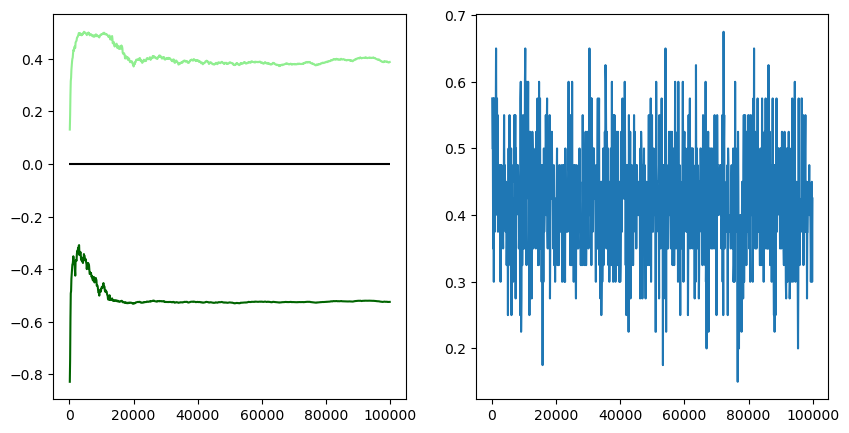

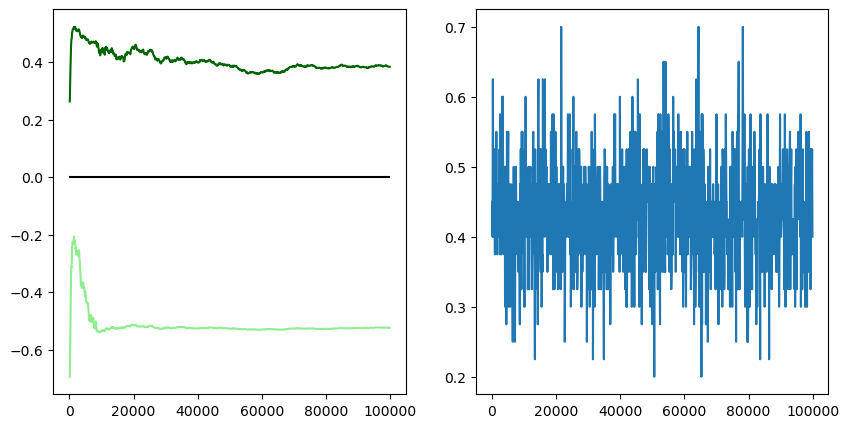

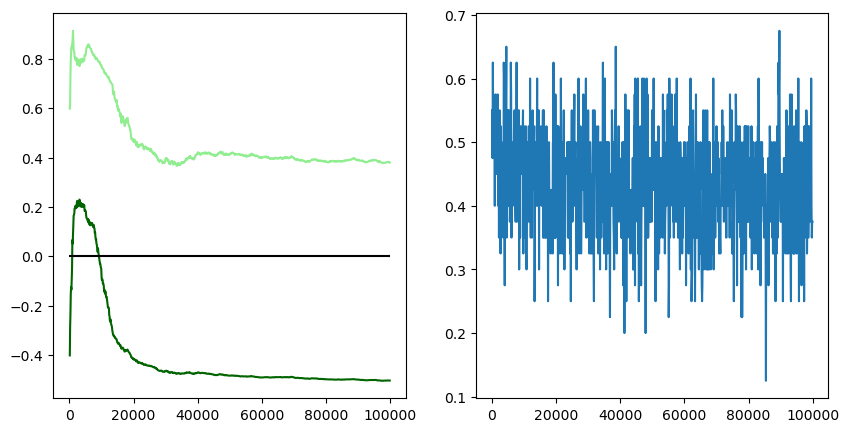

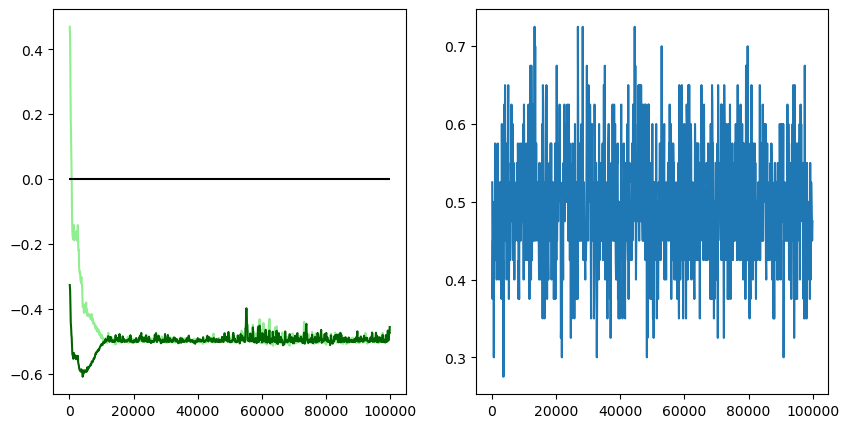

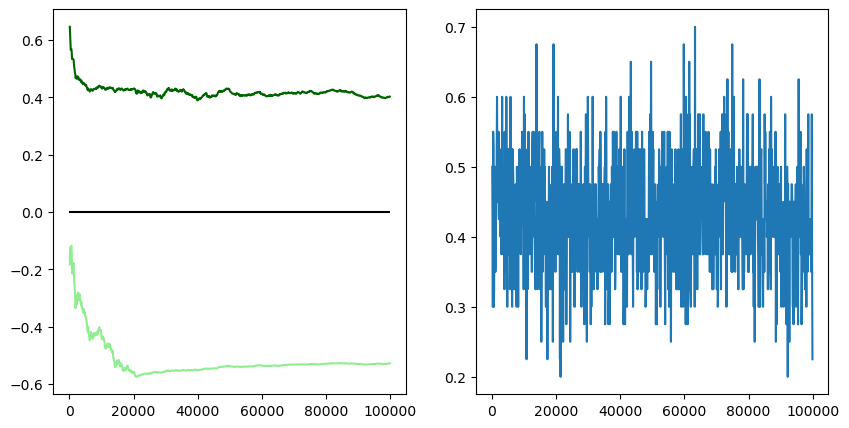

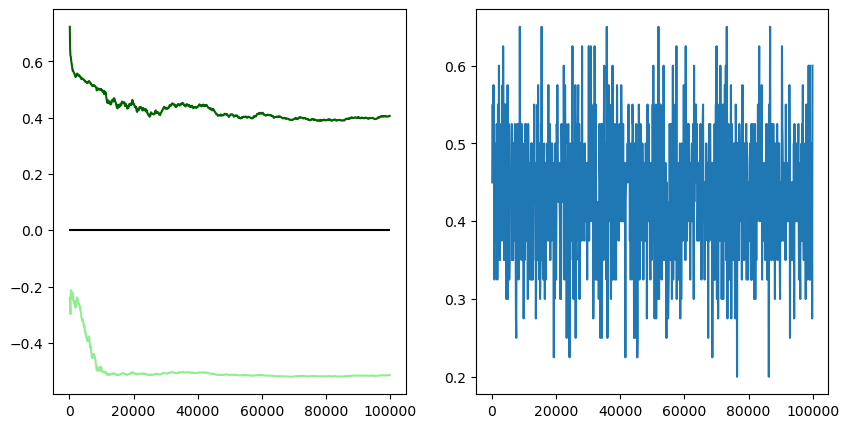

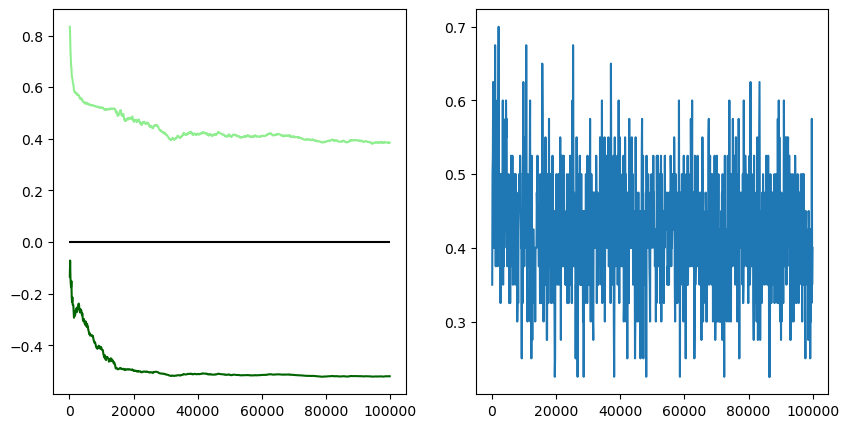

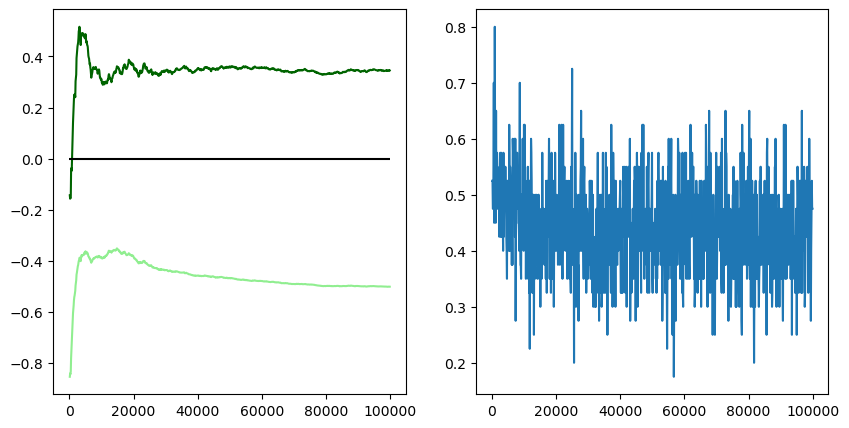

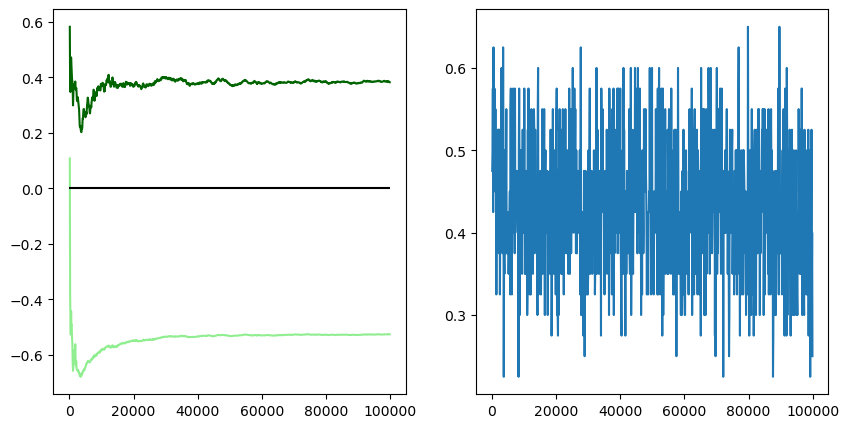

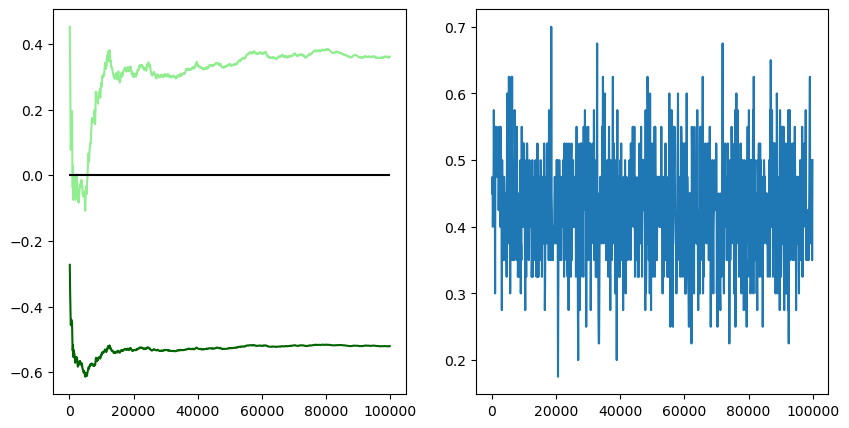

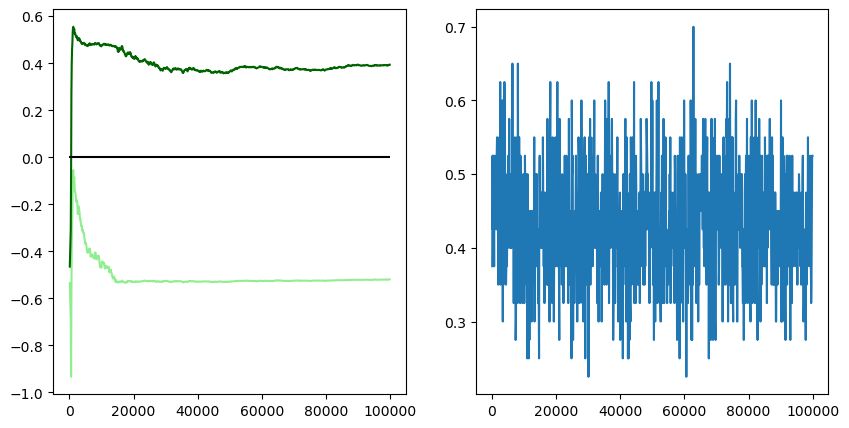

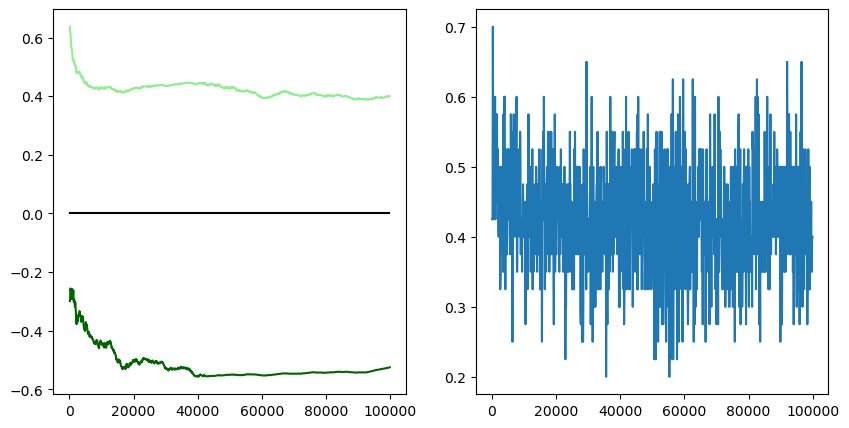

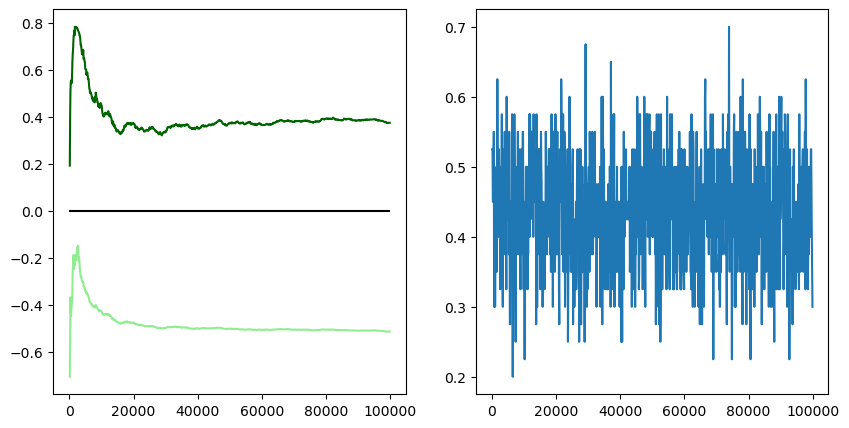

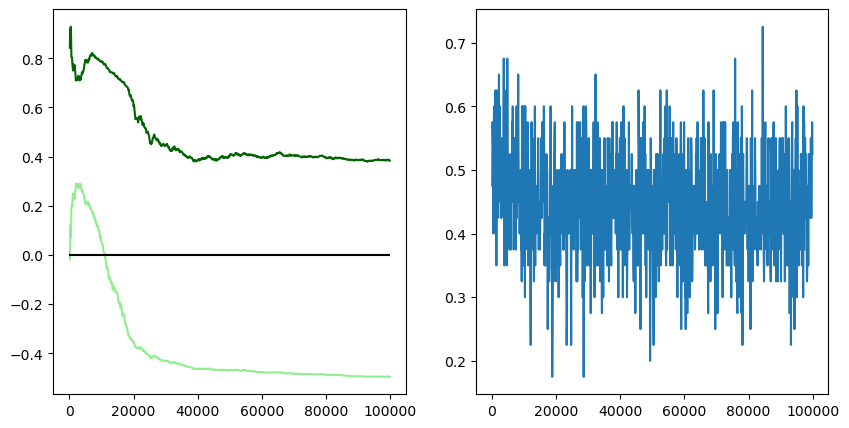

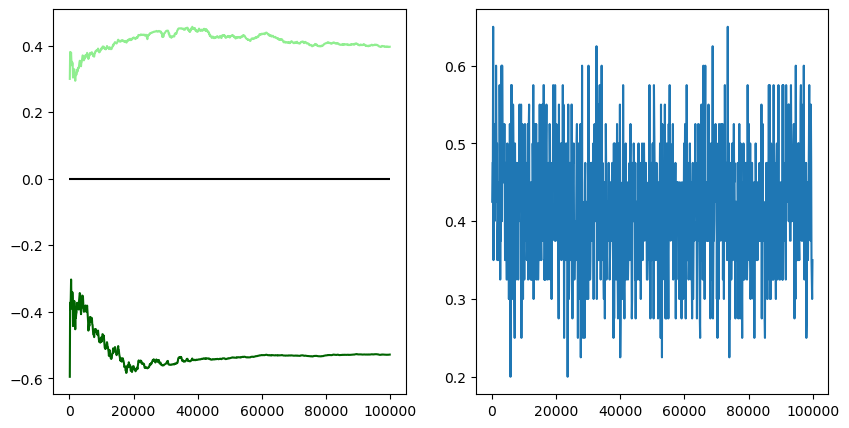

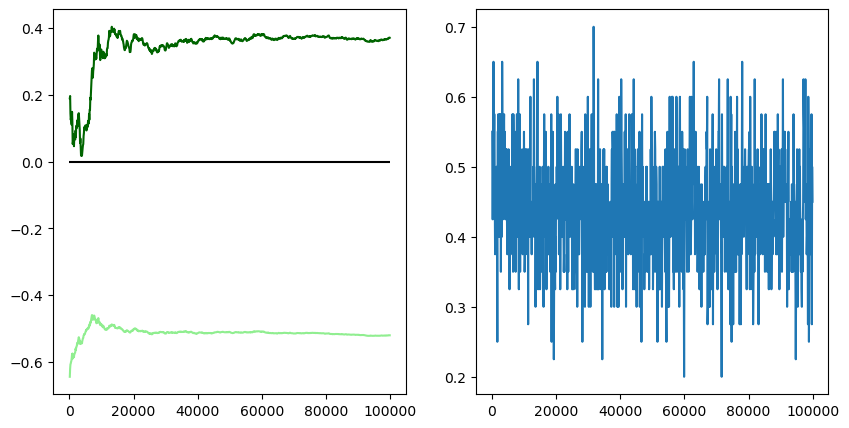

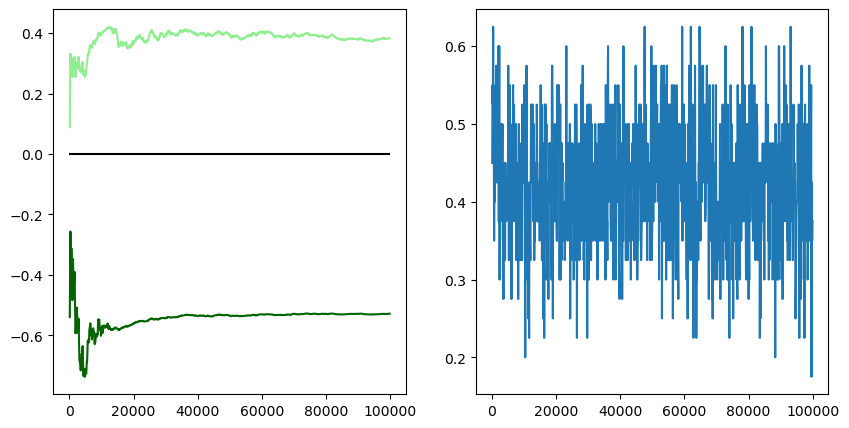

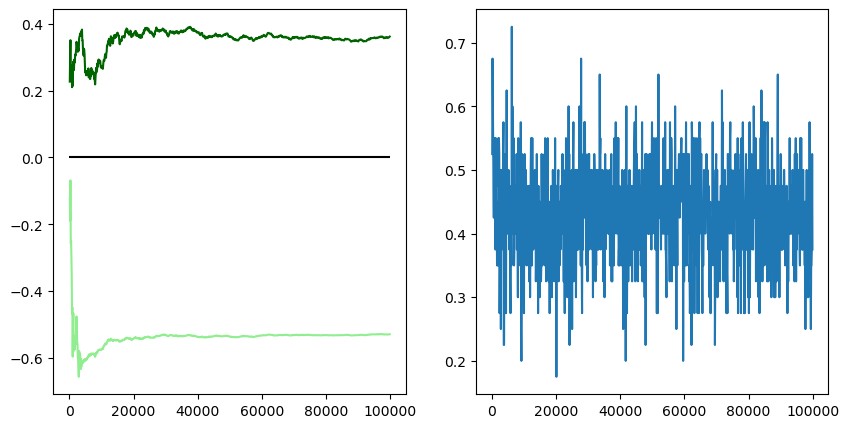

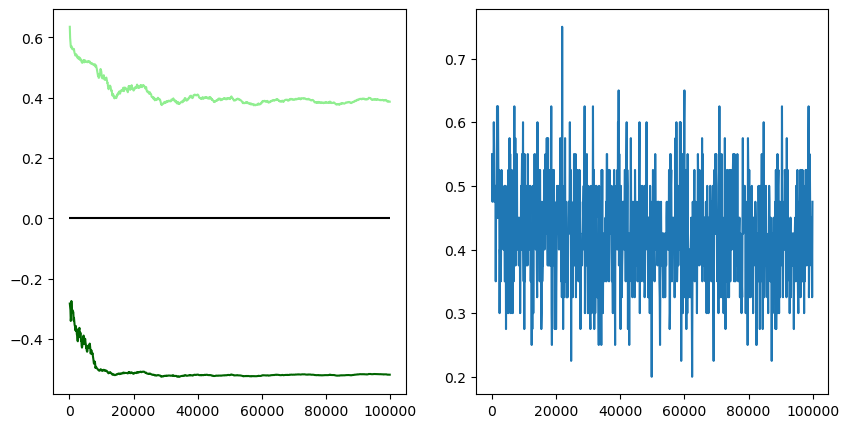

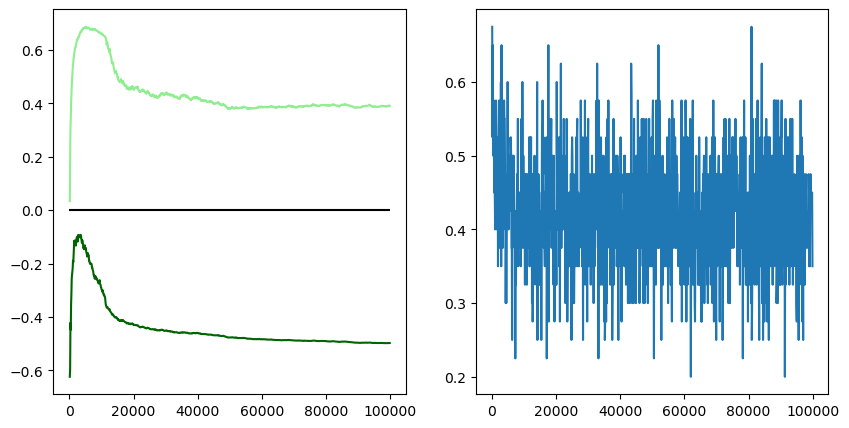

In [133]:
for df in dfs:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
#     ax1.plot(df.epoch, np.mean([df.Ha1, df.Ha0], axis=0))
    ax1.plot(df.epoch, df.Ha0, c='lightgreen')
    ax1.plot(df.epoch, df.Ha1, c='darkgreen')
#     ax1.plot(df.epoch, np.mean([df.V1a1, df.V1a0], axis=0), c='blue')
# #     ax1.plot(df.epoch, np.mean([df.V2a1, df.V2a0], axis=0), c='orange')
#     ax1.scatter(df.epoch, df.V1a0, c='lightblue')
#     ax1.scatter(df.epoch, df.V1a1, c='darkblue')
#     ax1.scatter(df.epoch, df.V2a0, c='orange')
#     ax1.scatter(df.epoch, df.V2a1, c='darkorange')
    ax1.hlines(0,0, np.max(df.epoch),color='k')
    ax2.plot(df.epoch, df.test_err)
    plt.show()

# Initialization

## Visible bias: 
normally distributed with mean 0., std 1.

## Hidden bias: 
0.

## Weights: 
normally distributed with mean 0., std 0.1

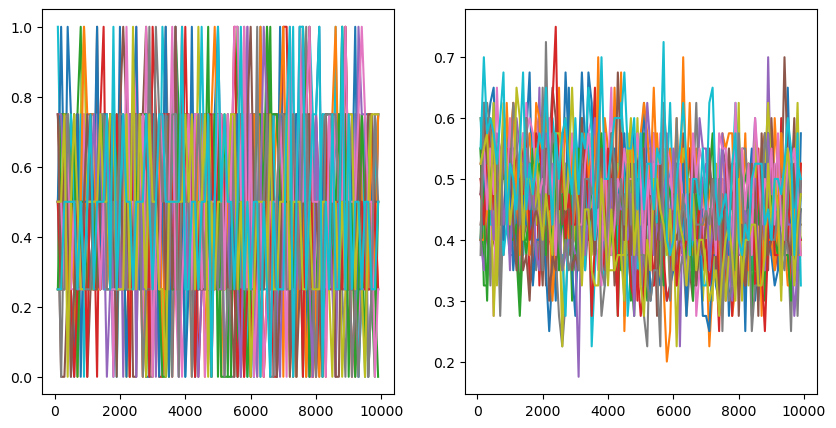

In [131]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

# fig2, ax2 = plt.subplots()
for df in dfs:
    ax1.plot(df.epoch, df.train_err)
    ax2.plot(df.epoch, df.test_err)